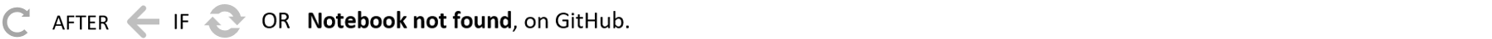

[Return to README](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/README.md#explore-the-project)

# Wikipedia Notable Life Expectancy
## Notebook 8: Data Cleaning Part 7
### Contents

This notebook covers:
- Extracting `known for` and `cause_of_death` with `known_for_dict` (multiple iterations):
    - `info_3_1`
    - `info_3_2`
    - `info_4_0`
    - `info_4_1`
    - `info_4_2`
    - `info_5_0`
    - `info_5_1`
    - `info_5_2`
    - `info_6_0`
    - `info_6_1`
    - `info_7_0`
    - `info_8_0`
    - `info_8_1`
    - `info_9_0`
    - `info_10_0`
    - `info_11_0`
- Exporting partially-cleaned dataset to SQLite database

***NOTE: Refer to [Notebook 5: Data Cleaning Part 4](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_data_clean4_thanak_2022_08_05.ipynb) "Extracting `known for` Data" section, for outlined approach.

### Instructions
Options for Running this Notebook:  
 ***NOTE: This is a long-running notebook.
1. Clone the repository:   
    - Delete the following file that is generated by this notebook:
        - [wp_life_expect_clean7.db](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_clean3.db)
    - Navigate to the cloned repository in Jupyter and open the notebook to run it.
    - Refer to [Application and Package Versions](https://github.com/teresahanak/wikipedia-life-expectancy#application-and-package-versions).
2. Save the notebook and database file below to the same working directory:<sup>1</sup>
    - Download the notebook:
        - Click on <kbd>Raw</kbd> above.
        - Save <kbd>Ctrl</kbd> + <kbd>S</kbd>
    - Follow the link to the database file and click <kbd>Download</kbd>, then move file to the same directory as the notebook:
        - [wp_life_expect_clean6.db](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_clean2.db)<sup>2</sup>
    - In Jupyter, navigate to the directory in which the notebook and file are saved to open and run the notebook.  
    - Refer to [Application and Package Versions](https://github.com/teresahanak/wikipedia-life-expectancy#application-and-package-versions).

    

### Data Dictionary for Loaded Version of Dataset
- **day**:  Day of the month of the individual's death
- **name**:  Name of the individual
- **info**:  Combined Wikipedia-defined fields:
> Name, age, country of citizenship at birth, subsequent country of citizenship (if applicable), reason for notability, cause of death (if known), and reference.<sup>3</sup>
>
- **link**:  Link to an individual's page
- **num_references**:  Number of references for individual's page
- **year**: Year of the individual's death
- **month**: Month of the individual's death
- **info_parenth**: Parenthetical contents previously in info column
- **age**: Age of individual at death in years
- **cause_of_death**: Cause of death of individual
- **place_1**: Place of residence at birth
- **place_2**: Subsequent place of residence (if applicable)
- **info_parenth_copy**: working copy of info_parenth
- **info_3_1** through **info_11_0**: Resultant remaining sub-columns of second split (on "and") of previously split (on commas) info (info_1_, info_2_, and info_3_1 sub-columns already exhausted and dropped)
- **sciences**: (0 for no or 1 for yes) individual known for sciences (math, physics, chemistry, engineering, mechanics, etc.)
- **social**: (0 for no or 1 for yes) individual known for social action (philanthropy, fund-raising for social cause, founder of charity, etc.)
- **spiritual**: (0 for no or 1 for yes) individual known for spiritual association (religious association, traditional healing, self-help/motivational instructor, etc.)
- **academia_humanities**: (0 for no or 1 for yes) individual known for education activity (educator, education administration, lecturer, etc.; excludes sports-related instruction/coaching, but includes art/performing arts instruction; includes museum-related activities; classics, archeology, linguistics, anthropology, etc.)
- **business_farming**: (0 for no or 1 for yes) individual known for business or farming (includes marketing, millionaire/billionaire, manufacturing, oil/energy)
- **arts**: (0 for no or 1 for yes) individual known for arts-related activity (fine and performing arts, journalism, writing, arts administration, art patronage, collecting, etc.; gallery owners/founders are included; museum-related is excluded; stunt performers included)
- **sports**: (0 for no or 1 for yes) individual known for sports-related activity (traditional sports participation/instruction/coaching/ownership/fandom/commentator and anything competition-based, including non-physical games, such as chess; sportswriter, etc. would have dual category of arts)
- **law_enf_military_operator**: (0 for no or 1 for yes) individual known for law enforcement, military/paramilitary association/activity, or specialized equipment operation (pilot, ship captain (non-sport), radio operator, etc.); category aims to reflect individual's proximity to activity and/or weapons/equipment or decision-making that could impact life span, independent of legality of activity
- **politics_govt_law**: (0 for no or 1 for yes) individual known for political activity (official or activism), participation in legal system (lawyer, judge, etc.), nobility or inherited status; directly or by marriage; union activity is included
- **crime**: (0 for no or 1 for yes) individual known for criminal activity; category aims for "innocent until proven guilty", includes convicted criminals (can be for a different crime); includes individuals labeled "terrorist", but generally excludes individuals awaiting trial who are instead assigned to event_record_other category
- **event_record_other**: (0 for no or 1 for yes) individual known for activity that does not fit another category, or a passive attribute, e.g., "tallest person"; being a victim or survivor of an event included
- **other_species**: (0 for no or 1 for yes) Non-human entries
- **num_categories**: Total number of known for categories for individual

### Importing Libraries

In [1]:
# To structure code automatically
%load_ext nb_black

# To import/export sqlite databases
import sqlite3 as sql

# To save/open python objects in pickle file
import pickle

# To help with reading, cleaning, and manipulating data
import pandas as pd
import numpy as np
import re

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
# To define the maximum number of rows to be displayed in a dataframe
pd.set_option("display.max_rows", 200)

# To supress warnings
# import warnings

# warnings.filterwarnings("ignore")

# To set some visualization attributes
pd.set_option("max_colwidth", 150)

# To play auditory cue when cell has executed, has warning, or has error and set chime theme
import chime

chime.theme("zelda")

<IPython.core.display.Javascript object>

## Data Overview

### [Reading](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_clean6.db), Sampling, and Checking Data Shape

In [2]:
# Reading the dataset
conn = sql.connect("wp_life_expect_clean6.db")
data = pd.read_sql("SELECT * FROM wp_life_expect_clean6", conn)

# Making a working copy
df = data.copy()

# Checking the shape
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")

# Checking first 2 rows of the data
df.head(2)

There are 98040 rows and 42 columns.


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
0,1,William Chappell,", 86, British dancer, ballet designer and director.",https://en.wikipedia.org/wiki/William_Chappell_(dancer),21,1994,January,None,86.0,None,United Kingdom of Great Britain and Northern Ireland,None,None,director,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,0,0,0,1,0,0,0,0,0,0,1
1,1,Raymond Crotty,", 68, Irish economist, writer, and academic.",https://en.wikipedia.org/wiki/Raymond_Crotty,12,1994,January,None,68.0,None,Ireland,None,None,None,None,and academic,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,0,0,0,1,0,0,1,0,0,0,2


<IPython.core.display.Javascript object>

In [3]:
# Checking last 2 rows of the data
df.tail(2)

,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
98038,9,Aamir Liaquat Hussain,", 50, Pakistani journalist and politician, MNA .",https://en.wikipedia.org/wiki/Aamir_Liaquat_Hussain,99,2022,June,"2002 2007, since 2018",50.0,None,Pakistan,None,", since",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,0,0,0,1,0,0,1,0,0,0,2
98039,9,Zou Jing,", 86, Chinese engineer, member of the Chinese Academy of Engineering.",https://en.wikipedia.org/wiki/Zou_Jing_(engineer),3,2022,June,None,86.0,None,"China, People's Republic of",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1,0,0,0,0,0,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

In [4]:
# Checking a sample of the data
df.sample(5)

,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
85620,1,Abhay Bharadwaj,", 66, Indian politician, MP , COVID-19.",https://en.wikipedia.org/wiki/Abhay_Bharadwaj,4,2020,December,since 2020,66.0,None,India,None,since,None,None,COVID,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,0,0,0,0,0,0,1,0,0,0,1
85502,25,Saïd Bouhadja,", 82, Algerian politician, president of the People's National Assembly .",https://en.wikipedia.org/wiki/Sa%C3%AFd_Bouhadja,5,2020,November,2017 2018,82.0,None,Algeria,None,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,0,0,0,0,0,0,1,0,0,0,1
95774,1,Remi De Roo,", 97, Canadian Roman Catholic prelate, bishop of Victoria .",https://en.wikipedia.org/wiki/Remi_De_Roo,21,2022,February,1962 1999,97.0,None,Canada,None,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,1,0,0,0,0,0,0,0,0,0,1
5214,27,Cecil Arthur Lewis,", 98, British last surviving World War I fighter ace.",https://en.wikipedia.org/wiki/Cecil_Arthur_Lewis,22,1997,January,None,98.0,None,United Kingdom of Great Britain and Northern Ireland,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,0,0,0,0,0,1,0,0,0,0,1
743,19,Krešimir Račić,", 61, Croatian hammer thrower and Olympian.",https://en.wikipedia.org/wiki/Kre%C5%A1imir_Ra%C4%8Di%C4%87,3,1994,June,None,61.0,None,Croatia,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,0,0,0,0,1,0,0,0,0,0,1


<IPython.core.display.Javascript object>

### Checking Data Types and Null Values

In [5]:
# Checking data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98040 entries, 0 to 98039
Data columns (total 42 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   day                        98040 non-null  object 
 1   name                       98040 non-null  object 
 2   info                       98040 non-null  object 
 3   link                       98040 non-null  object 
 4   num_references             98040 non-null  int64  
 5   year                       98040 non-null  int64  
 6   month                      98040 non-null  object 
 7   info_parenth               36660 non-null  object 
 8   age                        98040 non-null  float64
 9   cause_of_death             25121 non-null  object 
 10  place_1                    97885 non-null  object 
 11  place_2                    5897 non-null   object 
 12  info_parenth_copy          36660 non-null  object 
 13  info_3_1                   4664 non-null   obj

<IPython.core.display.Javascript object>

#### Observations:
- With our dataset loaded, we can pick up where we left off with extracting `known for` and `cause_of_death` values.
- To avoid overwriting any existing `cause_of_death` values that might flow into 2 columns, such as, "heart and lung problems", we will update the code to combine the values.

### Extracting Remaining `known for` and `cause_of_death` Values Continued

#### Finding `known for` Roles and `cause_of_death` in `info_3_1`

In [6]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_3_1"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [7]:
# # Code to check each value
# roles_cause_list.pop()

<IPython.core.display.Javascript object>

In [8]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_3_1"].notna()].index
#             if "diabetes" in df.loc[index, "info_3_1"]
#             #             and df.loc[index, "politics_govt_law"] == 0
#             #             and df.loc[index, "arts"] == 1
#             #             and df.loc[index, "sciences"] == 0
#             #             and df.loc[index, "spiritual"] == 0
#             #             and df.loc[index, "law_enf_military_operator"] == 0
#             #             and df.loc[index, "sports"] == 0
#             #             and df.loc[index, "event_record_other"] == 0
#             #             and df.loc[index, "crime"] == 0
#             #             and df.loc[index, "academia_humanities"] == 0
#             #             and df.loc[index, "business_farming"] == 0
#             #                         and df.loc[index, "other_species"] == 0
#             #             and df.loc[index, "num_categories"] == 0
#         ],
#         "info_3_1",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [9]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [10]:
# # Example code to quick-check a specific entry
# df[df["info_3_1"] == "diabetes"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [11]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "an National Congress politician",
    "politician Sir Abe Bailey",
    "Conservative politician",
    "neo fascist politician",
    "provincial politician",
    "former politician",
    "politician",
    "author of the Declaration of Independence of",
    "editorial director of Antiwar com",
    "Housing",
    "housing",
    "medical education",
    "activist against animal testing",
    "activist for victims of Nazism",
    "transgender rights activist",
    "anti apartheid activist",
    "anti Communist activist",
    "lesbian rights activist",
    "environmental activist",
    "animal rights activist",
    "Black lesbian activist",
    "human rights activist",
    "civil rights activist",
    "women rights activist",
    "LGTBI rights activist",
    "Lingayatism activist",
    "health care activist",
    "LGBT rights activist",
    "gay rights activist",
    "political activist",
    "anti war activist",
    "feminist activist",
    "cannabis activist",
    "internet activist",
    "cultural activist",
    "Garifuna activist",
    "consumer activist",
    "literary activist",
    "Marxist activist",
    "social activist",
    "public activist",
    "Native activist",
    "gender activist",
    "rights activist",
    "LGBTQ activist",
    "peace activist",
    "AIDS activist",
    "diplomat",
    "outspoken critic of President Vladimir Putin",
    "government critic",
    "social critic",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "songwriter in the country music genre",
    "writer of children books",
    "funk singer songwriter",
    "science fiction writer",
    "writer of literature",
    "television writer",
    "singer songwriter",
    "screenplay writer",
    "nonfiction writer",
    "children writer",
    "fantasy writer",
    "fiction writer",
    "travel writer",
    "comics writer",
    "screenwriter",
    "scriptwriter",
    "songwriter",
    "was the author of two books on Parliament",
    "author of more than music instruction books",
    "popular science author",
    "book author",
    "children book author",
    "relationship author",
    "best selling author",
    "short story author",
    "children author",
    "cookbook author",
    "textbook author",
    "actor land National Artist",
    "big screen movie actor",
    "television actor",
    "theatre actor",
    "voice actor",
    "child actor",
    "stage actor",
    "film actor",
    "actor",
    "independent producer",
    "television producer",
    "theatrical producer",
    "R&B record producer",
    "theatre producer",
    "record producer",
    "music producer",
    "blues producer",
    "movie producer",
    "film producer",
    "BBC producer",
    "TV producer",
    "television producer",
    "video game journalist",
    "literary journalist",
    "music journalist",
    "art journalist",
    "television composer",
    "film score composer",
    "music composer",
    "samba composer",
    "film composer",
    "executive director of the Producers Guild of",
    "artistic director of the National Ballet of",
    "former deputy managing director of",
    "documentary film director",
    "pornographic director",
    "television director",
    "artistic director",
    "theatre director",
    "dubbing director",
    "theater director",
    "musical director",
    "stage director",
    "music director",
    "opera director",
    "film director",
    "wife of singing cowboy Roy Rogers",
    "singer for The Lovin' Spoonful",
    "funk singer songwriter",
    "musical comedy singer",
    "singer songwriter",
    "rockabilly singer",
    "jíbaro singer",
    "bolero singer",
    "reggae singer",
    "opera singer",
    "funk singer",
    "pop singer",
    "singer",
    "Urdu poet",
    "photography historian",
    "multi instrumental session musician",
    "musician on early Tamla sessions",
    "jazz musician",
    "soul musician",
    "R&B musician",
    "a musician",
    "musician",
    "playwright",
    "theatre activist",
    "son of novelist Ernest Hemingway",
    "novelist",
    "novels",
    "broadcaster on public media",
    "radio broadcaster",
    "broadcaster",
    "podcaster",
    "literary magazine editor",
    "chief editorialist of",
    "contributing editor",
    "editor in chief of",
    "thesaurus editor",
    "newspaper editor",
    "magazine editor",
    "first editor of",
    "graphic editor",
    "story editor",
    "editor of",
    "editor",
    "film critic for The Times",
    "literary critic",
    "theater critic",
    "theatre critic",
    "music critic",
    "film critic",
    "art critic",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "rules writer",
    "automobile journalist",
    "radio sports journalist",
    "athletic director",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "rose authority",
    "flight director in the Mission Control Center at Johnson Space Center",
    "the first director of Institute for Biological Research",
    "managing director of ONGC",
    "reprocessing",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "agricultural producer",
    "executive director of the Mori Building Company",
    "managing director of AmBank",
    "Housing Association",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "authority on",
    "director of the Curtis Institute of Music",
    "director of the Head Start Program",
    "director of Georgetown Day School",
    "director of the Planetarium",
    "museum director",
    "academic; Chancellor of the University of Dublin",
    "an academician of the Academy of Sciences",
    "academic administrator",
    "academician",
    "academic",
    "poetry teacher",
    "translator of ancient epics",
    "translator of literature",
    "comic book translator",
    "translator of",
    "translator",
    "literary historian",
    "language historian",
    "ethno historian",
    "urban historian",
    "art historian",
    "historian of medieval and",
    "historic preservationist",
    "ecclesiastical historian",
    "military historian",
    "culinary historian",
    "science historian",
    "naval historian",
    "film historian",
    "music educator",
    "art educator",
    "educationist",
    "education",
    "educator",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = []
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "prominent Latter day Saint author",
    "church music composer",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = ["philanthropist"]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "complications of pneumonia",
    "pneumonia",
    "congestive heart failure",
    "multiple organ failure",
    "chronic renal failure",
    "respiratory failure",
    "pulmonary failure",
    "cardiac failure",
    "kidney failure",
    "heart failure",
    "renal failure",
    "liver failure",
    "organ failure",
    "lung failure",
    "kidney complications",
    "kidney problems",
    "kidney ailments",
    "kidney disease",
    "kidney cancer",
    "complications from COVID",
    "COVID",
    "complications of diabetes",
    "diabetes",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [12]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_3_1`

In [13]:
%%time

# Column to check
column = 'info_3_1'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 25122 values in cause_of_death column.

CPU times: total: 7.25 s
Wall time: 7.25 s


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [14]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    85030
2    12500
3      497
0        8
4        5
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_3_1`

In [15]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_3_1"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [16]:
# # Code to check each value
# roles_cause_list.pop()

<IPython.core.display.Javascript object>

In [17]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_3_1"].notna()].index
#             if "House" in df.loc[index, "info_3_1"]
#             #             and df.loc[index, "politics_govt_law"] == 1
#             #             and df.loc[index, "arts"] == 0
#             #             and df.loc[index, "sciences"] == 0
#             #             and df.loc[index, "spiritual"] == 0
#             #             and df.loc[index, "law_enf_military_operator"] == 0
#             #             and df.loc[index, "sports"] == 1
#             #             and df.loc[index, "event_record_other"] == 0
#             #             and df.loc[index, "crime"] == 0
#             #             and df.loc[index, "academia_humanities"] == 0
#             #             and df.loc[index, "business_farming"] == 0
#             #                         and df.loc[index, "other_species"] == 0
#             #             and df.loc[index, "num_categories"] == 0
#         ],
#         "info_3_1",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [18]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [19]:
# # Example code to quick-check a specific entry
# df[df["info_3_1"] == "Crime Commissioner"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [20]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "activist",
    "lawyer",
    "colonial administrator",
    "life peer",
    "peer",
    "convicted dissident",
    "political dissident",
    "Castro dissident",
    "dissident",
    "Technology Policy",
    "Labrador MHA for Conception Bay East",
    "Labrador MHA",
    "conservationist",
    "Labrador House of Assembly member for St George",
    "Labrador House of Assembly for Gander",
    "Labrador House of Assembly",
    "Communications",
    "United Nations civil servant",
    "public servant",
    "civil servant",
    "attorney",
    "Finance",
    "environmentalist",
    "Majority Leader of the NY Senate",
    "deputy president of the Senate",
    "member of the State Senate",
    "Senator",
    "Senate",
    "senior judge of the District Court for the Central District of",
    "High Court judge",
    "th congressional districts",
    "nd congressional districts",
    "congressman",
    "feminist",
    "Trademark Office",
    "Foreign Trade",
    "Trade",
    "Budget",
    "ambassador to",
    "ambassador",
    "founder of the Saba Labour Party",
    "Labour Party donor",
    "Labour",
    "Health Service Commissioner",
    "Islamic Affairs; Member of the House of Representatives",
    "four time member of the House of Representatives",
    "Labrador House of Assembly member for St George",
    "Speaker of the Maine House of Representatives",
    "th Speaker of the House of Representatives",
    "Labrador House of Assembly for Gander",
    "member of the House of Lords",
    "Christel House International",
    "Labrador House of Assembly",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "writer",
    "author of",
    "author",
    "producer",
    "journalist",
    "composer",
    "director",
    "poet",
    "critic",
    "newspaper publisher",
    "music publisher",
    "book publisher",
    "publisher",
    "arranger of music for television",
    "music arranger",
    "arranger",
    "essayist",
    "television presenter",
    "radio presenter",
    "TV presenter",
    "presenter",
    "Nine Network television commentator",
    "arranger of music for television",
    "reality television cast member",
    "television hostess on cuisine",
    "television quiz contestant",
    "television talk show host",
    "reality television judge",
    "television personality",
    "CBS television network",
    "television presenter",
    "television announcer",
    "television executive",
    "television actress",
    "television host",
    "television",
    "photographer",
    "manager of actress Brooke Shields",
    "mother of actress Candice Bergen",
    "Oscar winning film actress",
    '"B" actress in the s',
    "television actress",
    "stage actress",
    "voice actress",
    "film actress",
    "actress",
    "multimedia fine artist",
    "record jacket artist",
    "installation artist",
    "performance artist",
    "comic strip artist",
    "recording artist",
    "make up artist",
    "digital artist",
    "plastic artist",
    "variety artist",
    "graphic artist",
    "visual artist",
    "comics artist",
    "escape artist",
    "light artist",
    "cyber artist",
    "mime artist",
    "sculptor",
    "guitarist",
    "dancer",
    "botanical illustrator",
    "book illustrator",
    "illustrator",
    "paintings of World War II",
    "painter",
    "orchestra conductor",
    "conductor",
    "Rolling Stones manager",
    "country music manager",
    "manager of Five Star",
    "cultural manager",
    "theatre manager",
    "stage manager",
    "jazz pianist",
    "pianist",
    "Oscar winning film actress",
    "conspiracy film maker",
    "underwater filmmaker",
    "film set designer",
    "sound film star",
    "film actress",
    "film censor",
    "film music",
    "film maker",
    "filmmaker",
    "film",
    "lyricist",
    "syndicated columnist",
    "columnist for the",
    "columnist",
    "administrator of the Old Globe Theatre",
    "musical administrator",
    "music administrator",
    "arts administrator",
    "acting coach",
    "vocal coach",
    "leader of comedic group The Drifters",
    "stand up comedian",
    "comedian",
    "last surviving husband",
    "Sonora Ponceña bands",
    "bandleader",
    "agent of TV entertainer Michael Barrymore",
    "comic entertainer",
    "entertainer",
    "radio personality",
    "radio presenter",
    "radio announcer",
    "radio host",
    "radio DJ",
    "radio show host",
    "art collector",
    "collector",
    "fashion model",
    "model",
    "record industry executive",
    "broadcasting executive",
    "record label executive",
    "studio executive",
    "chief executive",
    "news executive",
    "reality television judge",
    "competition judge",
    "socialite",
    "blogger",
    "choreographer",
    "performance artist",
    "cabaret performer",
    "stunt performer",
    "comic performer",
    "performer",
    "autobiographer",
    "biographer",
    "dramaturge",
    "dramatist",
    "reporter",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "martial artist",
    "t'ai chi teacher",
    "Capirossi team manager",
    "booking manager",
    "general manager",
    'last survivor of the Philadelphia Phillies\' "Whiz Kids" that won the National League championship',
    "athletics administrator",
    "games administrator",
    "former coach of golfer Tiger Woods",
    "basketball coach",
    "assistant coach",
    "football coach",
    "bandy player",
    "scout",
    "sports executive",
    "vice president of the International Olympic Committee",
    "two bronze medals at the Summer Olympics",
    "Olympic silver medallist",
    "Olympic figure skater",
    "silver medal Olympiad",
    "Olympic champion",
    "National Olympic",
    "Olympic sprinter",
    "Olympic medalist",
    "Olympic official",
    "Olympic athlete",
    "Winter Olympics",
    "Olympic gymnast",
    "Olympic fencer",
    "Olympic sailor",
    "Olympian",
    "Olympics",
    "MMA fighter",
    "speedway entrepreneur",
    "polar explorer",
    "explorer",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "Technology Beijing",
    "Technology Prize",
    "radio amateur",
    "various radio developments",
    "radio astronomy",
    "Director of the MIT Laboratory for Computer Science from to",
    "Biomedical Sciences",
    "sociologist",
    "mathematician",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "business executive",
    "small business",
    "businesswoman",
    "businessman",
    "hospital administrator",
    "business executive",
    "retail executive",
    "entrepreneur",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "historian",
    "philosophy professor",
    "philosopher",
    "professor at George Washington University",
    "constitutional law professor",
    "professor of literature",
    "professor of medicine",
    "university professor",
    "philosophy professor",
    "professor of music",
    "college professor",
    "professor",
    "scholar of medieval literature",
    "Shakespeare scholar",
    "literary scholar",
    "scholar",
    "university administrator",
    "ethnomusicologist",
    "musicologist",
    "art lecturer",
    "lecturer",
    "museum curator",
    "curator",
    "founder of the Boston Museum of Science",
    "member of the Academy of Sciences",
    "the Academy of Social Sciences",
    "The World Academy of Sciences",
    "theatrical pedagogue",
    "pedagogue",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "son of a professor who became a rebel leader",
    "resistance fighter during World War II",
    "guerrilla fighter",
    "freedom fighter",
    "fighter ace",
    "architect of the Air Force space",
    "Crime Commissioner",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = ["islamic theologist", "theologian"]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    "charitable organization executive",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = ["convicted murderer", "murderer"]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = ["concentration camp survivor", "Holocaust survivor"]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = ["sire"]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "prostate cancer",
    "influenza following skin cancer",
    "complications from cancer",
    "bone marrow cancer",
    "colorectal cancer",
    "lymph node cancer",
    "pancreatic cancer",
    "peritoneal cancer",
    "prostate cancer",
    "tracheal cancer",
    "bladder cancer",
    "stomach cancer",
    "throat cancer",
    "breast cancer",
    "spinal cancer",
    "liver cancer",
    "colon cancer",
    "brain cancer",
    "spine cancer",
    "bowel cancer",
    "lung cancer",
    "bone cancer",
    "neck cancer",
    "cancer",
    "chronic obstructive pulmonary disease",
    "complications from Alzheimer disease",
    "complications of Alzheimer disease",
    "coronary artery disease",
    "cardiovascular disease",
    "valvular heart disease",
    "pulmonary diseases",
    "Parkinson disease",
    "Alzheimer disease",
    "heart disease",
    "liver disease",
    "lung disease",
    "complications from a stroke",
    "multiple strokes",
    "a stroke",
    "stroke",
    "emphysema",
    "Possible heart attack",
    "valvular heart disease",
    "heart complications",
    "heart condition",
    "heart problems",
    "heart disease",
    "heart attack",
    "heart failur",
    "Lewy body dementia",
    "dementia",
    "complications of multiple sclerosis",
    "amyotrophic lateral sclerosis",
    "multiple sclerosis",
    "barbiturate overdose",
    "accidental overdose",
    "morphine overdose",
    "alcohol overdose",
    "heroin overdose",
    "drug overdose",
    "cardiac complications",
    "cardiac ailment",
    "cardiac arrest",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [21]:
# Dropping info_3_1 value for entries with duplicate category value
df.loc[[index for index in df[df["info_3_1"] == "manager"].index], "info_3_1"] = ""

# Dropping info_3_1 value for entries with duplicate category value
df.loc[[index for index in df[df["info_3_1"] == "administrator"].index], "info_3_1"] = ""

# Dropping info_3_1 value for entries with duplicate category value
df.loc[[index for index in df[df["info_3_1"] == "Labrador"].index], "info_3_1"] = ""


<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [22]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_3_1`

In [23]:
%%time

# Column to check
column = 'info_3_1'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 25128 values in cause_of_death column.

CPU times: total: 9.23 s
Wall time: 9.28 s


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [24]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84809
2    12546
3      671
0        8
4        6
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_3_1`

In [25]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_3_1"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [26]:
# # Code to check each value
# roles_cause_list.pop()

<IPython.core.display.Javascript object>

In [27]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_3_1"].notna()].index
#             if "osis" in df.loc[index, "info_3_1"]
#             #             and df.loc[index, "politics_govt_law"] == 0
#             #             and df.loc[index, "arts"] == 1
#             #             and df.loc[index, "sciences"] == 0
#             #             and df.loc[index, "spiritual"] == 0
#             #             and df.loc[index, "law_enf_military_operator"] == 0
#             #             and df.loc[index, "sports"] == 1
#             #             and df.loc[index, "event_record_other"] == 0
#             #             and df.loc[index, "crime"] == 0
#             #             and df.loc[index, "academia_humanities"] == 0
#             #             and df.loc[index, "business_farming"] == 0
#             #                         and df.loc[index, "other_species"] == 0
#             #             and df.loc[index, "num_categories"] == 0
#         ],
#         "info_3_1",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [28]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [29]:
# # Example code to quick-check a specific entry
# df[df["info_3_1"] == "all"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [30]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "social commentator",
    "judge",
    "barrister",
    "Chiswick",
    "Industry",
    "railroad worker",
    "Kennedy Administration official",
    "elected official in Toledo",
    "government official",
    "public official",
    "CCPPC official",
    "behavioral economist",
    "political economist",
    "economist",
    "political scientist",
    "Natural Resources",
    "anti communist zealot who helped set the stage for McCarthyism",
    "anti communist",
    "communist",
    "three time president of the senate",
    "senator",
    "Tirunelveli",
    "Social Security",
    "Nicobar Islands",
    "Caicos Islands",
    "the Islands",
    "conspiracy theorist",
    "social theorist",
    "Forestry",
    "th districts",
    "Cultural Affairs",
    "Kennedy Administration official",
    "Drug Administration reviewer",
    "Administration Commission",
    "Drug Administration",
    "political prisoner",
    "Tourism",
    "Associate Justice of the Supreme Court of the",
    "Justice of the Michigan Supreme Court",
    "Justice",
    "Energy",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "artist",
    "printmaker",
    "dog trainer",
    "public speaker",
    "memoirist",
    "a promoter of culture",
    "hip hop promoter",
    "publicist",
    "humorist",
    "cabaret impresario",
    "impresario",
    "architect",
    "vocalist for Robin Trower",
    "vocalist",
    "Emmy winning documentarian",
    "documentarian",
    "talent agent",
    "theater production designer",
    "pinball machine designer",
    "album cover designer",
    "typeface designer",
    "interior designer",
    "fashion designer",
    "costume designer",
    "garden designer",
    "stage designer",
    "font designer",
    "set designer",
    "Roll Hall of Fame",
    "foreign correspondent",
    "correspondent",
    "stuntman",
    "recorded with Linda Ronstadt",
    "multitrack tape recording",
    "recording studio owner",
    "record label founder",
    "record label owner",
    "matchbox",
    "chairman of San Diego Comic Con International",
    "reality TV personality",
    "Internet personality",
    "theatre personality",
    "TV personality",
    "flag",
    "harmonica player",
    "bukkehorn player",
    "banjo player",
    "organ player",
    "bass player",
    "concertmaster",
    "newsreader",
    "magazine cartoonist",
    "cartoonist",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "coach",
    "executive",
    "sports official",
    "professional wrestler",
    "endurance runner",
    "runner",
    "member of the Pro Football Hall of Fame",
    "a member of the Baseball Hall of Fame",
    "Sports Hall of Fame",
    "FIBA Hall of Fame",
    "holder of nine world records",
    "world record holder for",
    "world record holder",
    "world champion kickboxer",
    "boxing referee",
    "boxer",
    "former Clemson football player",
    "table tennis player",
    "rugby union player",
    "ice hockey player",
    "baseball player",
    "handball player",
    "football player",
    "cricket player",
    "bridge player",
    "polo player",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "physician",
    "psychiatrist",
    "computer scientist",
    "computer engineer",
    "behavioral physiologist",
    "micropaleontologist",
    "plant pathologist",
    "parapsychologist",
    "pharmacologist",
    "epileptologist",
    "copepodologist",
    "epistemologist",
    "meteorologist",
    "criminologist",
    "methodologist",
    "ornithologist",
    "haematologist",
    "entomologist",
    "neurologist",
    "cosmologist",
    "pathologist",
    "serologist",
    "sexologist",
    "ufologist",
    "ecologist",
    "clinical psychologist",
    "petrologist",
    "neuroscientist",
    "neurologist",
    "designer of GPS",
    "Higgs boson theorist",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "inventor of the fast food system",
    "investment banker",
    "banker",
    'Apple as the "computer for the rest of us"',
    "restaurateur",
    "farmer",
    "multi millionaire industrialist",
    "industrialist",
    "Director of the Institute of Business Administration",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "teacher",
    "inventor of Cued Speech",
    "Sciences of",
    "anthropologist",
    "anthropologist",
    "archaeologist",
    "paremiologist",
    "japanologist",
    "philologist",
    "museologist",
    "indologist",
    "sinologist",
    "evolutionary theorist",
    "intellectual",
    "linguist",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "cryptologist",
    "intelligence officer",
    "military officer",
    "police officer",
    "army officer",
    "Army officer",
    "veteran of World War II",
    "veteran of World War I",
    "World War II veteran",
    "World War I veteran",
    "oldest WWII veteran",
    "war veteran",
    "Atmospheric Administration Commissioned Officer Corps",
    "Colditz prisoner",
    "prisoner of war",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "motivational speaker",
    "gospel",
    "Anglican priest",
    "Wiccan priest",
    "Jesuit priest",
    "priestess",
    "priest",
    "archbishop of the Anglican Church of Papua New",
    "the Cayman Islands",
    "Brecon",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    "humanitarian",
    "social worker",
    "project designer in the Boy Scouts of",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = [
    "convicted fraudster",
    "convicted terrorist",
    "convicted criminal",
    "convicted perjurer",
    "convicted rapist",
    "extortionist",
]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "documentary subject",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "hypertension",
    "acute myeloid leukemia",
    "leukemia",
    "stabbed",
    "run motorcycle accident",
    "run car accident",
    "run car crash",
    "run accident",
    "murdered by the Lukashenko regime",
    "murdered",
    "liver related problems",
    "respiratory problems",
    "COPD",
    "shot",
    "pancreatitis",
    "encephalitis",
    "hepatitis B",
    "hepatitis C",
    "peritonitis",
    "meningitis",
    "hepatitis",
    "sepsis",
    "lung ailments",
    "lung ailment",
    "lung transplant surgery",
    "lung infections",
    "lung condition",
    "urinary tract infection",
    "brain infection",
    "chest infection",
    "lung infections",
    "liver infection",
    "tuberculosis",
    "cirrhosis",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [31]:
# Dropping info_3_1 value for entries with duplicate category value
df.loc[[index for index in df[df["info_3_1"] == "Technology"].index], "info_3_1"] = ""

# Dropping info_3_1 value for entries with duplicate category value
df.loc[
    [
        index
        for index in df[df["info_3_1"].notna()].index
        if "Science" in df.loc[index, "info_3_1"]
    ],
    "info_3_1",
] = ""

# Dropping info_3_1 value for entries with duplicate category value
df.loc[[index for index in df[df["info_3_1"] == "the"].index], "info_3_1"] = ""

# Dropping info_3_1 value for entries with duplicate category value
df.loc[[index for index in df[df["info_3_1"] == "promoter"].index], "info_3_1"] = ""

# Dropping info_3_1 value for entries with duplicate category value
df.loc[[index for index in df[df["info_3_1"] == "s"].index], "info_3_1"] = ""

# Dropping info_3_1 value for entries with duplicate category value
df.loc[[index for index in df[df["info_3_1"] == "all"].index], "info_3_1"] = ""


<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [32]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_3_1`

In [33]:
%%time

# Column to check
column = 'info_3_1'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 25133 values in cause_of_death column.

CPU times: total: 6.86 s
Wall time: 6.87 s


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [34]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84734
2    12575
3      717
0        8
4        6
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_3_1`

In [35]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_3_1"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [36]:
# # Code to check each value
# roles_cause_list.pop()

<IPython.core.display.Javascript object>

In [37]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_3_1"].notna()].index
#             if "cardinal" in df.loc[index, "info_3_1"]
#             #             and df.loc[index, "politics_govt_law"] == 0
#             #             and df.loc[index, "arts"] == 0
#             #             and df.loc[index, "sciences"] == 0
#             #             and df.loc[index, "spiritual"] == 0
#             #             and df.loc[index, "law_enf_military_operator"] == 0
#             #             and df.loc[index, "sports"] == 0
#             #             and df.loc[index, "event_record_other"] == 0
#             #             and df.loc[index, "crime"] == 0
#             #             and df.loc[index, "academia_humanities"] == 0
#             #             and df.loc[index, "business_farming"] == 0
#             #             and df.loc[index, "other_species"] == 0
#             #             and df.loc[index, "num_categories"] == 0
#         ],
#         "info_3_1",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [38]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [39]:
# # Example code to quick-check a specific entry
# df[df["info_3_1"] == "cardinal"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [40]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "political corruption was the subject of the Flood Tribunal",
    "leader of main political opposition party",
    "geopolitical energy specialist",
    "political consultant",
    "political theorist",
    "political analyst",
    "political figure",
    "political",
    "missile development",
    "development",
    "delegate to the National People Congress",
    "delegate to the Arab League",
    "three time MP",
    "MP",
    "Planning",
    "pacifist",
    "Agriculture Organization",
    "presidential primary candidate",
    "presidential candidate",
    "presidential adviser",
    "Vice Minister of the Ministry of Water Resources",
    "Executive Vice Mayor of Beijing",
    "Vice Presidential nominee",
    "Vice Minister of the Ministry of Water Resources",
    "Prime Minister of the Donetsk People Republic",
    "acting Minister of Internal Affairs of",
    "Consumer Protection Minister",
    "Minister for East Affairs",
    "Islamic Affairs Minister",
    "nine term Prime Minister",
    "Federalism Minister of a",
    "Minister of Employment",
    "Deputy Prime Minister",
    "Prime Minister of the",
    "Minister of Borders",
    "Prime Minister",
    "Health",
    "founder of Drachmi Democratic Movement Five Stars",
    "founder of the National Regeneration Movement",
    "founder of the Council for a Beautiful",
    "co founder of Jatiya Samajtantrik Dal",
    "founder of the Progress Party",
    "co founder of the Mass Party",
    "founder of Occupy Pedophilia",
    "founder of Common Cause",
    "co founder of the PSDB",
    "co founder of the Gapminder Foundation",
    "natural resources",
    "Administration",
    "minister of agriculture",
    "Agriculture Organization",
    "defector",
    "first child of civil rights leader Martin Luther King Jr",
    "leader of main political opposition party",
    "widow of fascist leader Oswald Mosley",
    "leader of the Mothers of Srebrenica",
    "leader of the Independent Party",
    "prominent Pashtun leader",
    "revolutionary leader",
    "secessionist leader",
    "civil rights leader",
    "traditional leader",
    "peasant leader",
    "tribal leader",
    "labor leader",
    "reformed Ku Klux Klan leader",
    "community leader",
    "Consumer Affairs",
    "Clerk of the Crown in Chancery",
    "Nobel Peace Prize winner",
    "Landtag of North Rhine Westphalia",
    "chairman of the Communist Party of",
    "chairman of Memorial",
    "chairman of the Ocean Affairs Council",
    "the United Nations Development Program",
    "Urban Development",
    "Rural Development",
    "Development",
    "Toronto city councillor",
    "the General Secretary of the National Union of Railwaymen",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "commentator",
    "a pioneer of electronic music",
    "early music specialist",
    "popular music",
    "music",
    "drama",
    "subject of the Oscar winning animated short",
    "animator",
    "storyteller",
    "cinematographer",
    "bibliographer",
    "mastering engineer",
    "satirist",
    "CBS Vice President",
    "game show panelist",
    "panelist",
    "narrator of the PBS series",
    "narrator",
    "co founder of the Chicago Surrealist Group",
    "co founder of The Mamas & the Papas",
    "co founder of Disneyland Records",
    "founder of Food Network",
    "co founder of magazine",
    "founder of fratricide",
    "founder of Apotex",
    "camera operator",
    "silk screen printer",
    "screenplays",
    "leader of the Philharmonia Orchestra",
    "Walk of Fame",
    "Pullitzer Prize winner",
    "Pulitzer Prize winner",
    "pageant winner",
    "Grammy winner",
    "Tony winner",
    "Prince Claus Award winner",
    "clavichordist",
    "Gracie Allen",
    "chairman of Sanlih E Television",
    "Marie Curie",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "official",
    "trainer",
    "medical delegate",
    "bodybuilder",
    "co founder of the Marathon",
    "founder of Gresini Racing",
    "Commonwealth Games gold medallist",
    "championships bronze medalist",
    "Commonwealth silver medalist",
    "bronze medallist",
    "silver medallist",
    "bronze medalist",
    "silver medalist",
    "expedition leader",
    "raced Triple Crown champion",
    "two time Boat Race winner",
    "chairman of the All Jumping Course",
    "chairman of Polo",
    "World Boxing Council light heavyweight champion",
    "WBC world light middleweight champion",
    "WBC Bantamweight Champion",
    "WBC heavyweight champion",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "inventor",
    "medical researcher",
    "conspiracy theory researcher",
    "designer",
    "co founder of the CSI",
    "founder of the NASL",
    "proponent of natural childbirth",
    "naturalist",
    "the physical properties of materials",
    "physics Nobel prize winner",
    "geophysicist",
    "physicist",
    "physics Nobel prize winner",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "hotelier",
    "co founder of INSEAD",
    "founder of Berkley",
    "co founder of Pat King of Steaks cheesesteak emporium",
    "founder of R J Corman Railroad Group",
    "co founder of Bing Lee superstores",
    "founder of the Hyundai Group",
    "co founder of Wanxiang",
    "co founder of Garmin",
    "founder of Biovail",
    "chairman of Airways from to",
    "chairman of Imasco",
    "chairman of NEC",
    "chairman of off price clothier SYMS",
    "chairman of The Leela Palaces",
    "chairman of Intel Corporation",
    "chairman of The Swatch Group",
    "chairman of Trident Seafoods",
    "chairman of Sandals Resorts",
    "chairman of Biltmore Farms",
    "chairman of Banco Safra",
    "chairman of Chen Hsong",
    "chairman of Alltech",
    "chairman of IDG",
    "Santa Fe Railway",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "literary theorist",
    "theorist",
    "lexicographer",
    "epigraphist",
    "geographer",
    "Vice Chancellor of University of Oxford",
    "founder of Project Gutenberg",
    "librarian",
    "folklorist",
    "a champion of culture",
    "head of the Tamarind Institute at the University of New",
    "Vice Chancellor of University of Oxford",
    "chancellor of Sathyabama University",
    "president of Brandeis University",
    "Rector of the Central University",
    "president of Emory University",
    "Warden of Durham University",
    "Wichita State University",
    "the University of Iowa",
    "Temple University",
    "State University",
    "Akal University",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "cryptographer",
    "Minister of National Defence",
    "Defense Minister of South",
    "Defense Minister",
    "founder of militant organization Fatah",
    "founder of the Experimental Aircraft Association",
    "founder of the Police Force",
    "leader of the Provisional Republican Army",
    "leader of Forças Populares de Abril",
    "the second highest leader of Hamas",
    "former leader of PCAA",
    "leader of Tehreek e Nafaz e Shariat e Mohammadi",
    "son of a  who became a rebel leader",
    "leader of the PFLP GC",
    "paramilitary leader",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "Galloway",
    "religious leader",
    "sect leader",
    "Catholic religious leader",
    "ecumenical leader",
    "chairman of the Bishops' Conference",
    "Lismore",
    "self help consultant",
    "self help",
    "cardinal",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    "founder of Neville Fernando Teaching Hospital",
    "founder of the Bandhua Mukti Morcha",
    "commune founder",
    "a leader in the pro  movement",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = ["war criminal", "criminal", "cannibal"]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = [
    "the Preakness Stakes",
    "Blue Grass Stakes",
    "Preakness Stakes",
    "Champagne Stakes",
]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "run",
    "injuries sustained in a fall",
    "fall",
    "subsequently found dead",
    "is presumed dead",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [41]:
# Dropping info_3_1 value for entry with redundant category value
df.loc[
    df[df["link"] == "https://en.wikipedia.org/wiki/Jacques_Carelman"].index, "info_3_1"
] = ""

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [42]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_3_1`

In [43]:
%%time

# Column to check
column = 'info_3_1'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 25133 values in cause_of_death column.

CPU times: total: 6.59 s
Wall time: 6.64 s


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [44]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84695
2    12592
3      738
0        8
4        7
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_3_1`

In [45]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_3_1"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [46]:
# # Code to check each value
# roles_cause_list.pop()

<IPython.core.display.Javascript object>

In [47]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_3_1"].notna()].index
#             if "mixed doubles" in df.loc[index, "info_3_1"]
#             #             and df.loc[index, "politics_govt_law"] == 0
#             #             and df.loc[index, "arts"] == 0
#             #             and df.loc[index, "sciences"] == 0
#             #             and df.loc[index, "spiritual"] == 0
#             #             and df.loc[index, "law_enf_military_operator"] == 0
#             #             and df.loc[index, "sports"] == 0
#             #             and df.loc[index, "event_record_other"] == 0
#             #             and df.loc[index, "crime"] == 0
#             #             and df.loc[index, "academia_humanities"] == 0
#             #             and df.loc[index, "business_farming"] == 0
#             #                         and df.loc[index, "other_species"] == 0
#             #             and df.loc[index, "num_categories"] == 0
#         ],
#         "info_3_1",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [48]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [49]:
# # Example code to quick-check a specific entry
# df[df["info_3_1"] == "mixed doubles"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [50]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "Vice President",
    "first president of the Republic of Northern",
    "president of the Chamber of Deputies",
    "president of the Democratic Union",
    "son of president Hafez al Assad",
    "an advisor to several presidents",
    "Gerakan Party founding president",
    "president of Johnny & Associates",
    "president of Research Council",
    "founding member of Amnesty International",
    "member of the Assembly of Experts",
    "Legislative Assembly member",
    "member of Parliament",
    "member of the CAE",
    "cabinet member",
    "military junta member",
    "lesbian policy",
    "employment",
    "conscription",
    "Pro President of City State",
    "President of Biafra",
    "Guidance Department of the Workers' Party of Korea",
    "last Socialist Party of mayor of a major city",
    "Communist Party Chief of Henan province",
    "the Earth Party",
    "Freedoms Party",
    "Life Party",
    "neo",
    "Mid Kent",
    "government co minister in the internal settlement government of",
    "minister in the Whitlam government",
    "advisor to two prime ministers",
    "twice minister of the interior",
    "twice deputy prime minister",
    "former foreign minister",
    "minister of Education",
    "deputy prime minister",
    "foreign minister of",
    "government minister",
    "cabinet minister",
    "Central Fife",
    "expert of affairs",
    "founding member of Amnesty International",
    "AM",
    "last Socialist Party of mayor of a major city",
    "former mayor of Bay City",
    "press secretary for Ronald Reagan",
    "under secretary of the Congregation for the Evangelization of Peoples",
    "secretary in charge of nuclear weapons",
    "personal secretary of Saddam Hussein",
    "conscientious objector",
    "first president of the Republic of Northern",
    "jurist",
    "Leader Of Islami Shashontantra Andolan",
    "supervisor of elections",
    "Commerce",
    "Guidance Department of the Workers' Party of Korea",
    "last Nawab of Pataudi",
    "Apostolic Nuncio to the",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "acting",
    "Frances Dee",
    "member of the Rock Steady Crew",
    "Billie Burke",
    "popularizer of the Chicken Dance",
    "Life President of the Sydney International Piano Competition",
    "draughtswoman",
    "CEO of Warner Bros Records",
    "CEO of Ruth Eckerd Hall",
    "CEO of EMI Worldwide",
    "CEO of Off White",
    "CEO of Fox News",
    "CEO of NBC",
    "Tony Orlando",
    "John Coltrane",
    "creator of Sudoku",
    "chef who worked as Michael Barry",
    "master chef",
    "chef",
    "blues saxophonist",
    "saxophonist",
    "Helene Weigel",
    "nightclub owner",
    "gallery owner",
    "club owner",
    "librettist",
    "Larbey",
    "caricaturist",
    "WABC TV anchorman",
    "news anchor",
    "Warner Bros shorts from his tenure at",
    "the Daleks",
    'David Letterman sidekick known as Larry "Bud" Melman',
    "dancing partner of Buddy Ebsen",
    'Bows"',
    "Wood Quay",
    "illustrated",
    "arts patron",
    "horticulturalist",
    "horticulturist",
    "proponent of Odissi dance",
    "dance",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "player",
    "president of the Lancashire County Cricket Club",
    "President of Cricket",
    "ARU president",
    "member of the IOC",
    "former WRU President",
    "Timberwolves",
    "owner breeder of thoroughbred race horses",
    "former owner of Baseball Astros",
    "owner of the Toronto Blue Jays",
    "owner of the Buffalo Sabres",
    "owner of San Antonio Spurs",
    "football franchise owner",
    "sports franchise owner",
    "football team owner",
    "sports team owner",
    "racehorse owner",
    "horse owner",
    "team owner",
    "Grand Prix race car driver",
    "race car driver",
    "helped found Wrestling",
    "rugby league",
    "Detroit Tigers between and",
    "cricket for",
    "cricketer",
    "Leigh",
    "cc World Championships",
    "golfer",
    "named Lake Vostok",
    "mixed doubles",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "researcher",
    "engineer",
    "president of NASSCOM",
    "discoverer of LSD",
    "Yngling class",
    "Nobel prize laureate",
    "Nobel laureate",
    "Ted Hughes",
    "Production Space Center",
    "principal investigator for STIS on the Hubble Space Telescope",
    "the Marshall Space Flight Center",
    "Life breakfast cereals",
    "moths",
    "processes",
    "the term AI",
    "the Unix operating system",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "retailer",
    "President of Jerónimo Martins",
    "CEO of MVM Group",
    "former CEO of Wegmans Food Markets",
    "CEO of Scholastic Corporation",
    "CEO of Marriott International",
    "CEO of the Ford Motor Company",
    "CEO of Pacific Lumber Company",
    "CEO of International Group",
    "CEO of the Ford Foundation",
    "CEO of Braun Corporation",
    "CEO of Drummond Company",
    "CEO of Alaska Airlines",
    "CEO of Ashland Oil Inc",
    "CEO of General Motors",
    "CEO of ZeniMax Media",
    "CEO of Merrill Lynch",
    "CEO of Bear Stearns",
    "CEO of ITC Limited",
    "CEO of Jaguar Cars",
    "CEO of Paul Stuart",
    "CEO of Roadhouse",
    "CEO of Starbucks",
    "CEO of Trafigura",
    "CEO of Cintas",
    "CEO of Qualys",
    "CEO of Amtrak",
    "CEO of Vitol",
    "CEO of Atari",
    "CEO of Sony",
    "CEO of AOL",
    "CEO of IBM",
    "pioneer of low cost airlines",
    "owner of Parma Calcio",
    "owner of Tut By",
    "Anna Nicole Smith stepson",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "preservationist",
    "president of the Union Nationale Inter universitaire",
    "president of multiple colleges",
    "the genetic classification of languages",
    "Chancellor of UC Berkeley",
    "chair of the Wordsworth Trust",
    "contributor to the Auschwitz Protocol",
    "Women Studies pioneer",
    "supporter of Esperanto",
    "archivist",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "resistance member during World War II",
    "member of the Joint Chiefs of Staff",
    "Order of recipient",
    "knight of the Military Order of William",
    "noted PoW",
    "defence minister",
    "WRAF",
    "pilot of the world smallest jet",
    "defence secretary of",
    "Aviation",
    "Cornwall Constabulary",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "two term president of the Southern Baptist Convention from to",
    "Humanistic Judaism movement",
    "Grand Master of the Sovereign Military Order of",
    "Baptist minister",
    "fundamentalist Christian minister",
    "baptist minister",
    "the Gulf",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    "founding member of World Wide Fund for Nature",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = ["world second oldest living person"]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = ["Hurricane Katrina", "Preakness winner"]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "stomach aneurysm",
    "lymphoma",
    "melanoma",
    "coma",
    "anti depressants",
    "stomach aneurysm",
    "rupture of the pancreas",
    "injuries from a car accident",
    "neck injuries",
    "killed at a midnight Christmas Mass",
    "killed during the Second Intifada",
    "killed in",
    "scleroderma",
    "septic shock",
    "complications from Alzheimer",
    "drug related complications",
    "respiratory complications",
    "complications from",
    "hypothermia",
    "torture",
    "benzodiazepine intoxication",
    "alcohol intoxication",
    "drug intoxication",
    "blood clots",
    "pulmonary hemorrhage",
    "brain hemorrhage",
    "ran over",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [51]:
# Dropping info_3_1 value for entries with redundant category value
df.loc[
    [
        index
        for index in df[df["info_3_1"].notna()].index
        if "culture" in df.loc[index, "info_3_1"]
    ],
    "info_3_1",
] = ""

# Dropping info_3_1 value for entries with redundant category value
df.loc[
    [
        index
        for index in df[df["info_3_1"].notna()].index
        if "founder" in df.loc[index, "info_3_1"]
    ],
    "info_3_1",
] = ""

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [52]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_3_1`

In [53]:
%%time

# Column to check
column = 'info_3_1'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 25135 values in cause_of_death column.

CPU times: total: 6.61 s
Wall time: 6.64 s


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [54]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84674
2    12592
3      759
0        8
4        7
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_3_1`

In [55]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_3_1"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [56]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [57]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_3_1"].notna()].index
#             if value in df.loc[index, "info_3_1"]
#         ],
#         "info_3_1",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [58]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [59]:
# # Example code to quick-check a specific entry
# df[df["info_3_1"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [60]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "Golders Green",
    "Zita of Bourbon Parma",
    "Public Policy Center",
    "Chairman of Millbrook First Nation",
    "Radnorshire",
    "Pacific Affairs",
    "Press Secretary to John Fitzgerald Kennedy",
    "key Watergate figure",
    "Social Welfare",
    "eventual nuclear disarmament advocate",
    "women rights advocate",
    "women rights",
    "Clinton",
    "former Secretary of State",
    "governor general of",
    "anti prohibitionist",
    "senior counsel",
    "Commander in Chief of the",
    "Marine Resources",
    "Information",
    "human rights campaigner",
    "Isleworth",
    "Refugee Board of",
    "Rajasthan",
    "mother of Benazir Bhutto",
    "Customs",
    "Welfare",
    "Heston",
    "Castleford",
    "Inverclyde",
    "Territories",
    "Prevention",
    "Traditional Affairs",
    "Eastern Stirlingshire",
    "Fife",
    "revolutionist of the independence movement",
    "Black Rod",
    "Recreation",
    "Tipton",
    "three time governor of",
    "governor of",
    "dictator",
    "Lord Advocate",
    "Treasury Solicitor",
    "Governor General of",
    "Hebei",
    "SACP",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "showman",
    "ballet master",
    "Twitter",
    "miniseries",
    "amateur illusionist",
    "nightclub proprietor",
    "Guitar Company",
    "Bad Writing Contest",
    '"Fergus Lamont"',
    "Mayor Phineas T Bluster",
    "ethnic community advocate",
    "Blake Prize",
    "smooth countrypolitan stylist of the s",
    "Sun Records",
    "Split Enz",
    "concert violinist",
    "violinist",
    "Eddie Albert",
    "former wife of Keith Moon",
    "partner of Sir Noël Coward",
    "widow of Cyril Fletcher",
    "draughtsman",
    "maestro",
    "speaker",
    "postage stamps",
    "D expert",
    "announcer",
    "The Rolling Stones to the",
    "art connoisseur",
    "planner",
    "embroiderer",
    "Cinema",
    "special effects supervisor",
    "George Burns",
    "tenor",
    "public relations expert",
    "multi instrumentalist",
    "instrumentalist",
    "frontman of",
    "soprano",
    "father of Prince",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "international master",
    "Washington Capitals",
    "Lions",
    "VJ",
    "breeder",
    "Tour de",
    "Northern",
    "Dallas Cowboys",
    "national team",
    "Sports",
    "Sport",
    "commissioner",
    "speedway",
    "referee",
    "brother of PM Justin Trudeau",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "Telecommunications",
    "Tang drink mix",
    "doctor",
    "was at the forefront of work on Read Only Memory",
    "pioneer work on Stellar nucleosynthesis",
    "rehabilitation of disabled children",
    "hypnotist",
    "parasitology",
    "probability theory",
    "nutritionist",
    "research scientist",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "stock broker",
    "Pan Am",
    "Ovation",
    "Chairman of the Board at General Motors Corporation",
    "Chairman of the Chicago Board Options Exchange",
    "Chairman of Ford Motor Company",
    "Chairman of City National Bank",
    "Chairman of Johnson & Johnson",
    "Chairman of the Sowind Group",
    "Chairman of Target",
    "Chairman of Mobil",
    "Segway",
    "Pebble Beach",
    "CEO of the",
    "David Attenborough",
    "Chairman of Ford Motor Company",
    "financier",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "Hebrew literature",
    "Chairman of the Befaqul Madarisil Arabia",
    "first dictionary",
    "Life",
    "Director of the National Air",
    "preservation of endangered aboriginal languages",
    "the Academy of Arts",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "spymaster",
    "commander of the Selous Scouts",
    "Times war",
    "Tactics",
    "War flight nurse",
    "Purple Heart",
    "flying ace",
    "Analysis Wing",
    "Army Materiel Command",
    "recovery effort after the September attacks",
    "typed Oskar Schindler list",
    "Hero of the Federation",
    "Medal of Honor recipient",
    "WWII Air Force pilot",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "New Testament",
    'Liberation" Catholic youth movement',
    "Archdeacon of Portsmouth",
    "Fili",
    "astrologer",
    "Archbishop of Maringá",
    "Archbishop of Toronto",
    "archbishop",
    "bishop",
    "Veliki Preslav",
    "Titular Bishop of Flenucleta",
    "Chakma raja",
    "reformer",
    "Edmonton",
    "muhaddith",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = ["matron of Glasgow Victoria Infirmary"]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = ["illegal oil broker", "gangster"]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "involved in Raymond Caruana murder",
    "oldest person ever born in",
    "oldest ever citizen",
    "inspiration for the movie character shootout",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = [
    "Christmas Hurdle",
    "terrier mix",
    "mascot for the Trenton Thunder",
    "Breeders' Cup Turf",
    "broodmare",
    "Prix Vermeille",
]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "Stevens Johnson syndrome",
    "or cerebral edema",
    "pulmonary edema",
    "drowned",
    "blunt force trauma",
    "lacerations",
    "morphine",
    "coronary artery plaque",
    "Valium",
    "a broken hip",
    "oxycodone",
    "myelodysplastic syndromes",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [61]:
# Dropping info_3_1 value for entries with duplicate category value
df.loc[
    [
        index
        for index in df[df["info_3_1"].notna()].index
        if "creator" in df.loc[index, "info_3_1"]
    ],
    "info_3_1",
] = ""

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [62]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_3_1`

In [63]:
%%time

# Column to check
column = 'info_3_1'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 25135 values in cause_of_death column.

CPU times: total: 5.3 s
Wall time: 5.33 s


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [64]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84656
2    12599
3      770
0        8
4        7
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_3_1`

In [65]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_3_1"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [66]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [67]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_3_1"].notna()].index
#             if value in df.loc[index, "info_3_1"]
#         ],
#         "info_3_1",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [68]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [69]:
# # Example code to quick-check a specific entry
# df[df["info_3_1"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [70]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "Promotion of Employment",
    "Employment",
    "Sale East",
    "Levies",
    "United Nations",
    "ZANLA",
    "OPEC",
    "Chief Judge of the Supreme Court",
    "Wadiyar dynasty",
    "South Tyrone",
    "Marxist",
    "Services",
    "President of",
    "sister of Robert Mugabe",
    "MSP for Strathkelvin",
    "Middleton",
    "public health expert",
    "Hillsborough",
    "Dublin West",
    "Poplar",
    "legalisation campaigner",
    "campaigner",
    "Arthabaska",
    "Loudoun",
    "Thrace",
    "trans nations builder",
    "Chatham",
    "Exchange Commission",
    "Royton",
    "Bohus",
    "Food",
    "Natural Gas",
    "Nixon Enemy",
    "Redditch",
    "Public Service Reform",
    "NTUC",
    "civil rights litigator",
    "aristocrat",
    "zionist",
    "Minister",
    "Native rights",
    "Commercial Workers Int'l",
    "segregationist",
    "legislator",
    "animal rights advocate",
    "civil rights advocat",
    "Solicitor General of the",
    "Elena Ceaușescu",
    "courtier",
    "pretender to the throne",
    "labor organizer",
    "banking regulator",
    "State Treasurer for West Virginia",
    "economic affairs",
    "Urban Habitat",
    "gay rights campaigner",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "piper",
    "Dean",
    "other game shows",
    "mother of Daniel Day Lewis",
    "father of Nicolas Cage",
    "piano",
    "Premio Campiello recipient",
    "humourist",
    "stage practitioner",
    "CEO of",
    "muralist",
    "beauty queen",
    "clown",
    "Roses",
    "won nine Grammy Awards",
    "Cologne",
    "the Road Runner",
    "antiquities dealer",
    "orator",
    "auctioneer",
    "TV scripts",
    "radio",
    "baritone",
    "Eva Gabor",
    "stamp auctioneer",
    "advocate of the arts",
    "art supporter",
    "Sci Fi movies",
    "Charlie Parker",
    "furniture maker",
    "Apollo Theater",
    "De Facto",
    "companion of Gore Vidal",
    "drummer",
    "harpsichordist",
    "non fiction on Native s",
    '" Mogul"',
    "Ella Fitzgerald",
    "magazine covers",
    "produced Top albums",
    "six time Academy Awards nominee",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "surfer",
    "Giro d'Italia in",
    "waterskier",
    "sailmaker",
    "alpinist",
    "long jumper",
    "father of Hugh Laurie",
    "athlete",
    "javelin thrower",
    "mountaineer",
    "ski orienteer",
    "the Philadelphia Phillies",
    "Mike Tyson",
    "world champion",
    "climber",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "chemist",
    "wear fabrics",
    "assigned use of @ sign",
    "motorcycle builder",
    "paranormalist",
    "the Executive Director of the Gerontology Research Group",
    "the folding ping pong table",
    "the Nanchang J",
    "pediatrician",
    "statistics",
    "Carboniferous periods",
    "patent holder",
    'coined the term "transistor"',
    "design scientist",
    "color vision",
    "chloroplast biology",
    "quantum optics",
    "fats",
    "the likelihood principle",
    "solar plasma spectroscopy",
    "fractals",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "Esprit",
    "Goodyear",
    "billionaire",
    "Popsicles",
    "restaurant proprietor",
    "corporate raider",
    "viticulturist",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "semiotician",
    "theatre instructor",
    "instructor",
    "language",
    "a specialist in the Berber languages",
    "Heritage Center",
    "reading advocate",
    "cultural analysis",
    "Syriacist",
    "an expert on Pascal",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "Atmospheric ed Officer Corps",
    "G I Joe",
    "Chief of the Navy General Staff",
    "Border Patrol",
    "missions",
    "Defence Staff Chief",
    "mercenary",
    "Army Ranger",
    "linked to al Qaeda",
    "war hero",
    "aquanaut",
    "CIA operative",
    "Al Itihaad al Islamiya",
    "test pilot",
    "militant for the independence of",
    "Federal Bureau of Investigation informer",
    "World War II OSS operative",
    "Management at the Department of Defense",
    "a confessed spy for the KGB",
    "Corregidor",
    "last known person to see Anne Franke",
    "World War II war",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "Furness",
    "Malankara Metropolitan",
    "The Isles",
    "All",
    "Eastern",
    "Ossory",
    "Biblical revisionist",
    "Byblos",
    "Bishop of Nitra",
    "creationist",
    "father of Christian Reconstructionism",
    "Islamic",
    "rabbi",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = ["the Odebrecht Foundation", "Chicago", "Family Centres"]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = [
    "loan crisis",
    "firearms possession",
    "crimes against humanity during the Civil War",
    "rapist",
]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "supercentenarian",
    "renounced the office of",
    "father of Balthazar Getty",
    "envoy to the Republic",
    "yoga adept",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = ["Racehorse of the Year"]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "exhaustion",
    "hoof inflammation",
    "helmet to shield others from a grenade explosion",
    "methyl alcohol poisoning",
    "acute respiratory distress syndrome",
    "craniocerebral trauma",
    "asthma",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [71]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_3_1`

In [72]:
%%time

# Column to check
column = 'info_3_1'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 25135 values in cause_of_death column.

CPU times: total: 5.73 s
Wall time: 5.78 s


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [73]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84629
2    12604
3      791
0        8
4        8
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_3_1`

In [74]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_3_1"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [75]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [76]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_3_1"].notna()].index
#             if value in df.loc[index, "info_3_1"]
#         ],
#         "info_3_1",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [77]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [78]:
# # Example code to quick-check a specific entry
# df[df["info_3_1"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [79]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "Fine Arts",
    "MLA for Haidergarh",
    "Skegness",
    "lobbyist",
    "Home Affairs",
    "nd Districts",
    "Receiver General of Massachusetts",
    "New",
    "Industrial Research",
    "International Security Affairs",
    "Wisconsin State Assembly",
    "government advisor",
    "Korea",
    "Mines",
    "Legal Affairs Commission",
    "IAWG",
    "Nicobar Island",
    "Patagonia",
    "Livestock",
    "Nevis",
    "counsel",
    "Wallington",
    "Family Affairs",
    "Camborne",
    "Constitutional Convention",
    "Industrial Research",
    "Research",
    "Aged Care",
    "Spenborough",
    "Spen",
    "Arab tolerance",
    "East Perthshire",
    "social insurance",
    "information",
    "sportsman",
    "sports",
    "Bihar MLC",
    "shipping",
    "energy",
    "mineral resources",
    "treasury solicitor",
    "emigrants",
    "Social Council",
    "human services",
    "public affairs",
    "industry",
    "family welfare",
    "monopolies",
    "co prince of",
    "treasurer of Queensland",
    "the International Center on Nonviolent Conflict",
    "whistleblower",
    "three term TD",
    "environment protection",
    "urbanism",
    "Sarawak",
    "tourism",
    "science",
    "foreign affairs of the PDNC",
    "social security",
    "plenipotentiary of",
    "signatory of the Act of the Re Establishment of the State of",
    "commerce",
    "Chippewa Indians",
    "literacy",
    "coiner of country name",
    "Haryana High Court",
    "Mass Education",
    "Drugs",
    "Acting Surgeon General of the",
    "Democracy",
    "Co Prince of",
    "Leader of the Opposition",
    "chief ideologist of Khmer Rouge",
    "Treasurer of UKIP",
    "Social Affairs",
    "Deputy Speaker of Parliament",
    "animal rights",
    "Political Rights Association",
    "Transportation",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "mixer",
    "organist",
    "flautist",
    "society figure",
    "gossip celebrity",
    "trombonist",
    "personal assistant to",
    "Colossus Records",
    "Imagineer",
    "cook",
    "gardener",
    "talk show host",
    "clarinetist",
    "book binder",
    "talkback host",
    "accordionist",
    "televangelist",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "sport fisherman",
    "Commonwealth Games champion",
    "sportsman",
    "larger than life persona",
    "Thoroughbred racehorse",
    "Colorado Avalanche",
    "football",
    "World Hockey Association",
    "Rushden & Diamonds F C",
    "jetpack pilot",
    "Atlanta Braves",
    "racehorse",
    "Open women doubles champion",
    "the Washington Wizards",
    "lawn bowler",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "asteroids",
    "the Arctic",
    "soil science",
    "HQ Trivia",
    "LBO",
    "the Draper Prize",
    "pharmacist",
    "builder",
    "electron spin resonance spectroscopy",
    "organ transplantation",
    "chemotherapy",
    "medical scientist",
    "scientist",
    "discoverer of REM sleep",
    "statistician",
    "medical scientist",
    "medical",
    "Academy of Engineering",
    "Yaogan satellites",
    "first flight simulator",
    "Computational Chemists",
    "developer of the image scanner",
    "engine",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "HNA Group",
    "Semapa",
    "the CITIC Group",
    "marketer",
    "Yulon",
    "Roland Corporation",
    "grazier",
    "SGV & Company",
    "real estate developer",
    "chairman of Primark",
    "EasyJet",
    "Sun International",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "design at the Museum of Modern Art",
    "Education Center",
    "CQUT",
    "orientalist",
    "celebrated the evolution of type",
    "Albert Museum",
    "president",
    "Tape Archive",
    "archdruid",
    "dean of the Padma Seshadri Bala Bhavan",
    "Design",
    "Surgeons",
    "study",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "Artillery",
    "recovery following",
    "adviser to the National Security Council",
    "Springhill mining disasters",
    "CICPC investigator",
    "PIRA",
    "the No Fighter Squadrons",
    "spy",
    "paramilitary",
    "aviator",
    "Guangzhou Military Region Air Forces",
    "Marshal of the Union",
    "tank commander",
    "Security Service",
    "Air Defence Forces Army",
    "Artillery",
    "chief of Haro lockdown",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "theistic evolutionist",
    "Edinburgh",
    "Wells",
    "Mashonaland",
    "pagan revivalist",
    "Jews",
    "Kilmacduagh",
    "Pihopa o Aotearoa",
    "Opus Dei",
    "preacher",
    "esotericist",
    "Forzol",
    "Fort de",
    "Brighton",
    "Herzegovina",
    "Lorraine",
    "Slutsk",
    "Prizren",
    "Chukotka",
    "St Vincent",
    "Kuruman",
    "Raphoe",
    "Minneapolis",
    "Ipswich",
    "Suzdal",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = []
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = ["informant", "human rights violator", "embezzlement", "kidnapper"]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "last living verified person born in the th century",
    "kidnap victim",
    "parental rights case",
    "imprisoned by",
    "murder",
    "the Siege of Sarajevo",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = ["Ascot Gold Cup", "Derby winner", "hatched in captivity"]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "ALS",
    "esophageal dysphagia",
    "swine flu",
    "brain trauma",
    "respiratory stress syndrome",
    "chronic traumatic encephalopathy",
    "strangled",
    "brutality",
    "traffic collision",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [80]:
# Hard-coding cause_of_death for entry
df.loc[
    df[df["link"] == "https://en.wikipedia.org/wiki/Regis_Korchinski-Paquet"].index,
    "cause_of_death",
] = "possible police interference"

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [81]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_3_1`

In [82]:
%%time

# Column to check
column = 'info_3_1'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 25136 values in cause_of_death column.

CPU times: total: 6.16 s
Wall time: 6.17 s


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [83]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84616
2    12605
3      803
0        8
4        8
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_3_1`

In [84]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_3_1"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [85]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [86]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_3_1"].notna()].index
#             if value in df.loc[index, "info_3_1"]
#         ],
#         "info_3_1",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [87]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [88]:
# # Example code to quick-check a specific entry
# df[df["info_3_1"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [89]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = []
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = []
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = []
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "Arts",
    "art",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = []
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = []
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = ["pilot"]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = []
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = []
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = []
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [90]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_3_1`

In [91]:
%%time

# Column to check
column = 'info_3_1'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 25136 values in cause_of_death column.

CPU times: total: 109 ms
Wall time: 108 ms


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [92]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84615
2    12605
3      804
0        8
4        8
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_3_1`

In [93]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_3_1"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [94]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [95]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_3_1"].notna()].index
#             if value in df.loc[index, "info_3_1"]
#         ],
#         "info_3_1",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [96]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [97]:
# # Example code to quick-check a specific entry
# df[df["info_3_1"] == "agement at the Depment of Defense"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [98]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = ["Art"]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = []
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = []
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = ["society"]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = []
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = []
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = []
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = ["Man"]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = []
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = []
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [99]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_3_1`

In [100]:
%%time

# Column to check
column = 'info_3_1'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 25136 values in cause_of_death column.

CPU times: total: 125 ms
Wall time: 111 ms


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [101]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84615
2    12605
3      804
0        8
4        8
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Verifying that Values in info_3_1 Are Exhausted

In [102]:
# Verifying that `info_3_2` is exhausted
df["info_3_1"].value_counts()

    4664
Name: info_3_1, dtype: int64

<IPython.core.display.Javascript object>

#### Dropping `info_3_1`

In [103]:
# Dropping info_3_2
df.drop("info_3_1", axis=1, inplace=True)

# Checking sample
df.sample()

,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
69949,18,Burton Richter,", 87, American physicist, Nobel Prize laureate .",https://en.wikipedia.org/wiki/Burton_Richter,21,2018,July,1976,87.0,None,United States of America,None,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1,0,0,0,0,0,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Observations:
- Our search of column `info_3_1` is finished and we have dropped that column.
- We will now move on to searching `info_3_2`.

#### Finding `known for` Roles and `cause_of_death` in `info_3_2`

In [104]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_3_2"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [105]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [106]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_3_2"].notna()].index
#             if value in df.loc[index, "info_3_2"]
#         ],
#         "info_3_2",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [107]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [108]:
# # Example code to quick-check a specific entry
# df[df["info_3_2"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [109]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "Lyndon B Johnson",
    "Retail Clerks Int'l",
    "Technology",
    "Immigration",
    "Bearsden",
    "arms development",
    "Social Services",
    "Bell Island",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "record producer",
    "appeared with the Chicago Symphony Orchestra",
    "author",
    "singer",
    "Stone the Crows",
    "the West",
    "producer",
    "executive",
    "screenwriter",
    "writer",
    "TV personality",
    "film",
    "television composer",
    "the CPB",
    "guitarist",
    "Dawn",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = ["the NHL New Devils", "yard dashes", "Sports Association of", "administrator"]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = ["Sciences", "Antarctic Administration"]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = ["Beaches Resorts"]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = ["language", "Space Museum", "professor emeritus", "lecturer"]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "ballistic missile programs",
    "II",
    "first husband of actress Marilyn Monroe",
    "Vice Minister of Public Security",
    "Marine aviator",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = ["the Grenadines"]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = []
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = ["plaintiff in their inheritance feud"]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = ["heart disease", "liver disease", "lymphoma"]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [110]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_3_2`

In [111]:
%%time

# Column to check
column = 'info_3_2'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 25137 values in cause_of_death column.

CPU times: total: 15.6 ms
Wall time: 35 ms


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [112]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84614
2    12603
3      807
0        8
4        8
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Verifying that Values in info_3_2 Are Exhausted

In [113]:
# Verifying that `info_3_2` is exhausted
df["info_3_2"].value_counts()

    46
Name: info_3_2, dtype: int64

<IPython.core.display.Javascript object>

#### Dropping info_3_2

In [114]:
# Dropping info_3_2
df.drop("info_3_2", axis=1, inplace=True)

# Checking sample
df.sample()

,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
24801,19,Frances Lewine,", 86, American journalist and White House Correspondent, stroke.",https://en.wikipedia.org/wiki/Frances_Lewine,9,2008,January,None,86.0,stroke,United States of America,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,0,0,0,1,0,0,1,0,0,0,2


<IPython.core.display.Javascript object>

#### Observations:
- Our search of column `info_3_2` is finished and we have dropped that column.
- We will now move on to searching `info_4_0`.

#### Finding `known for` Roles and `cause_of_death` in `info_4_0`

In [115]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_4_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [116]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [117]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_4_0"].notna()].index
#             if "Roman" in df.loc[index, "info_4_0"]
#         ],
#         "info_4_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [118]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [119]:
# # Example code to quick-check a specific entry
# df[df["info_4_0"] == "and Roman Catholic priest"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [120]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = []
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = []
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = []
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = []
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = []
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = []
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "ordered KAL to be shot down",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = ["and Roman Catholic priest"]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = []
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "complications of radiation treatments for cancer",
    "cardiac arrest as a complication from cancer",
    "Complications arising from cancer",
    "multiple organ failure due to liver cancer",
    "complications linked to prostate cancer",
    "renal failure brought on by lung cancer",
    "esophageal cancer",
    "complications from pancreatic cancer",
    "complications from esophageal cancer",
    "complications from colorectal cancer",
    "prostate cancer complicated by COVID",
    "complications from carcinoid cancer",
    "complications of pancreatic cancer",
    "complications from prostate cancer",
    "complications from bladder cancer",
    "complications from ovarian cancer",
    "complications from stomach cancer",
    "complications from breast cancer",
    "complications from kidney cancer",
    "complications from throat cancer",
    "complications of prostate cancer",
    "complications from colon cancer",
    "pneumonia complicated by cancer",
    "complications from liver cancer",
    "complications of cancer surgery",
    "complications from lung cancer",
    "complications of colon cancer",
    "complications due to cancer",
    "cancer complicated by COVID",
    "complications from cancer",
    "endometrial serous cancer",
    "euthanized due to cancer",
    "complications of cancer",
    "neuroendocrine cancer",
    "salivary gland cancer",
    "cancer of the larynx",
    "biliary tract cancer",
    "gall bladder cancer",
    "bone marrow cancer",
    "oesophageal cancer",
    "gallbladder cancer",
    "endometrial cancer",
    "pancreatic cancer",
    "esophageal cancer",
    "colorectal cancer",
    "peritoneal cancer",
    "cancer of the jaw",
    "renal cell cancer",
    "intestinal cancer",
    "bile duct cancer",
    "lymphatic cancer",
    "laryngeal cancer",
    "carcinoid cancer",
    "abdominal cancer",
    "prostate cancer",
    "cervical cancer",
    "duodenal cancer",
    "stomach cancer",
    "ovarian cancer",
    "bladder cancer",
    "gastric cancer",
    "uterine cancer",
    "thyroid cancer",
    "breast cancer",
    "throat cancer",
    "kidney cancer",
    "tongue cancer",
    "spinal cancer",
    "thymus cancer",
    "brain cancer",
    "liver cancer",
    "colon cancer",
    "bowel cancer",
    "renal cancer",
    "blood cancer",
    "mouth cancer",
    "sinus cancer",
    "lung cancer",
    "bone cancer",
    "skin cancer",
    "neck cancer",
    "oral cancer",
    "jaw cancer",
    "eye cancer",
    "cancer",
    "head injuries sustained after a heart attack",
    "traffic collision following a heart attack",
    "heart attack as a complication of malaria",
    "complications following heart attack",
    "electric shock induced heart attack",
    "complications from a heart attack",
    "heart attack after drug overdose",
    "heart attack followed by stroke",
    "complications from heart attack",
    "complications of a heart attack",
    "heart attack due to cirrhosis",
    "heart attack during surgery",
    "drowned after heart attack",
    "suspected heart attack",
    "apparent heart attack",
    "heart attack",
    "complications from multiple organ failure caused by COVID",
    "meningoencephalitis complicated by COVID",
    "prostate cancer complicated by COVID",
    "ruptured brain aneurysm from COVID",
    "kidney complications from COVID",
    "pneumonia resulting from COVID",
    "leukemia complicated by COVID",
    "pulmonary embolism from COVID",
    "cancer complicated by COVID",
    "COVID induced septic shock",
    "cardiac arrest from COVID",
    "complications from COVID",
    "post COVID complications",
    "septic shock from COVID",
    "complications of COVID",
    "COVID related illness",
    "post COVID pneumonia",
    "COVID",
    "complications from heart failure",
    "congestive heart failure",
    "heart failure caused by",
    "suspected heart failure",
    "chronic heart failure",
    "heart failure",
    "renal failure brought on by lung cancer",
    "complications from lung cancer",
    "lung cancer",
    "complications from a series of strokes",
    "complications from multiple strokes",
    "complications from ischemic strokes",
    "complications from several strokes",
    "complications relating to a stroke",
    "complications related to a stroke",
    "complications of multiple strokes",
    "complications from basilar stroke",
    "complications following a stroke",
    "heart attack followed by stroke",
    "complications following stroke",
    "complications from a stroke",
    "complications from strokes",
    "following multiple strokes",
    "complications of a stroke",
    "complications from stroke",
    "Complications from stroke",
    "complications of stroke",
    "stroke related illness",
    "stroke complications",
    "hemorrhagic stroke",
    "multiple strokes",
    "heat stroke",
    "strokes",
    "stroke",
    "complications of pneumonia from leukemia",
    "multiple organ failure due to pneumonia",
    "pneumonia as a complication of COPD",
    "complications from bronchopneumonia",
    "pneumonia complicated by cancer",
    "pneumonia resulting from COVID",
    "complications from pneumonia",
    "complications of pneumonia",
    "leukemia induced pneumonia",
    "post COVID pneumonia",
    "bilateral pneumonia",
    "bronchopneumonia",
    '" pneumonia',
    "pneumonia",
    "cardiac arrest as a complication from cancer",
    "cardiac arrest following skiing accident",
    "cardiac arrest following spinal surgery",
    "cardiac arrest after heart ailment",
    "cardiac arrest from COVID",
    "cardiac arrest",
    "suspected suicide by gunshot",
    "found shot dead at his home",
    "apparent suicide by gunshot",
    "shot to death in Rotterdam",
    "assassination by gunshot",
    "multiple gunshot wounds",
    "homicide by gunshot",
    "suicide by gunshot",
    "suicide by shotgun",
    "gunshot wounds",
    "natural causes",
    "traffic collision following a heart attack",
    "injuries sustained in a traffic collision",
    "injuries sustained in traffic collision",
    "complications from a traffic collision",
    "complications from traffic collision",
    "injuries from a traffic collision",
    "injuries from traffic collision",
    "traffic collision",
    "complications from Alzheimer disease",
    "complications of Alzheimer disease",
    "Alzheimer disease",
    "after long illness",
    "complications from a bone marrow transplant to combat acute myeloid leukemia",
    "complications of pneumonia from leukemia",
    "complications from leukemia treatment",
    "leukemia complicated by COVID",
    "complications from leukemia",
    "leukemia induced pneumonia",
    "complications of leukemia",
    "acute myeloid leukemia",
    "myeloid leukemia",
    "leukemia",
    "multiple system atrophy as a complication of Parkinson disease",
    "complications from Parkinson disease",
    "complications of Parkinson disease",
    "Parkinson disease",
    "complications of heart disease",
    "heart disease",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [121]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_4_0`

In [122]:
%%time

# Column to check
column = 'info_4_0'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 30214 values in cause_of_death column.

CPU times: total: 12.1 s
Wall time: 12.2 s


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [123]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84613
2    12604
3      807
0        8
4        8
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_4_0`

In [124]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_4_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [125]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [126]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_4_0"].notna()].index
#             if value in df.loc[index, "info_4_0"]
#         ],
#         "info_4_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [127]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [128]:
# # Example code to quick-check a specific entry
# df[df["info_4_0"] == "oldest modern MP"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [129]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "and politician",
    "First Secretary of the SED fall of the Berlin Wall",
    "MP for Matale District",
    "MP for Belfast East",
    "MP for Brent North",
    "MP for Marlborough",
    "oldest modern MP",
    "MP for Cleveland",
    "MP for Luanshya",
    "MP for San José",
    "MP for Ainamoi",
    "MP for Leeds",
    "and MP",
    "MP",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "and author of more than books on chess",
    "and author",
    "and short story writer",
    "and singer songwriter",
    "and screenplay writer",
    "singer songwriter",
    "and travel writer",
    "and screenwriter",
    "and story writer",
    "and manga writer",
    "and food writer",
    "dialogue writer",
    "and songwriter",
    "Yiddish writer",
    "fiction writer",
    "script writer",
    "comedy writer",
    "screenwriter",
    "drama writer",
    "and writer",
    "songwriter",
    "writer",
    "composer of classical music",
    "and composer",
    "composer",
    "and author of more than books on chess",
    "co authored Christmas songs",
    "and science fiction author",
    "and comics author",
    "prolific author",
    "and poet",
    "poet",
    "director of original production of",
    "director of the National Theatre",
    "and documentary film director",
    "and film television director",
    "documentary film director",
    "and television director",
    "and artistic director",
    "and theatre director",
    "and theater director",
    "television director",
    "and opera director",
    "and stage director",
    "and film director",
    "cartoon director",
    "theater director",
    "stage director",
    "music director",
    "film director",
    "art director",
    "and journalist",
    "journalist",
    "and actor of Bollywood",
    "and television actor",
    "and Broadway actor;",
    "socialite & actor",
    "and voice actor",
    "and actor",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = []
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = []
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = []
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = []
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = []
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = []
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = []
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "shot",
    "complications from multiple organ failure",
    "euthanasia due to multiple organ failure",
    "multiple organ failure",
    "suicide by overdose of medication",
    "suicide by autodefenestration",
    "suspected suicide by hanging",
    "physician assisted suicide",
    "suicide by explosive vest",
    "suicide by exsanguination",
    "suicide by asphyxiation",
    "suicide under a train",
    "suspected suicide by",
    "suicide by explosion",
    "suicide by poisoning",
    "suicide by car crash",
    "suicide by drowning",
    "suicide by overdose",
    "suicide by hanging",
    "suicide by jumping",
    "suspected suicide",
    "assisted suicide",
    "suicide by train",
    "apparent suicide",
    "alleged suicide",
    "suicide",
    "kidney failure caused by diabetes",
    "kidney failure",
    '" complications from a fall',
    "complications from a fall",
    "complications from respiratory failure",
    "pulmonary respiratory failure",
    "acute respiratory failure",
    "respiratory failure",
    "head injury from a fall at a Rolling Stones concert",
    "complications from surgery after a fall",
    "blood clot as a result of a fall",
    "cerebral haemorrhage after fall",
    "brain injuries following a fall",
    "internal bleeding after a fall",
    "heart arrhythmia after a fall",
    "injuries sustained in a fall",
    "head injury following a fall",
    "broken neck following a fall",
    '" complications from a fall',
    "following a number of falls",
    "complications from a fall",
    "head injuries from a fall",
    "complications of a fall",
    "complications from fall",
    "brain injury from fall",
    "head injury from fall",
    "injuries from a fall",
    "illness after a fall",
    "mountaineering fall",
    "fall from tractor",
    "fall from balcony",
    "horseriding fall",
    "fall from a tree",
    "fall from Lhotse",
    "fall from ATV",
    "balcony fall",
    "ft fall",
    "complications of treatment for lymphoma",
    "complications of non Hodgkin lymphoma",
    "complications from lymphoma",
    "euthanized due to lymphoma",
    "large B cell lymphoma",
    "non Hodgkin lymphoma",
    "large cell lymphoma",
    "Hodgkin lymphoma",
    "Burkitt lymphoma",
    "lymphoma",
    "euthanized after contracting laminitis",
    "euthanized after race injury",
    "euthanized due to lymphoma",
    "euthanized by anaesthesia",
    "euthanized",
    "complications from a brain tumor",
    "brain tumor",
    "light plane crash",
    "aeroplane crash",
    "airplane crash",
    "plane crash",
    "complications from surgery after a fall",
    "complications from surgery",
    "complications from dementia",
    "illness related to dementia",
    "complications of dementia",
    "dementia with Lewy bodies",
    "frontotemporal dementia",
    "pugilistic dementia",
    "Lewy body dementia",
    "vascular dementia",
    "dementia",
    "complications from diabetes",
    "complications from melanoma",
    "metastatic melanoma",
    "ocular melanoma",
    "melanoma",
    "helicopter crash",
    "car accident in Moscow",
    "car accident",
    "complications from amyotrophic lateral sclerosis",
    "amyotrophic lateral sclerosis",
    "kidney failure caused by diabetes",
    "illnesses related to diabetes",
    "complications from diabetes",
    "complications of diabetes",
    "Complications of diabetes",
    "diabetes complications",
    "diabetes",
    "after short illness",
    "complications from kidney disease",
    "polycystic kidney disease",
    "kidney disease",
    "lung infection",
    "complications of pulmonary emphysema",
    "emphysema induced infection",
    "complications of emphysema",
    "pulmonary emphysema",
    "emphysema",
    "complications from multiple myeloma",
    "multiple myeloma",
    "drowned in a swimming pool",
    "drowned",
    "cerebral hemorrhage",
    "complications from lung disease",
    "lung disease",
    "crushed by tractor",
    "fall from tractor",
    "tractor accident",
    "acute renal failure",
    "renal failure",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [130]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_4_0`

In [131]:
%%time

# Column to check
column = 'info_4_0'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 31274 values in cause_of_death column.

CPU times: total: 11.4 s
Wall time: 11.5 s


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [132]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84568
2    12606
3      849
4        9
0        8
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_4_0`

In [133]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_4_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [134]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [135]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_4_0"].notna()].index
#             if value in df.loc[index, "info_4_0"]
#         ],
#         "info_4_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [136]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [137]:
# # Example code to quick-check a specific entry
# df[df["info_4_0"] == "Ambassador to s"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [138]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "member of the New South Legislative Assembly for Wagga Wagga",
    "founder of the New Sicily party",
    "co founder of the New Party",
    "Administrator of Papua New",
    "New Brunswick",
    "New Hampshire",
    "director of the Human Rights Foundation",
    "brother of playwright Larry Kramer",
    "and activist",
    "Illinois Board",
    "Illinois",
    "and diplomat",
    "diplomat",
    "member of the Ohio House of Representatives",
    "Ohio",
    "and judge",
    "Senator from Wisconsin",
    "Senator for City",
    "Senator",
    "outspoken critic of The Troubles",
    "anti communist politician",
    "and local politician",
    "politician",
    "Deputy Chief Minister",
    "Deputy Premier",
    "Deputy",
    "member of the North Carolina House of Representatives",
    "Ambassador to the Holy See and",
    "Ambassador to Micronesia",
    "Ambassador to and",
    "Ambassador to the",
    "Ambassador to s",
    "Ambassador to",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "author of instructional books on contract bridge",
    "and medical textbook author",
    "Chopin authority",
    "author of",
    "author",
    "founder of Theatre New Brunswick",
    "President of CBS News",
    "Newport Folk Festival",
    "Poet Laureate of New",
    "director of Folk Alliance International",
    "ex wife of actor Peter Lawford",
    "musical arranger for the Hi Los",
    "and arranger",
    "arranger",
    "and producer",
    "and playwright",
    "lead singer for The Ramones",
    "and Kunqu opera singer",
    "and folk singer",
    "and singer",
    "singer",
    "and novelist",
    "novelist",
    "and painter",
    "and producer of light music",
    "and theatrical producer",
    "and television producer",
    "and record producer",
    "and radio producer",
    "and film producer",
    "record producer",
    "video producer",
    "and producer",
    "producer",
    "editor in chief of magazine",
    "editor in chief of",
    "and editor of the",
    "newspaper editor",
    "and film editor",
    "editor of the",
    "and editor",
    "editor",
    "and playwright",
    "and essayist",
    "essayist",
    "and actress",
    "and photographer",
    "photographer",
    "and musician",
    "and artist",
    "and pianist",
    "pianist",
    "and publisher",
    "publisher",
    "and orchestra conductor",
    "and choral conductor",
    "and conductor",
    "conductor",
    "and television personality",
    "and a major figure in the advancement of crafts as a serious artistic discipline",
    "and installation artist",
    "and movie poster artist",
    "and performance artist",
    "and recording artist",
    "and ceramic artist",
    "and graphic artist",
    "and visual artist",
    "graphic artist",
    "visual artist",
    "video artist",
    "and artist",
    "artist",
    "principal dancer with the Royal Ballet",
    "and traditional dancer",
    "and dancer",
    "dancer",
    "Miss North Carolina",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "and athletic director",
    "coach at Arizona State University",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "flight director",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = ["Allstream Inc", "Inc", "and businessman"]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "and Warden of New College",
    "and museum director",
    "and historian of language",
    "military historian",
    "and science fiction historian",
    "and music historian",
    "and art historian",
    "chess historian",
    "and historian",
    "art historian",
    "historian",
    "and teacher",
    "and academic administrator",
    "and academic",
    "later served as University of Massachusetts President",
    "and music educator",
    "and sex educator",
    "music educator",
    "and educator",
    "educator",
    "and theatre teacher",
    "and acting teacher",
    "and vocal teacher",
    "and music teacher",
    "and art teacher",
    "and teacher",
    "teacher",
    "and translator",
    "translator",
    "Cambridge",
    "and professor of archaeology at University",
    "and professor at Tsinghua University",
    "and professor at Hebrew University",
    "and professor of literature",
    "and professor at MIT",
    "and professor",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "and military subcontractor",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = []
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = ["and director of Catholic Relief Services", "and philanthropist"]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "fall",
    "stabbed",
    "complications from pulmonary fibrosis",
    "idiopathic pulmonary fibrosis",
    "pulmonary fibrosis",
    "complications from heart surgery",
    "complications from liver failure",
    "acute liver failure",
    "liver failure",
    "complications from a brain tumour",
    "brain tumour",
    "complications from a brain hemorrhage",
    "brain hemorrhage",
    "homicide",
    "complications from motor neurone disease",
    "motor neurone disease",
    "injuries sustained in Brussels Airport bombings",
    "victim of Batasang Pambansa bombing",
    "injuries sustained in bombing",
    "bombing",
    "complications from pulmonary embolism",
    "pulmonary embolism",
    "sepsis complicated by a urinary tract infection",
    "complications from sepsis",
    "sepsis",
    "drone airstrike",
    "airstrike",
    "complications from heart bypass surgery",
    "complications from heart valve failure",
    "complications following heart surgery",
    "complications during heart surgery",
    "complications after heart surgery",
    "complications from heart surgery",
    "complications of heart surgery",
    "infection after heart surgery",
    "following open heart surgery",
    "heart surgery complications",
    "complications from heart",
    "heart related problems",
    "heart complications",
    "heart arrhythmia",
    "heart condition",
    "heart problems",
    "heart ailments",
    "heart ailment",
    "heart illness",
    "heart",
    "complications from a brain haemorrhage",
    "complications from brain haemorrhage",
    "brain haemorrhage following bout",
    "suspected brain haemorrhage",
    "brain haemorrhage",
    "complications from leukaemia",
    "acute myeloid leukaemia",
    "leukaemia",
    "complications from ruptured brain aneurysm",
    "complications of aortic aneurysm surgery",
    "abdominal aortic aneurysm",
    "ruptured aortic aneurysm",
    "ruptured aneurysm",
    "aortic aneurysm",
    "brain aneurysm",
    "aneurysm",
    "complications from liver disease",
    "complications of liver disease",
    "alcoholic liver disease",
    "liver disease",
    "execution by hanging",
    "mesothelioma",
    "complications of aortic aneurysm surgery",
    "abdominal aortic aneurysm",
    "ruptured aortic aneurysm",
    "aortic aneurysm",
    "complications from myelodysplastic syndrome",
    "myelodysplastic syndrome",
    "murdered his wife Annie Leong",
    "murdered by an assailant",
    "murdered by the FARC",
    "murdered",
    "complications from septic shock",
    "septic shock",
    "car crash while leading police on chase",
    "car crash",
    "glioblastoma",
    "accidental drowning",
    "drowning",
    "complications from COPD",
    "COPD",
    "complications from cirrhosis",
    "liver cirrhosis",
    "cirrhosis",
    "complications of organ failure",
    "organ failure",
    "AIDS related complications",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [139]:
# Dropping info_4_0 value for entries with extraneous value
df.loc[[index for index in df[df["info_4_0"] == "and"].index], "info_4_0"] = ""

# Dropping info_4_0 value for entries with redundant category value
df.loc[
    [
        index
        for index in df[df["info_4_0"].notna()].index
        if "Virginia" in df.loc[index, "info_4_0"]
    ],
    "info_4_0",
] = ""

# Dropping info_4_0 value for entries with extraneous value
df.loc[
    [
        index
        for index in df[
            df["link"] == "https://en.wikipedia.org/wiki/Rajeev_Motwani"
        ].index
    ],
    "info_4_0",
] = ""

# Dropping info_4_0 value for entries with redundant category value
df.loc[
    [
        index
        for index in df[df["info_4_0"].notna()].index
        if "Wisconsin" in df.loc[index, "info_4_0"]
    ],
    "info_4_0",
] = ""

# Dropping info_4_0 value for entries with extraneous value
df.loc[[index for index in df[df["info_4_0"] == "Oxford"].index], "info_4_0"] = ""

# Dropping info_4_0 value for entries with extraneous value
df.loc[[index for index in df[df["info_4_0"] == "Arizona"].index], "info_4_0"] = ""

# Dropping info_4_0 value for entries with extraneous value
df.loc[
    [index for index in df[df["info_4_0"] == "North Carolina"].index], "info_4_0"
] = ""

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [140]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_4_0`

In [141]:
%%time

# Column to check
column = 'info_4_0'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 31680 values in cause_of_death column.

CPU times: total: 13.5 s
Wall time: 13.6 s


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [142]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84443
2    12682
3      897
4       10
0        8
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_4_0`

In [143]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_4_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [144]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [145]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_4_0"].notna()].index
#             if value in df.loc[index, "info_4_0"]
#             #             and df.loc[index, "sports"] == 1
#         ],
#         "info_4_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [146]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [147]:
# # Example code to quick-check a specific entry
# df[df["info_4_0"] == "fired football coach Woody Hayes"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [148]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "Connecticut",
    "co founder of Reporters Committee for Freedom of the Press",
    "founder of the Kizito Mihigo Peace Foundation",
    "co founder of the Global Wind Energy Council",
    "co founder of Electronic Frontier Foundation",
    "co founder of Congressional Black Caucus",
    "co founder of the Social Liberal Party",
    "founder of the Moscow Helsinki Group",
    "founder of the Burning Man festival",
    "founder of the Popular Party",
    "founder of the Aryan Nations",
    "founder of Prison Fellowship",
    "co founder of the Democrats",
    "founder of the People Party",
    "founder of the Association",
    "and co founder of the SDP",
    "founder of Gun Owners of",
    "founder of Awami Tahreek",
    "co founder of the SDLP",
    "co founder of FoLAR",
    "founder of EDEK",
    "Oregon",
    "and feminist",
    "oldest surviving member of the House of Representatives",
    "member of the House of Representatives for Toledo West",
    "member of the House of Representatives for Tokyo",
    "member of the House of Representatives for",
    "member of the House of Representatives",
    "Dean of the Diplomatic Corps of Washington",
    "inventor of the term series of tubes",
    "and political activist",
    "and social activist",
    "deputy",
    "and Revisionist Zionist activist",
    "and anti apartheid activist",
    "and animal rights activist",
    "and civil rights activist",
    "and conservative activist",
    "and human rights activist",
    "and libertarian activist",
    "and gay rights activist",
    "and political activist",
    "environmental activist",
    "and social activist",
    "political activist",
    "and AIDS activist",
    "feminist activist",
    "peace activist",
    "socio political researcher",
    "Charter signatory",
    "involved in negotiations for the Alaska Native Claims Settlement Act",
    "and lawyer",
    "lawyer",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "and director",
    "director",
    "actor",
    "playwright",
    "and literary critic",
    "and cultural critic",
    "and theater critic",
    "and music critic",
    "literary critic",
    "culinary critic",
    "and film critic",
    "and art critic",
    "film critic",
    "and critic",
    "critic",
    "and television presenter",
    "and television actress",
    "pornographic actress",
    "; mother of actress",
    "actress",
    "co founder of the Notting Hill Carnival",
    "co founder of Teilifís na Gaeilge",
    "founder of magazine",
    "founder of Theatre",
    "founder of the University of the Madrigal Singers",
    "co founder of Rankin Bass Productions",
    "founder of the Shanghai Biennale",
    "a founder of modern literature",
    "founder of The Jargon Society",
    "and co founder of Swell Maps",
    "founder of Kalnirnay almanac",
    "founder of Philles Records",
    "co founder of Group Zero",
    "founder of Armet & Davis",
    "founder of Books on Tape",
    "founder of Kinotavr",
    "founder of Pax TV",
    "and folk musician",
    "jazz musician",
    "musician",
    "Oliver Twist",
    "painter",
    "lyricist of State Anthem of",
    "and lyricist",
    "lyricist",
    "and sculptor",
    "and adult filmmaker",
    "and filmmaker",
    "filmmaker",
    "and book illustrator",
    "and illustrator",
    "illustrator",
    "and literary critic",
    "and cartoonist",
    "and printmaker",
    "printmaker",
    "and dramatist",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "founder of the United Congress",
    "founder of International Gymnastics Hall of Fame",
    "and coach",
    "two time Olympic champion",
    "and Olympic champion",
    "Olympic champion",
    "and baseball coach",
    "head coach",
    "and coach",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "and philosopher of social science",
    "co inventor of Fuchs Sherr modulated neutron initiator",
    "claimed to be the inventor of Silly Putty",
    "inventor of the rainbow hologram",
    "inventor of gamma ray camera",
    "and inventor of electronic instruments",
    "and researcher during World War II",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "founder of Electronic Data Systems",
    "founder of the Norbrook Group",
    "co founder of March Engineering",
    "founder of B Dalton",
    "founder of CarMax",
    "inventor of the TV dinner",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "transhumanist philosopher",
    "co founder of Central Technological University",
    "founder of Hummel figurine museum",
    "founder of the Makah Museum",
    "co founder of BANU",
    "founder of GITAM",
    "co founder of the International Women Air & Space Museum",
    "and co founder of the Studio Museum in Harlem",
    "founder of Ricardo Brennand Institute",
    "founder of Strake Jesuit College Prep",
    "co founder of Notre Dame College",
    "founder of the Mori Art Museum",
    "emeritus professor at Scripps Institution of Oceanography",
    "professor at Divinity School",
    "and university professor",
    "professor of pediatrics",
    "literature professor",
    "University professor",
    "and dance professor",
    "and film professor",
    "and law professor",
    "and USC professor",
    "college professor",
    "professor",
    "and curator",
    "curator",
    "and arts activist",
    "specialist in Catholic history in Alaska",
    "restored the Minnesota Governor Residence",
    "academician",
    "academic",
    "fired football coach Woody Hayes",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "New South Police Commissioner",
    "founder of Liberation Front",
    "co founder of Hezbollah",
    "co founder of Royal Chicano Air Force",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "a founder of the Franciscan Friars of the Renewal",
    "co founder of Youth Specialties",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    "founder of House on Capitol Hill",
    "co founder of Maggie Centres",
    "cofounder of the Kal",
    "founder of L'Arche",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "myocardial infarction",
    "complications from a liver transplant",
    "liver thrombosis",
    "liver infection",
    "liver illness",
    "liver ailment",
    "shooting",
    "asthma attack",
    "asthma",
    "accidental drug overdose",
    "suspected drug overdose",
    "drug overdose",
    "road accident",
    "injuries from a motorcycle accident",
    "motorcycle accident",
    "drone strike",
    "bomb blast",
    "house fire",
    "complications from cardiovascular disease",
    "cardiovascular disease",
    "illness relating to complications from an old injury",
    "complications from a long illness",
    "complications from an illness",
    "neurodegenerative illness",
    "after a long illness",
    "respiratory illness",
    "after brief illness",
    "lingering illness",
    "cardiac illness",
    "severe illness",
    "brief illness",
    "after illness",
    "liver illness",
    "long illness",
    "illness",
    "pulmonary edema",
    "complications from lung transplant",
    "complications from collapsed lung",
    "complications of collapsed lung",
    "complications from lung surgery",
    "small cell lung carcinoma",
    "complications from lung",
    "lung complications",
    "blood clot in lung",
    "lung congestion",
    "lung problems",
    "lung failure",
    "lung ailment",
    "lung injury",
    "lung",
    "complications from aortic dissection",
    "aortic dissection",
    "cardiopulmonary arrest",
    "animal euthanasia",
    "euthanasia",
    "air strike",
    "euthanised following paddock accident",
    "euthanised following stomach tumour",
    "euthanised",
    "chest infection",
    "traffic accident",
    "complications from hypertension",
    "hypertension",
    "car bomb",
    "respiratory problems",
    "surgical complications",
    "Pick disease",
    "respiratory infection",
    "assassinated",
    "chronic obstructive pulmonary disease",
    "avalanche",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [149]:
# Dropping info_4_0 value for entries with duplicate category value
df.loc[df[df["info_4_0"] == "New"].index, "info_4_0"] = ""

# Dropping info_4_0 value for entries with duplicate category value
df.loc[df[df["info_4_0"] == "Massachusetts"].index, "info_4_0"] = ""

# Dropping info_4_0 value for entries with duplicate category value
df.loc[df[df["info_4_0"] == "Jr"].index, "info_4_0"] = ""

# Dropping info_4_0 value for entries with duplicate category value
df.loc[df[df["info_4_0"] == "Washington"].index, "info_4_0"] = ""

# Dropping info_4_0 value for entries with duplicate category value
df.loc[df[df["info_4_0"] == "Michigan"].index, "info_4_0"] = ""

# Hard-coding info_4_0 value for entry to correctly categorize
df.loc[
    df[df["link"] == "https://en.wikipedia.org/wiki/H._Fred_Clark"].index, "info_4_0"
] = "humanitarian"

# Dropping info_4_0 value for entries with duplicate category value
df.loc[df[df["info_4_0"] == "Alaska"].index, "info_4_0"] = ""

# Dropping info_4_0 value for entries with duplicate category value
df.loc[df[df["info_4_0"] == "Minnesota"].index, "info_4_0"] = ""

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [150]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_4_0`

In [151]:
%%time

# Column to check
column = 'info_4_0'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 31855 values in cause_of_death column.

CPU times: total: 13.4 s
Wall time: 13.4 s


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [152]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84400
2    12692
3      930
4       10
0        8
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_4_0`

In [153]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_4_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [154]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [155]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_4_0"].notna()].index
#             if value in df.loc[index, "info_4_0"]
#         ],
#         "info_4_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [156]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [157]:
# # Example code to quick-check a specific entry
# df[df["info_4_0"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [158]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "and pro democracy activist",
    "activist",
    "Colorado",
    "Technology",
    "and civic leader",
    "and civil rights advocate",
    "and senator",
    "senator",
    "and conservationist",
    "and economist",
    "economist",
    "Maryland",
    "Nebraska",
    "Iowa",
    "ambassador to the U N",
    "ambassador to NATO",
    "ambassador to and",
    "ambassador to y",
    "ambassador to",
    "Minister in the Whitlam Government",
    "Minister of Foreign Affairs",
    "Alabama",
    "Tennessee",
    "longest serving female member of the Utah State Legislature",
    "Utah",
    "inspiration for Miss Moneypenny",
    "Missouri",
    "member of Verkhovna Rada",
    "Tourism",
    "world longest serving head of state",
    "world first female head of state",
    "and dissident",
    "and presidential candidate",
    "presidential candidate",
    "prime minister",
    "Energy",
    "Minister of Culture",
    "Justice Minister",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "and socialite",
    "and bandleader",
    "sculptor",
    "and television host; son of Pyotr Kapitsa",
    "and television radio commentator",
    "and television reader",
    "and television host",
    "television host",
    "and television",
    "television",
    "and newspaper columnist",
    "and choreographer",
    "and commentator",
    "and sports broadcaster",
    "and radio broadcaster",
    "and broadcaster",
    "broadcaster",
    "bandleader",
    "radio host",
    "chief architect of the Palace of the Parliament",
    'famous for his hit "The Twist"',
    "landscape architect",
    "and arts patron",
    "and guitarist",
    "and socialite",
    "socialite",
    "Miss ;",
    "and art dealer",
    "and radio talk show host",
    "and radio broadcaster",
    "and radio personality",
    "and radio DJ",
    "and radio",
    "head of comedy for BBC",
    "and choreographer",
    "choreographer",
    "short stories",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "coach",
    "and college athletics administrator",
    "and sports administrator",
    "CEO of Brighton & Hove Albion",
    "and chess master",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "and inventor",
    "inventor",
    "and scientist",
    "co discovered the vaccine for meningitis",
    "member of the Manhattan Project",
    "zoologist",
    "founding CEO of the Institute of Nuclear Power Operations",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "banker",
    "CEO of Universal Forest Products",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "and philosopher",
    "philosopher",
    "and researcher",
    "and linguist",
    "Academy of Social Sciences",
    "vice chancellor of the University of Karachi",
    "President of the University of Cincinnati",
    "chancellor of the University of Columbia",
    "Rector of University of Santo Tomas",
    "University of",
    "and scholar of Yiddish culture",
    "and scholar of Urdu",
    "and scholar",
    "and archivist",
    "archivist",
    "and lecturer",
    "and humanist",
    "chancellor of the University of Columbia",
    "Columbia University",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "and Resistance fighter",
    "and investigator",
    "head of the Securitate",
    "recipient of the Medal of Honor",
    "Land Forces",
    "and aviator",
    "recipient of the Navy Cross",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = ["and theologian", "Dublin"]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    "philanthropist",
    "head of Shelter",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = ["and Holocaust survivor"]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "liver",
    "multiple sclerosis",
    "respiratory disease",
    "subdural hematoma",
    "improvised explosive device",
    "complications from urinary tract infection",
    "complications from intestinal infection",
    "lower respiratory tract infection",
    "complications from an infection",
    "infection related to a tumor",
    "respiratory tract infection",
    "complication of infection",
    "gallbladder infection",
    "aggressive infection",
    "pulmonary infection",
    "bacterial infection",
    "multiple infections",
    "fungal infection",
    "kidney infection",
    "throat infection",
    "blood infection",
    "viral infection",
    "skin infection",
    "infection",
    "internal bleeding",
    "executed by lethal injection",
    "executed",
    "cardiopulmonary failure",
    "cardiac arrhythmia",
    "rheumatoid arthritis",
    "multiple organ dysfunction syndrome",
    "complications of progressive supranuclear palsy",
    "progressive supranuclear palsy",
    "killed in action by friendly fire",
    "killed in firefight with police",
    "fire",
    "climbing accident",
    "liposarcoma",
    "pulmonary disease",
    "complications from a blood clot",
    "blood clot",
    "influenza",
    "osteoarthritis with cardiac complications",
    "cardiac complications",
    "head injury due to cycling accident",
    "complications due to a head injury",
    "complications from a head injury",
    "head injury during mugging",
    "head injury",
    "suspected heroin overdose",
    "heroin overdose",
    "coronary artery disease",
    "jetskiing accident",
    "skiing accident",
    "automobile accident",
    "complications of surgery",
    "ruptured aorta",
    "complications from stomach ailment",
    "bleeding stomach",
    "stomach",
    "beheaded",
    "West Nile meningitis",
    "cerebral meningitis",
    "complications of pancreatitis",
    "myeloma",
    "complications from acute bronchitis",
    "hit by train",
    "bronchitis",
    "hit by car",
    "complications from hip surgery",
    "killed in action",
    "myelofibrosis",
    "pancreatic",
    "complications from motor neuron disease",
    "motor neuron disease",
    "cystic fibrosis",
    "complications of cardiac surgery",
    "fungal infection",
    "sarcomatoid carcinoma of the chest",
    "epithelioid sarcoma",
    "leiomyosarcoma",
    "osteosarcoma",
    "liposarcoma",
    "sarcoma",
    "colic",
    "cerebral edema",
    "complications during surgery",
    "execution by lethal injection",
    "injuries sustained in the Beirut explosion",
    "injuries sustained in an explosion",
    "IED explosion",
    "explosion",
    "cocaine overdose",
    "smoke inhalation during Consulate attack in Benghazi",
    "smoke inhalation",
    "beaten",
    "acute pancreatitis",
    "septicaemia",
    "complications from brain surgery",
    "complications after surgery",
    "cardiopulmonary failure",
    "pulmonary failure",
    "complications from AIDS",
    "complications from a hip fracture",
    "complications of hip fracture",
    "hip fracture",
    "post polio syndrome",
    "head injury due to cycling accident",
    "complications due to a head injury",
    "complications from a head injury",
    "head injury during mugging",
    "head injury",
    "blunt force head trauma",
    "execution by beheading",
    "blunt head trauma",
    "head injuries",
    "beheaded",
    "brain trauma",
    "multiple system atrophy",
    "air crash",
    "complications from acute bronchitis",
    "bronchitis",
    "Creutzfeldt Jakob disease",
    "complications from childbirth",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [159]:
# Dropping info_4_0 value for entries with duplicate category value
df.loc[
    [
        index
        for index in df[df["info_4_0"].notna()].index
        if "founder of" in df.loc[index, "info_4_0"]
    ],
    "info_4_0",
] = ""

# Hard-coding info_4_0 value for entry to correctly categorize
df.loc[
    df[df["link"] == "https://en.wikipedia.org/wiki/Jila_Hosseini"].index, "info_4_0"
] = "and researcher"

# Dropping info_4_0 value for entries with duplicate category value
df.loc[
    [
        index
        for index in df[df["info_4_0"].notna()].index
        if "subject of" in df.loc[index, "info_4_0"]
    ],
    "info_4_0",
] = ""

# Dropping info_4_0 value for entries with duplicate category value
df.loc[
    [
        index
        for index in df[df["info_4_0"].notna()].index
        if "Nevada" in df.loc[index, "info_4_0"]
    ],
    "info_4_0",
] = ""

# Dropping info_4_0 value for entries with duplicate category value
df.loc[df[df["info_4_0"] == "Indiana"].index, "info_4_0"] = ""

# Dropping info_4_0 value for entries with duplicate category value
df.loc[df[df["info_4_0"] == "Miss"].index, "info_4_0"] = ""

# Dropping info_4_0 value for entries with duplicate category value
df.loc[df[df["info_4_0"] == "Berkeley"].index, "info_4_0"] = ""

# Dropping info_4_0 value for entries with duplicate category value
df.loc[df[df["info_4_0"] == "th"].index, "info_4_0"] = ""

# Dropping info_4_0 value for entries with duplicate category value
df.loc[df[df["info_4_0"] == "CEO"].index, "info_4_0"] = ""

# Dropping info_4_0 value for entries with duplicate category value
df.loc[df[df["info_4_0"] == "Columbia"].index, "info_4_0"] = ""

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [160]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_4_0`

In [161]:
%%time

# Column to check
column = 'info_4_0'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 32065 values in cause_of_death column.

CPU times: total: 13 s
Wall time: 13.2 s


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [162]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84352
2    12719
3      951
4       10
0        8
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_4_0`

In [163]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_4_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [164]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [165]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_4_0"].notna()].index
#             if value in df.loc[index, "info_4_0"]
#         ],
#         "info_4_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [166]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [167]:
# # Example code to quick-check a specific entry
# df[df["info_4_0"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [168]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "Apostolic Nuncio to",
    "Butler County Commissioner",
    "High Commissioner to",
    "Fisheries",
    "and government official",
    "Maine",
    "and environmentalist",
    "member of the Parliament",
    "and political prisoner",
    "Grandee of",
    "former Mayor of Shanghai",
    "Speaker of the House of Representatives",
    "former Representative",
    "Representative",
    "Democratic Party of Arkansas chairman",
    "reformer of laws on homosexuality",
    "abolished conscription",
    "leader of the FPÖ",
    "political scientist",
    "strategist",
    "widow of former Governor Tom McCall",
    "former ATSIC commissioner",
    "first mayor of descent",
    "Nixon interpreter for visit",
    "PRD chairman",
    "led coup attempt",
    "and Welfare under President Nixon",
    "the FMLN",
    'called the "father of affirmative action"',
    "saying he did not kill Robert F Kennedy",
    "main proponent of anti nuclear policy",
    "anti nuclear weapons campaigner",
    "responsible for the Carnation Revolution",
    "foreign minister of",
    "th Duke of Bedford",
    "The Duchess of Cornwall",
    "chief executive of the Higher Education Statistics Agency",
    "National Advisory Council on Education",
    "Minister of Education",
    "Higher Education",
    "Education",
    "first black lieutenant governor in the",
    "and member of Parliament",
    "science minister",
    "and Treasury Secretary under Clinton",
    "sister of John F Kennedy",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "and cinematographer",
    "and percussionist",
    "guitarist",
    "and model",
    "and fashion designer",
    "and promoter",
    "and bookbinder",
    "bookbinder",
    "and narrator",
    "newspaper columnist",
    "and columnist",
    "columnist",
    "and comedian",
    "and theatre manager",
    "personal manager",
    "and podcaster",
    "and field reporter",
    "and reporter",
    "reporter",
    "and columnist",
    "created Scooby Doo",
    "father of Mariska Hargitay",
    "radio show host",
    "radio",
    "wife of Paul Harvey",
    "and reporter",
    "member of the Hall of Fame",
    "daughter in law of Mao Zedong",
    "collaborator with Stephen Sondheim",
    "creator of Bozo the clown",
    "animal trainer",
    "Golden Globe winner",
    '" inspiration for the Chef',
    "mentor to Stephen King",
    "Dan Fogelberg",
    "and media personality",
    "media specialist",
    "and comedian",
    "comedian",
    "media",
    "member of The Greenbriar Boys Vanguard Records",
    "September",
    "and librettist",
    "Tony Award winner",
    "in Palm Springs",
    "nephew of",
    "The Comets",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "eight time world champion",
    "world champion",
    "and NHL general manager",
    "and executive",
    "and athlete",
    "Detroit Lions",
    "rules football player",
    "and QPR",
    "Wisden Cricketer of the Year",
    "inspiration for the film",
    "grandmother of Dwayne Johnson",
    "Detroit Pistons scout",
    "for Derbyshire",
    "World Boxing Council champion",
    "the FAI XI",
    "and Angels",
    "Pittsburgh Steelers",
    "Oilers",
    "a participant of the Olympic Games",
    "and explorer",
    "West Ham United",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "researcher",
    "and engineer",
    "and geologist",
    "the An",
    "studied quarks",
    "hypnotherapist",
    "winner of the Nobel Prize in Physics",
    "largest engineering",
    "Kew",
    "and dentist",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "businessman",
    "creator of the Bundt cake pan",
    "wife of Richard T James",
    "Roebuck",
    "former president of the National Association of Manufacturers",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "member of the Academy",
    "and librarian",
    "and theorist of film",
    "granddaughter of Pretty Shield",
    "Academician",
    "Riverside",
    "geographer",
    "expert on early political history",
    "Duchess of Kent",
    "and rhetorician",
    "Professor of Painting at Yale University",
    "chancellor of Shiv Nadar University",
    "President of Clarkson University",
    "University",
    "and retired Executive Director of Toastmasters International",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "Plymouth",
    "and Apollo projects",
    "last World War I veteran",
    "a guerrilla group against the during World War II",
    "and resistance leader during World War II",
    "and codebreaker during World War II",
    "Tuskegee Airman during World War II",
    "and World War II resistance member",
    "and World War II veteran",
    "World War II",
    "naval officer",
    "ex prisoner of war",
    "Resistance fighters",
    '"Deep Throat" in the Watergate scandal',
    "TRADOC",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "and religious leader",
    "one of the largest Hassidic Jewish groups in the world",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    "and cultural manager",
    "RLA recipient",
    "food bank pioneer",
    "COBOL",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = ["later convicted of fraud", 'known as "The Butcher "']
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = ["sister in law of Julius", "figure in the Watergate scandal"]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = ["Tokyo", '"Skip" on film ""']
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "pancreatitis",
    "cardio respiratory arrest",
    "cardiorespiratory arrest",
    "respiratory condition",
    "respiratory ailment",
    "respiratory arrest",
    "acute respiratory",
    "respiratory",
    "complications from hepatitis B",
    "complications from hepatitis",
    "acute hepatitis",
    "hepatitis B",
    "hepatitis",
    "meningitis",
    "first female since WWII to be killed in combat",
    "killed by terrorists in an attack on his car",
    "presumed killed by hostage takers in",
    "killed in a police",
    "killed by Al Qaeda",
    "killed in battle",
    "killed in",
    "killed",
    "cardiorespiratory arrest",
    "head",
    "arteriosclerotic cerebrovascular disease",
    "complications from vascular disease",
    "complications of vascular disease",
    "cerebrovascular disease",
    "vascular disease",
    "poisoned",
    "complications from spinal surgery",
    "complications from kidney stone surgery",
    "complications from kidney",
    "hypothermia following kayak accident",
    "hypothermia",
    "training accident",
    "asphyxiation",
    "aplastic anemia",
    "anemia",
    "hit",
    "complications from bone fracture",
    "brittle bone disease",
    "bone marrow disease",
    "bone tumor",
    "bone",
    "respiratory ailment",
    "neurological disorder",
    "cardiopulmonary incident",
    "arteriosclerotic cerebrovascular disease",
    "accidental acute intoxication",
    "Natural Causes",
    "Multiple Organ Failure",
    "complications from obesity",
    "murder by strangulation",
    "old age",
    "complications of gallstone disorder",
    "complications from orthopedic surgery",
    "complications from Parkinson’s disease",
    "Parkinson",
    "hypertrophic cardiomyopathy",
    "complications of intestinal blockage",
    "from complications after medical procedure",
    "died in his sleep",
    "viral myocarditis",
    "gardening accident",
    "complications from coronary artery bypass surgery",
    "coronary thrombosis",
    "suspected victim of murder",
    "electrocuted by microphone during a baptism service",
    "supranuclear palsy",
    "Lewy body disease",
    "assassination by cut throat",
    "assassination",
    "Shy Drager syndrome",
    "caused by Hepatitis C",
    "and massive bleeding",
    "found dead on Nanga Parbat in",
    "crash landing",
    "idiopathic epilepsy seizures",
    "epilepsy",
    "fashion designer Richard Bloom",
    "undisclosed causes",
    "complications from a brain injury",
    "complications from back injury",
    "brain injury",
    "injury",
    "complications of Lou Gehrig disease",
    "Lou Gehrig disease",
    "complications from torture",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [169]:
# Dropping info_4_0 value for entries with duplicate category value
df.loc[df[df["info_4_0"] == "Commissioner"].index, "info_4_0"] = ""

# Dropping info_4_0 value for entries with duplicate category value
df.loc[df[df["info_4_0"] == "creator of"].index, "info_4_0"] = ""

# Dropping info_4_0 value for entries with duplicate category value
df.loc[
    [
        index
        for index in df[df["info_4_0"].notna()].index
        if "mother of" in df.loc[index, "info_4_0"]
    ],
    "info_4_0",
] = ""

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [170]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_4_0`

In [171]:
%%time

# Column to check
column = 'info_4_0'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 32164 values in cause_of_death column.

CPU times: total: 14 s
Wall time: 14.1 s


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [172]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84325
2    12731
3      966
4       10
0        8
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_4_0`

In [173]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_4_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [174]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [175]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_4_0"].notna()].index
#             if value in df.loc[index, "info_4_0"]
#         ],
#         "info_4_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [176]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [177]:
# # Example code to quick-check a specific entry
# df[df["info_4_0"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [178]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "insurance commissioner",
    "Chihuahua",
    "last surviving member of the Kennedy Cabinet",
    "first governor of a state",
    "leader of the anti apartheid movement",
    "oldest active mayor in the",
    "collaborator of Václav Talich",
    "Manhattan Borough President",
    "first member of the Queensland Parliament",
    "Queensland",
    "and public administrator",
    "leader of the national Opposition",
    "first cousin of Queen Elizabeth II",
    "chief of staff for Laurent Gbagbo",
    "born on this day",
    "first female Mayor of Westmount",
    "Secretary General of the Mano River Union",
    "granddaughter of Sun Yat sen",
    "widow of William Allen Egan",
    "Sport",
    "Western",
    "proponent of the Euro",
    "political organizer",
    "The Honourable Lady Ogilvy",
    "Emir of Abu Dhabi",
    "and DDT advocate",
    "wife of A N R Robinson",
    "Nobel Peace Prize recipient",
    "new voters",
    "President of Senate",
    "Nova Scotia",
    "granddaughter in law of Paul Reuter",
    "Minister of External Affairs",
    "Campaign Director during the",
    "member of House",
    "proposed mimosa as symbol of IWD",
    "member of the Court of Appeals",
    "champion of no fault insurance",
    "government minister",
    "Minister of Transportation",
    "Minister of Mines",
    "laureate of Nobel Prize in Economic Sciences",
    "widow of Josip Broz Tito",
    "member of the Philadelphia City Council",
    "Secretary General of the IMO",
    "Prime Minister of the Socialist Republic",
    "Prime Minister of land from to",
    "Prime Minister",
    "y and",
    "and Supreme Court nominee",
    "Royal Borough of Kensington",
    "Minister of Social Security",
    "First Lady of the Republic",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "Nobel Prize winner for literature",
    "widow of Olivier Messiaen",
    "namer of the Barbie doll",
    "husband of Fran Landesman",
    "and counterculture figure",
    "co owner of TVN",
    "widow of Ben Shahn",
    "father of Drew Barrymore",
    "and City",
    "lithographer",
    "and animator",
    "Clint Eastwood",
    "created sonatas",
    "wife of José Ferrer",
    "son of crooner Bing Crosby",
    "and character designer",
    "and keyboardist",
    "keyboardist",
    "fetish fashion designer",
    "fashion designer",
    "and film announcer",
    "and announcer",
    "announcer",
    "impersonator",
    "and color commentator",
    "responsible for",
    "and friend of Ernest Hemingway",
    "and gallerist",
    "gallerist",
    "Grammy Award winner",
    "Grammy Award",
    "cartoonist",
    "Amazon Kindle",
    "wife of Elliott Abrams",
    "and special effects designer",
    "reviewer",
    "and fashion model",
    "fashion",
    "and role playing game creator",
    "and patron of the arts",
    "namesake of the Juno Awards",
    "and orator",
    "memoirist",
    "designer of the Centro Cultural Miguel Ángel Asturias",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "manager",
    "and auto racing official",
    "and baseball commentator",
    "and baseball player",
    "baseball",
    "Basketball Hall of Famer",
    "President of the Tennis Association",
    "and boxer",
    "wrestler",
    "gold medallist",
    "participant in the Hokulea voyage",
    "Basketball Hall of Famer",
    "Hall of Famer",
    "Chicago Cubs",
    "Cincinnati Reds",
    "last one to beat",
    "team principal of BRM",
    'aka "The Prince of Sumo"',
    "Tampa Bay Lightning",
    "and trainer",
    "trainer",
    "two times champion",
    "and dragstrip owner",
    "last participant of the Mount Everest Expedition",
    "world record holder speed skater",
    "President of the World Bridge Federation",
    "owner of Seattle Mariners",
    "play by play commentator",
    "junior middleweight",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "and metallurgist",
    "and wildcatter",
    "and entomologist",
    "and astronomer",
    "father of Glenn Close",
    "the first industrial robot",
    "Manhattan Project member",
    "systems engineer",
    "recipient of the Demidov Prize in Medicine",
    "and lichenologist",
    "and physician",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = ["Beecham Group", "industrialist"]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "and horological collector",
    "pioneer of the Human Potential Movement",
    "Pushkin scholar",
    "Chancellor of NSU",
    "Chico",
    "and museum co founder",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "war correspondent",
    "awarded Military Cross for bravery",
    "Montoneros militant",
    "fighter pilot",
    "the B that dropped the Nagasaki atomic bomb",
    "Minister of National Defence",
    "last surviving leader of the Warsaw Ghetto Uprising",
    "NATO commander",
    "Medal of Honor recipient",
    "veteran of the Civil War",
    "recipient of the Medal of Ho Chi Minh",
    "recipient of Bronze Star Medal",
    "Righteous among the Nations recipient",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "Bishop of Malaybalay",
    "first Pacific Islander Anglican bishop",
    "Crişana",
    "D C",
    "President of Synod of the Old Calendarist Church of",
    "Archbishop of Tours",
    "Abbot of Wat Saket",
    "and of a city in the",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = ["and pioneer of shale gas technology", "humanitarian"]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = ["and a domestic terrorist", "and bank robber", "convicted sex offender"]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "bullying victim",
    "and gay Holocaust survivor",
    "Holocaust survivor",
    "survivor of Buchenwald",
    "inspiration for",
    "oldest verified living person in the world",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = [
    "world oldest dog",
    "won Epsom Derby",
    "Epsom Derby",
    "Carter Handicap",
]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "complications from stem cell transplant",
    "complications from primary progressive aphasia",
    "primary progressive aphasia",
    "hemorrhagic dengue fever",
    "complications following a hip operation",
    "complications of gallbladder surgery",
    "earthquake",
    "drove Segway off a cliff",
    "cardiovascular arrest",
    "colitis",
    "altitude sickness",
    "complications from colon",
    "infective endocarditis",
    "complications from bladder surgery",
    "post surgery complications",
    "multiple injuries from vehicle collision",
    "blood disorder",
    "cardiovascular attack",
    "complications from obstructive sleep apnea",
    "sleep apnea",
    "thrombus",
    "corticobasal degeneration",
    "overdosed on sleeping pills",
    "cause disputed",
    "acute cocaine poisoning",
    "apparent seizure",
    "mountaineering accident",
    "complications from gastritis",
    "paralytic ileus",
    "Pick Disease",
    "acute meningoencephalitis",
    "encephalitis",
    "ATV accident",
    "complications during foaling",
    "pulmonary aspiration",
    "hematologic disease",
    "electrocuted",
    "complications from skull fracture",
    "coroner open verdict",
    "intracranial hemorrhage",
    "hip surgery complications",
    "alcohol poisoning",
    "strangulation",
    "complications from neurosurgery",
    "stunt wing diving accident",
    "complications from a kidney transplant",
    "complications due to kidney",
    "kidney related diseases",
    "kidney",
    "race collision",
    "complications from injuries in bicycle collision",
    "acute cocaine poisoning",
    "cocaine",
    "malaria",
    "motorcycle collision",
    "inclusion body myositis",
    "swimming accident",
    "POEMS syndrome",
    "duodenal ulcer hemorrhage",
    "anaemia",
    "squamous cell carcinoma",
    "Alzheimer’s disease",
    "merkel cell carcinoma",
    "grenade attack",
    "age related causes",
    "cardiomegaly complications",
    "bulldozer accident",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [179]:
# Dropping info_4_0 value for entry with extraneous value
df.loc[df[df["info_4_0"] == "a"].index, "info_4_0"] = ""

# Dropping info_4_0 value for entry with duplicate category value
df.loc[df[df["info_4_0"] == "founder"].index, "info_4_0"] = ""


<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [180]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_4_0`

In [181]:
%%time

# Column to check
column = 'info_4_0'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 32229 values in cause_of_death column.

CPU times: total: 13.6 s
Wall time: 13.7 s


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [182]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84305
2    12737
3      979
4       11
0        8
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_4_0`

In [183]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_4_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [184]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [185]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_4_0"].notna()].index
#             if value in df.loc[index, "info_4_0"]
#         ],
#         "info_4_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [186]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [187]:
# # Example code to quick-check a specific entry
# df[df["info_4_0"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [188]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "last surviving member of the Women Political Council",
    "Idaho",
    "Vice President of the Navajo Nation",
    "and Holocaust denier",
    "Assistant Minister for Internal Security",
    "father of King Tuheitia",
    "first President of the Council on Foreign Relations",
    "Post",
    "and paramount chief",
    "Skye",
    "Treasurer of the Conservative Party",
    "Mayor of Bossier City",
    "Labour",
    "Solicitor General for",
    "Solicitor General",
    "Democratic Party presidential nominee",
    "presidential nominee",
    "member of Parliament of Northern representing Belfast Willowfield",
    "known for her contributions to feminist thought",
    "and anarchist",
    "president of Regideso",
    "helped draft",
    "transsexuality",
    "human rights abuses",
    "confidant of Richard Nixon",
    "pretender to the throne",
    "and the father of Queen Noor of",
    "Presidential candidate",
    "Welfare",
    "Acting Governor General",
    "government adviser",
    "first Muslim to be appointed to cabinet level position",
    "member of the Senate",
    "Minister of Youth",
    "member of Parliament of Northern representing Belfast Willowfield",
    "member of the Cheyenne River Sioux Tribal Council",
    "member of the Plurinational Legislative Assembly",
    "member of the National Transitional Council",
    "member of the People Consultative Assembly",
    "member of the District Court for Southern",
    "member of the Constitutional Commission",
    "member of the East Legislative Assembly",
    "member of the People National Assembly",
    "member of the Congress of Deputies",
    "member of the States of Gelderland",
    "member of the Ottawa City Council",
    "member of the Legislature of Guam",
    "member of the National Assembly",
    "member of the Federal Assembly",
    "member of the Verkhovna Rada",
    "member of the House of Lords",
    "alternate member of the th",
    "member of the Legislature",
    "founding member of PASOK",
    "member of the Senate",
    "founding member of NOW",
    "recipient of Padma Shri",
    "mentor",
    "North Dakota",
    "Durango",
    "and lobbyist",
    "member of the Legislature of Guam",
    "member of the Legislature",
    "President of the Court of Appeal of",
    "widow of Hussein Onn",
    "mayor of Redding",
    "Treasury",
    "member of the National Transitional Council",
    "and vocalist",
    "Lipton",
    "President of the Court of Appeal",
    "longest serving independent parliamentarian",
    "recognized for role in establishing the International Criminal Court",
    "member of the District Court for Southern",
    "Mayor of Monticello",
    "Mayor of Macon",
    "Director of the Bureau of Intelligence",
    "last survivor of Nuremberg trials interrogation team",
    "Nadu MLA for Karaikudi",
    "President of the Tribal Council",
    "President of the National Organization for Women",
    "Emir of Kano",
    "member of the States of Gelderland",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "and butler",
    "and TV game show host",
    "winner of the Miguel de Cervantes Prize",
    "Poet Laureate of",
    "key figure in the underground comix movement",
    "widower of soprano Joan Diener",
    "co wrote Paul Robeson biography",
    "and TV presenter",
    "and presenter",
    "TV presenter",
    "presenter",
    "Marlene Dietrich",
    'known as the "Queen of the Boogie"',
    "covered President Harry Truman",
    "oboist",
    "and visual",
    "visual",
    'known for low budget "B" movies',
    "Rory Bremner",
    "created the artwork for Royal Doulton Bunnykins tableware",
    "and essays",
    "formed in",
    "bassist for Duke Ellington",
    "non fiction",
    "member of The Byrds",
    "Dvořák",
    "wife of Johnny Cash",
    "lutist",
    "hornist",
    "member of The Goon Show",
    "winner of the Dobloug Prize",
    "and furniture designer",
    "CBC bureau chief",
    "orchestra leader",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "and Olympic equestrian",
    "known for his long drives",
    "executive vice president of International Amateur Boxing Association",
    "president of Wolverhampton Wanderers",
    "president of C S Emelec",
    "president of NAA",
    "Senior Vice President of FIFA",
    "and a crew member on the raft expedition",
    "and racehorse owner",
    "racehorse owner",
    "basketball player",
    "last living player from inaugural Masters Tournament",
    "Board Governor of the Petron Blaze Boosters",
    "General Secretary of UEFA",
    'coined the term "Steamer Lane"',
    "President of the ETTA",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "and plant collector",
    "and Nobel laureate",
    "electrical engineer",
    "and epidemiologist",
    "nuclear fusion",
    "pioneered the study of minerals under high pressure",
    "San Diego psychiatry department",
    "psychiatry",
    "tumor immunity",
    "developed the Magnavox Odyssey",
    "Nobel Prize laureate in Physics",
    "recipient of the Sakurai Prize",
    'coined the term "Asperger syndrome"',
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "and restaurateur",
    "and businesswoman;",
    "Caufield & Byers venture capital firm",
    "known for his work in operational research",
    "chairman of Saraswat Bank",
    "Director of the NNPC",
    "natural resources",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "Durham",
    "and officer of arms",
    "wrote world wide language curriculum",
    "and educationist",
    "educationist",
    "Archivist of the Secret Archives",
    "dealer",
    "vice president of the Academy of Arts",
    "president of Magdalen College",
    "and president of Technion",
    "and college president",
    "preservationist of Creole languages",
    "founding member of the Mystic Museum of Art",
    "restored the Wentworth Coolidge Mansion",
    "Superintendent of the Naval Academy",
    "first Warden for Robinson College",
    "member of the Académie française",
    "member of Academy of Sciences",
    "member of the Royal Academy",
    "member of Academia Sinica",
    "chairman of the NUWC",
    "expert on Tlingit history",
    "consultant on",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "Compagnon de la Libération",
    "Minister of Defense of the Union",
    "war related vehicular accident",
    "best known as a terrorism expert",
    "navigator",
    "and Republican Army member",
    "prisoner of war",
    "led invasion of Tibet",
    "first soldier to enter Hitler bunker",
    "provided source material for",
    "commander in the capture of Adolf Eichmann",
    "general in the Bundeswehr",
    "recipient of the Congressional Gold Medal",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "first cardinal",
    "known for confronting Pope John Paul II",
    "longest ordained hierarch of the Orthodox Church",
    "founding member of the Mystic Museum of Art",
    "Ross",
    "Bishop of Nyasaland",
    "and founding member of the National Association of Evangelicals",
    "Archbishop of Detroit",
    "Dunkeld",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = ["Presidential Medal of Freedom winner", "and refugee advocate"]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = ["suspect in the Jimmy Hoffa disappearance"]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "and alleged spy",
    "known as a murderous",
    "only justice ever impeached by Senate",
    "central figure in the Thorpe affair",
    "oldest man in the world",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "intestinal blockage",
    "ruptured blood vessel",
    "swollen appendix",
    "aircrash",
    "complications of poliomyelitis",
    "bomb attack",
    "adenoid cystic carcinoma",
    "self defenestration",
    "progeria",
    "complications from brain bleeding",
    "beating",
    "complications from intracerebral haemorrhage",
    "complications from a cerebral haemorrhage",
    "pulmonary haemorrhage",
    "internal haemorrhage",
    "haemorrhage",
    "plasmacytoma",
    "ventricular fibrillation",
    "complications of AIDS",
    "skydiving accident",
    "snakebite",
    "ebola",
    "complications from back surgery",
    "complications from meningioma",
    "Guillain Barré syndrome",
    "slit throat",
    "throat",
    "Ebola virus disease",
    "stabbing of undetermined cause",
    "hepatocellular carcinoma",
    "complications of Alzheimer",
    "myocardial ischemia",
    "Merkel cell carcinoma",
    "complications from typhoid fever",
    "typhoid fever",
    "complications from Lyme disease",
    "complications following surgery",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [189]:
# Hard-coding cause_of_death for entry with info_4_0 value needed for additional category
df.loc[
    df[df["link"] == "https://en.wikipedia.org/wiki/Michael_Kelly_(editor)"].index,
    "cause_of_death",
] = "war related vehicular accident"

# Dropping info_4_0 value for entries with redundant category value
df.loc[
    [
        index
        for index in df[df["info_4_0"].notna()].index
        if "Medal of Merit" in df.loc[index, "info_4_0"]
    ],
    "info_4_0",
] = ""

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [190]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_4_0`

In [191]:
%%time

# Column to check
column = 'info_4_0'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 32267 values in cause_of_death column.

CPU times: total: 13 s
Wall time: 13.1 s


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [192]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84285
2    12738
3      998
4       11
0        8
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_4_0`

In [193]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_4_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [194]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [195]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_4_0"].notna()].index
#             if value in df.loc[index, "info_4_0"]
#         ],
#         "info_4_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [196]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [197]:
# # Example code to quick-check a specific entry
# df[df["info_4_0"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [198]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "and president of",
    "Freedom",
    "assistant district attorney of Barrow",
    "member",
    "Maharashtra MLA",
    'known as "the father of campaign finance reform"',
    "and aristocrat",
    "and attorney",
    "and political analyst",
    "and pacifist",
    "and revolutionary",
    'coined the term "meritocracy"',
    "Maharaja of Gwalior",
    "minister of transport",
    "first federal cabinet minister",
    "Bermuda",
    "Chairman of Palm Oil Board",
    "Consul General in",
    "Kansas",
    "Mayor of St Paul",
    "country first female ambassador",
    "Mayor of Beach",
    "Member of Parliament for Telok Blangah",
    "resigned after Elián González custody battle raid",
    "mayor of Malegaon",
    "Prisons",
    "War lobbyist",
    "civil rights advocate",
    "minister of public education of",
    "first federal cabinet minister",
    "minister of foreign relations",
    "minister of heavy industry",
    "minister of communications",
    "minister of government",
    "minister of transport",
    "and union minister",
    "parliamentarian",
    "and Secretary of State",
    "and president of",
    "art connoisseur",
    "and expert on international affairs",
    "and civil liberties advocate",
    "and First Lady of the",
    "and human rights advocate",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "animator",
    "Las Vegas",
    "Chet Baker",
    "one of the world largest public relations firms",
    "and civil rights leader",
    "first husband of Shirley Temple",
    "Frank Sinatra",
    "known for his prolific writings on the murders of JFK",
    "a horror classic starring Bela Lugosi and",
    "and biographer",
    "biographer",
    "and arts impresario",
    "impresario",
    "and game show panelist",
    "the two novels",
    "and record industry executive",
    "and record label executive",
    "and music executive",
    "studio executive",
    "and R&B woodwind player",
    'and the daughter of Davie "Davie the Jew" Berman',
    "public relations specialist",
    "disc jockey",
    "an influential cultural arts program",
    "Brian Epstein",
    'known as "Little Edie"',
    "known for his book",
    "co designer of the flag of Bonaire",
    "and interior designer",
    "and art deco designer",
    "and set designer",
    "stage designer",
    "and printer",
    "and record label executive",
    "caricaturist",
    "recipient of the Order of Agricultural Merit",
    "six time winner",
    "and music executive",
    "pioneer in self publishing",
    "and ceramist",
    "and puppeteer",
    "linguist",
    "and Latin music",
    "and bandmaster",
    "pastellist",
    "and vampirologist",
    "cellist",
    "cabaret performer",
    "art collector",
    "medallist",
    "and performer",
    "and festival organizer",
    "and music promoter",
    "and engraver",
    "engraver",
    "and aesthete",
    "and eccentric",
    "and newspaper proprietor",
    "and biographer",
    "and counterculture icon",
    "and ethnographic filmmmaker",
    "and game show host",
    '"Queen of Jazz"',
    "and the wife of Sir Hugh Casson",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "and scout",
    "scout",
    "President of Athletics",
    "and sports club executive",
    "and football executive",
    "boxer",
    "President of the CFSA",
    "and Olympic fencer",
    "first person to climb the Seven Summits",
    "and rugby player",
    "Secretary General of the RTF",
    "part owner of the Oklahoma City Thunder",
    "four time Prix de l'Arc de Triomphe winner",
    "bushman",
    "and captain",
    "and powerlifter",
    "and football executive",
    "gymnast",
    "and equestrian",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "mathematician",
    "developed vaccines against leprosy",
    "and pediatric endocrinologist",
    "and custom car designer",
    "and ecologist",
    "ecologist",
    "known as a pioneer in the field of vascular ultrasound",
    "namesake of Cahn Hilliard equation",
    "and herpetologist",
    "cosmologist",
    "and mathematician",
    "and statistician",
    "of Hewlett Packard",
    "scientist",
    "naturalist",
    "and agriculturist",
    "physician",
    "geologist",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "known for his visionary theories on strategic business management",
    "Hotels",
    "Airlines",
    "and real estate executive",
    "and marketing executive",
    "and business executive",
    "poultry executive",
    "known as a pioneer of the leveraged buyout",
    "Chairman of ARM Holdings",
    "and husband of Anna Nicole Smith",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "scholar of the language",
    "and the history",
    "known as an expert on the prehistory of",
    "expert on Sign Language",
    "Essex",
    "President of the AWI",
    "and archaeologist",
    "Greenwich",
    "linguist",
    "and university administrator",
    "and debater",
    "ethnomusicologist",
    "and indologist",
    "and intellectual",
    "intellectual",
    "and archaeologist",
    "archaeologist",
    "and sinologist",
    "and museologist",
    "and music librarian of the Library",
    "lexicographer",
    "and Pepys Librarian",
    "heraldist",
    "theoretician",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "a platoon attack near Asten",
    "and wife of aviator Charles Lindbergh",
    'awarded Congressional Gold Medal for role in " Caper"',
    "and police officer",
    "and naval aviator",
    "and FBI agent",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "Bishop of Bridgeport",
    'known as Tibet "warrior nun"',
    "motivational speaker",
    "and cleric",
    "and Catholic priest",
    "and priest",
    "priest",
    "and Grand Secretary of the Grand Orange Lodge of",
    "complications from Alzheimer",
    "world oldest living Catholic bishop",
    "gospel",
    "and apostle of the LDS Church",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    "Vice President of the National Audubon Society",
    "ascetic",
    "and Director of UNICEF",
    "and advocate for the disabled",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = [
    "convicted of conspiracy to murder Chris Hani",
    "convicted of crimes against humanity",
    "longest held prisoner in",
]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "ISIS hostage",
    "informant in George Ryan corruption case",
    "and smuggler",
    "suspect in the Maguindanao massacre",
    "art forger",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = ["namesake of the Zabeel Classic"]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "Heart Attack",
    "oesophageal",
    "wounds sustained in combat",
    "complications after leg surgery",
    "failed surgery",
    "drug intoxication",
    "sickle cell disease",
    "abdominal tumor",
    "perforated ulcer",
    "accidental overdose of fentanyl",
    "pulmonary thrombosis",
    "broken hip complications",
    "pelvic hemorrhage",
    "complications from exposure to Agent Orange",
    "vascular ailment",
    "multiple organ dysfunction",
    "parasitic wasp sting",
    "rocket attack",
    "Hajj stampede",
    "babesiosis",
    "blood disease",
    "complications following hip surgery",
    "cerebral infarction",
    "sarcoidosis",
    "hyperglycemic attack",
    "complications from a gastric disorder",
    "complications from amyloidosis",
    "cardiac amyloidosis",
    "amyloidosis",
    "complications following intestinal surgery",
    "spinal cord neoplasm",
    "blunt trauma",
    "ballistic trauma",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [199]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_4_0`

In [200]:
%%time

# Column to check
column = 'info_4_0'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 32299 values in cause_of_death column.

CPU times: total: 13 s
Wall time: 13.1 s


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [201]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84249
2    12761
3     1010
4       13
0        7
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_4_0`

In [202]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_4_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [203]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [204]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_4_0"].notna()].index
#             if value in df.loc[index, "info_4_0"]
#         ],
#         "info_4_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [205]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [206]:
# # Example code to quick-check a specific entry
# df[df["info_4_0"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [207]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "involved in Caracas helicopter incident",
    "Lord Mayor of Melbourne",
    "Member of the Parliament of the Hellenes",
    "and administrator",
    "Foreign Minister of",
    "Foreign Minister",
    "Minister of Social Affairs",
    "Governor of San Juan",
    "Governor of Formosa Province",
    "Mayor of Port au Prince",
    "Minister of Justice",
    "Livestock",
    "Minister of Health",
    "Communities",
    "prisoner of conscience",
    "Culture",
    "Minister for Foreign Affairs",
    "Vice Governor of Fujian Province",
    "Vice Chairman of the National People Congress",
    "Vice Minister of Agriculture",
    "Vice Chairman of the Democratic League",
    "Director of the National Cultural Heritage Administration",
    "and life peer",
    "Media",
    "Order of Tomáš Garrigue Masaryk recipient",
    "last Maharani of Jodhpur",
    "President of Supreme Court of Justice",
    "and Attorney General during the Watergate",
    "Attorney General",
    "founding chairman of NJ Transit",
    "MNA",
    "and conspiracy theorist",
    "and congressman",
    "and councilor of Quezon City",
    "and state official",
    "and labor leader",
    "and suffragist",
    "and Chief Justice of",
    "conservationist",
    "Mayor of Markham",
    "Chief Justice of the Supreme Court",
    "longest serving federal judge",
    "Vice Chair of the Libertarian National Committee",
    "and peace negotiator",
    "Foreign Minister of",
    "governor of Paraná",
    "mayor of Lihula",
    "and labor leader",
    "labor",
    "MEP",
    "Ariège",
    "salary",
    "technology",
    "mayor of Tatuí",
    "planning",
    "infrastructure",
    "Vice Minister of Agriculture",
    "culture",
    "communication",
    "and disability advocate",
    "civil governor of Province of Zamora",
    "and political commentator",
    "refugees",
    "Appellate Division",
    "and civil servant",
    "Hyōgo",
    "spokesperson of the National Resistance Front of istan",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "narrator",
    "Prix littéraire des Caraïbes",
    "multiple Grammy winner",
    "Poet Laureate",
    "concert organist",
    "organist",
    "four time winner",
    "Michelin star winner",
    "time Grammy winner",
    "ventriloquist",
    "pornographer",
    "and humorist",
    "pin up girl",
    "and literary agent",
    "and muralist",
    "and magician",
    "and penciler",
    "and yodeller",
    "and vibraphonist",
    "and violinist",
    "violinist",
    "and autho",
    "co host of",
    "TV host",
    "documentary maker",
    "publicist",
    "and stunt performer",
    "performer",
    "concert organist",
    "TV host",
    "and stunt performer",
    "and art gallery owner",
    "and sports commentator",
    "and storyteller",
    "and DJ",
    "and violinist",
    "and blogger",
    "and arts administrator",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "first person to run a sub four minute mile",
    "Empire Games bronze medalist",
    "and cricket umpire",
    "and track",
    "and official",
    "and gin rummy player",
    "and outdoorsman",
    "and Olympian",
    "and rugby league footballer",
    "and arbiter",
    "executive",
    "part owner of the Boston Red Sox",
    "and three time chairman of the NSF",
    "and racing driver",
    "and team owner",
    "IndyCar champion",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "Nobel Prize laureate",
    "and psychoanalyst",
    "and atmospheric physicist",
    "and oceanographer",
    "and science",
    "co developer of Interpress",
    "and aviation designer",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "Indofood",
    "restaurateur",
    "president",
    "and real estate developer",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "Academy of Sciences",
    "last survivor of the Tulsa race riot",
    "Congressional Gold Medal recipient",
    "and philologist",
    "and dance ethnographer",
    "orientalist",
    "Belfast",
    "specialist on the history of",
    "and musicologist",
    "and folklorist",
    "recipient of the Order of Polonia Restituta",
    "Contemporary Dance School",
    "and pedagogue",
    "Director of the National Film",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "led raid to end hijack of Lufthansa Flight",
    "first female General",
    "and CIA analyst",
    "awarded Righteous Among the Nations",
    "Pacific Fleet",
    "War Cross",
    "bodyguard",
    "and intelligence officer",
    "brigadier general",
    "Northern",
    "chief of SB",
    "Reclamation",
    "Righteous Among the Nations",
    "land forces",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "and pastor",
    "and occultist",
    "minister",
    "psychonaut",
    "Church of All Nations",
    "Cloyne",
    "bishop of Montefeltro",
    "Georgetown",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = []
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = ["and convicted felon", "and convicted child sex offender", "and pedophile"]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "and Dachau concentration camp inmate",
    "captive during the hostage crisis",
    "last known surviving person born in the s",
    "part of the s quiz show scandals",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "uterine serous carcinoma",
    "pulmonary complications",
    "pulmonary",
    "complications from cardiac surgery",
    "cardiogenic shock",
    "interstitial fibrosis",
    "ligature neck compression",
    "complications from deep vein thrombosis",
    "complications from swine flu",
    "swine flu",
    "amyloid cardiomyopathy",
    "myopathy",
    "complications from abdominal surgery",
    "nasopharyngeal carcinoma",
    "struck by a car",
    "complications of cardiac catheterization",
    "aphasia",
    "complications from a broken hip",
    "dengue fever",
    "hypovolemic shock",
    "shock",
    "peritoneal sclerosis",
    "degenerative neurological disease",
    "blunt force trauma",
    "complications from broken hip",
    "muscular dystrophy",
    "Creutzfeldt Jacob disease",
    "complications of a broken ankle",
    "complications from pseudomyxoma peritonei",
    "pancytopenia",
    "ruptured intestine",
    "complications from Powassan virus",
    "dengue virus",
    "virus",
    "accidental overdose",
    "AIDS",
    "vascular problems",
    "MDDS",
    "angioplasty",
    "acute arthritis",
    "domestic accident",
    "ALS",
    "Hodgkin disease",
    "pulmonary complications",
    "complications from cerebral embolism",
    "prescription medication reaction",
    "subarachnoid hemorrhage",
    "trampled",
    "bowel",
    "train car collision",
    "injuries sustained during robbery",
    "complications from celiac disease",
    "shelling",
    "diabetic nephropathy",
    "food poisoning",
    "mucormycosis",
    "chordoma",
    "digestive hemorrhage",
    "cholangiocarcinoma",
    "degenerative disease",
    "progressive bulbar palsy",
    "cut down",
    "breast",
    "dysentery",
    "execution",
    "mixed drug use",
    "complications from dengue",
    "complications from Waldenstrom disease",
    "complications from peritonitis",
    "dengue virus",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [208]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_4_0`

In [209]:
%%time

# Column to check
column = 'info_4_0'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 32366 values in cause_of_death column.

CPU times: total: 13 s
Wall time: 13.1 s


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [210]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84231
2    12767
3     1022
4       14
0        6
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_4_0`

In [211]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_4_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [212]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [213]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_4_0"].notna()].index
#             if value in df.loc[index, "info_4_0"]
#         ],
#         "info_4_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [214]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [215]:
# # Example code to quick-check a specific entry
# df[df["info_4_0"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [216]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "Revenue",
    "and mental health advocate",
    "Vice President of Plaid Cymru",
    "Chairperson of the National Assembly",
    "mayor of Huangshi",
    "MLA",
    "Rural Development",
    "Vice President",
    "chairman of the Mindanao Development Authority",
    "Vice Chairman of Zhejiang People Congress",
    "North Yorkshire",
    "Vice Minister of the Fourth Ministry of Machine Building",
    "key figure in the Chappaquiddick incident",
    "MDS",
    "Economic Analysis",
    "arts",
    "foreign trade",
    "Rural Development",
    "Rural",
    "labour",
    "Dubăsari",
    "Essonne",
    "and jurist",
    "mayor of Mérida",
    "energy",
    "Human Rights",
    "Santa Fe",
    "chairman of the TVA",
    "advocate of relations",
    "mayor of Fayette",
    "First Lady of",
    "civil service",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "and children advocate",
    "Film",
    "host",
    "winner of Alfaguara Prize",
    "and orchestrator",
    "and surfboard shaper",
    "and audio engineer",
    "nine time winner",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "owner of the St Louis Stars",
    "national team",
    "and mountaineer",
    "and umpire",
    "owner of the St Louis Stars",
    "Paralympic champion",
    "Open",
    "promoter",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "Askey scheme",
    "KIM",
    "Abel Prize winner",
    "copy",
    "and Honored Scientist of the Federation",
    "discovered the Arias Stella reaction",
    "and race car designer",
    "Me",
    "Dipolar cycloaddition",
    "and psychologist",
    "Sinclair Research",
    "Navy Nurse Corps",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = ["founded the Yiwu Market", "and businesswoman"]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "scholar",
    "Museum",
    "rector of Aleksander Zelwerowicz National Academy of Dramatic Art in Warsaw",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "Chief of Air Staff",
    "Naval Home Command",
    "Minister of Defence",
    "Military Cross recipient",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "Geneva",
    "Moderator of the General Assembly of the Presbyterian Church",
    "Bishop of São Félix do Araguaia",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = ["and financer of the William E Macaulay Honors College", "social worker"]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = ["and convicted murderer"]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "motorboat crash",
    "thoracic aortic rupture",
    "renal cell carcinoma",
    "race crash",
    "complications of a paddock accident",
    "torn aorta",
    "complications from CIDP",
    "lawnmower rollover",
    "complications from blast injuries",
    "complications of burns",
    "complications from a neurological condition",
    "ankylosing spondylitis",
    "digestive disease",
    "carcinoma of the ampulla of Vater",
    "complications from spinal cord surgery",
    "offroad racing crash",
    "seizure",
    "skin",
    "gastric volvulus",
    "autoimmune disease",
    "hanging",
    "plane collision",
    "complications from a bedsore",
    "acute ketamine toxicity",
    "intussusception",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [217]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_4_0`

In [218]:
%%time

# Column to check
column = 'info_4_0'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 32391 values in cause_of_death column.

CPU times: total: 5.91 s
Wall time: 5.94 s


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [219]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84222
2    12769
3     1029
4       14
0        6
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_4_0`

In [220]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_4_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [221]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [222]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_4_0"].notna()].index
#             if value in df.loc[index, "info_4_0"]
#         ],
#         "info_4_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [223]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [224]:
# # Example code to quick-check a specific entry
# df[df["info_4_0"] == "North"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [225]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = ["nd"]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = ["owner", "designer"]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = []
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = []
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = []
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = []
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = []
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = []
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = []
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = []
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [226]:
# Dropping info_4_0 value for entry with extraneous value
df.loc[df[df["info_4_0"] == "y"].index, "info_4_0"] = ""

# Dropping info_4_0 value for entry with extraneous value
df.loc[df[df["info_4_0"] == "North"].index, "info_4_0"] = ""

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [227]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_4_0`

In [228]:
%%time

# Column to check
column = 'info_4_0'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 32391 values in cause_of_death column.

CPU times: total: 203 ms
Wall time: 205 ms


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [229]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84222
2    12769
3     1029
4       14
0        6
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Verifying that Values in info_4_0 Are Exhausted

In [230]:
# Verifying that `info_4_0` is exhausted
df["info_4_0"].value_counts()

    10124
Name: info_4_0, dtype: int64

<IPython.core.display.Javascript object>

#### Dropping info_4_0

In [231]:
# Dropping info_4_0
df.drop("info_4_0", axis=1, inplace=True)

# Checking sample
df.sample()

,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
57400,13,Sai Prashanth,", 30, Indian actor, suspected suicide by poison.",https://en.wikipedia.org/wiki/Sai_Prashanth,7,2016,March,None,30.0,suspected suicide by poison,India,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,0,0,0,1,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Observations:
- Our search of column `info_4_0` is finished and we have dropped that column.
- We will now start our search of `info_4_1`.

#### Finding `known for` Roles and `cause_of_death` in `info_4_1`

In [232]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_4_1"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [233]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [234]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_4_1"].notna()].index
#             if value in df.loc[index, "info_4_1"]
#         ],
#         "info_4_1",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [235]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [236]:
# # Example code to quick-check a specific entry
# df[df["info_4_1"] == 'Roman']

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [237]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "politician",
    "disability rights activist",
    "anti Francoist activist",
    "animal rights activist",
    "First Nations activist",
    "gay rights activist",
    "political activist",
    "feminist activist",
    "freedom activist",
    "LGBT activist",
    "activist",
    "statesman",
    "Research",
    "social policy",
    "Sports",
    "diplomat",
    "Commerce",
    "Sports",
    "Sport",
    "Food",
    "founder of Earth Day",
    "vice",
    "political scientist",
    "independent VP Candidate in",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "author for children",
    "bilingual author",
    "children author",
    "author",
    "theatre actor",
    "voice actor",
    "stage actor",
    "actor",
    "producer of documentary films",
    "a television program producer",
    "theatrical producer",
    "television producer",
    "concert producer",
    "record producer",
    "music producer",
    "film producer",
    "producer",
    "journalist who published books",
    "journalist",
    "sound poetry in",
    "poet",
    "songwriter",
    "crime novelist",
    "novelist",
    "bandleader",
    "literary critic",
    "director conductor of philharmony",
    "director of classical ballet",
    "musical director",
    "music director",
    "film director",
    "director",
    "painter",
    "playwright",
    "singer",
    "television broadcaster",
    "broadcaster",
    "literary critic",
    "art critic",
    "critic",
    "conductor",
    "jazz musician",
    "musician",
    "radio presenter",
    "arranger",
    "screenwriter",
    "filmmaker",
    "television host",
    "actress",
    "composer",
    "designer of the Coach handbag",
    "textile designer",
    "graphic designer",
    "scenic designer",
    "stage designer",
    "designer",
    "essayist",
    "socialite",
    "dancer",
    "cinematographer",
    "lithographer",
    "publicist",
    "television personality",
    "lyricist",
    "blogger",
    "comedian",
    "talent scout",
    "novels",
    "Herbert Berghof",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "basketball coach",
    "field coach",
    "coach",
    "Montreal Expos",
    "general manager",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = ["developer of solution focused brief therapy"]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = ["businessman"]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "translator",
    "philosopher",
    "historian",
    "university professor",
    "professor",
    "intellectual",
    "lecturer",
    "the Polk Museum of Art",
    "Museum",
    "arabist",
    "Iranologist",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = []
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = []
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = ["philanthropist", "social worker"]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "pneumonia",
    "kidney failure from COVID",
    "complications from COVID",
    "COVID",
    "kidney failure",
    "heart failure",
    "diabetes",
    "lymph node cancer",
    "pancreatic cancer",
    "prostate cancer",
    "bladder cancer",
    "throat cancer",
    "liver cancer",
    "bowel cancer",
    "brain cancer",
    "colon cancer",
    "lung cancer",
    "neck cancer",
    "bone cancer",
    "cancer",
    "complications from Parkinson disease",
    "Parkinson disease",
    "heart disease",
    "renal failure",
    "kidney disease",
    "heart attack",
    "complications of a stroke",
    "stroke",
    "lung disease",
    "COPD",
    "respiratory failure",
    "sepsis",
    "Lewy body dementia",
    "dementia",
    "liver failure",
    "Alzheimer disease",
    "run",
    "complications from Alzheimer",
    "cardio circulatory collapse",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [238]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_4_1`

In [239]:
%%time

# Column to check
column = 'info_4_1'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 32391 values in cause_of_death column.

CPU times: total: 672 ms
Wall time: 742 ms


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [240]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84196
2    12772
3     1049
4       17
0        6
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_4_1`

In [241]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_4_1"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [242]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [243]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_4_1"].notna()].index
#             if value in df.loc[index, "info_4_1"]
#         ],
#         "info_4_1",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [244]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [245]:
# # Example code to quick-check a specific entry
# df[df["info_4_1"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [246]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "feminist",
    "Labor Party national president",
    "pioneer in the co operative movement",
    "a key figure in attempts to end the Hunger Strike in Northern",
    "former Member of Parliament",
    "president of the Republican Party of",
    "civil servant",
    "Culture",
    "the Riksdag",
    "Science",
    "movie",
    "Member of Parliament",
    "Loch Ness Monster",
    "BZÖ",
    "divorce",
    "cultural advocate",
    "erratic ruler",
    "Pan Africanist",
    "farmer leader",
    "moralist",
    "co father of Constitution",
    "post conflict societies",
    "signed Declaration of Independence",
    "discrimination",
    "MLK",
    "conservationist",
    "gay rights campaigner",
    "economist",
    "son of John F Kennedy",
    "migration",
    "the Reform Party",
    "Deputy Interior Minister",
    "Deputy",
    "Civil Aviation",
    "Environment",
    "Public Works",
    "th districts",
    "MP",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "commercial jingle writer",
    "screenplay writer",
    "script writer",
    "story writer",
    "photographer",
    "visual art",
    "former columnist",
    "television presenter",
    "circus ringmaster",
    "humorist",
    "Singers Unlimited",
    "older sister of Coretta Scott King",
    "Václav Havel",
    "Jeff Bridges",
    "impresario",
    "eccentric",
    "peron clarinet",
    "organist",
    "radio announcer",
    "TV presenter",
    "jazz pianist",
    "showgirl",
    "announcer",
    "orchestra leader",
    "theater artist",
    "flautist",
    "publisher",
    "art collector",
    "Janáček",
    "pianist",
    "the desert Southwest",
    "counterculture scientist",
    "serials in the series",
    "choreographer",
    "performance artist",
    "printmaker",
    "aphorist",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "scout",
    "competitor",
    "Denver Broncos",
    "the IFA XI",
    "sports administrator",
    "Olympic medalist",
    "adventurer",
    "climber",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "Microsoft Works",
    "particle physics",
    "psychology",
    "temperatures",
    "agriculturist",
    "psychiatrist",
    "transplantation immunology",
    "builder",
    "futurist",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "construction firm",
    "Company",
    "gaming tycoon",
    "entrepreneur",
    "CEO of Denny",
    "management cybernetics",
    "chairman of Safeway",
    "Indocement",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "teacher",
    "educator",
    "scholar",
    "academic",
    "New history",
    "Beethoven scholar",
    "an academic music writer",
    "rector",
    "humanist",
    "expert",
    "theoretician",
    "philologist",
    "art teacher",
    "anthropologist",
    "art academic",
    "scholar of art",
    "archaeological photographer",
    "genealogist",
    "educationalist",
    "bibliographical researcher",
    "philosophy of science",
    "Arts",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "soldier",
    "resistance fighter",
    "Medal of Merit recipient",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = ["Maramureş", "theologian", "Caithness", "Fribourg"]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = ["occultist"]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = ["Ethel Rosenberg"]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = ["Vosburgh Stakes"]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "diffuse arteriosclerosis",
    "acute bronchitis after a long illness",
    "heart condition",
    "other ailments",
    "cerebral hemorrhage",
    "pulmonary hypertension",
    "complications of a broken foot",
    "cardiac arrest",
    "Pick diseases",
    "respiratory disease",
    "smoke inhalation",
    "leukaemia",
    "cardiovascular disease",
    "kidney deficiencies",
    "nonalcoholic steatohepatitis",
    "high blood pressure",
    "a broken hip",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [247]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_4_1`

In [248]:
%%time

# Column to check
column = 'info_4_1'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 32391 values in cause_of_death column.

CPU times: total: 797 ms
Wall time: 800 ms


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [249]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84180
2    12774
3     1059
4       20
0        6
5        1
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_4_1`

In [250]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_4_1"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [251]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [252]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_4_1"].notna()].index
#             if value in df.loc[index, "info_4_1"]
#         ],
#         "info_4_1",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [253]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [254]:
# # Example code to quick-check a specific entry
# df[df["info_4_1"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [255]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "Chief Justice of the Supreme Court of",
    "political prisoner",
    "conspiracy hawk",
    "advisor to Margaret Thatcher",
    "reformer",
    "trade unionist",
    "Inverness West",
    "Telecommunications",
    "Chelsea",
    "ambassador",
    "Tourism",
    "elections",
    "Mining Development",
    "Social Security",
    "Security",
    "th CCP Central Committees",
    "culture",
    "infrastructural development",
    "Co operatives",
    "justice of Galicia",
    "Gaeltacht Affairs",
    "regional development",
    "social protection",
    "innovation",
    "justice of Galicia",
    "justice",
    "international business",
    "transportation",
    "Transport",
    "Hydraulics",
    "th congressional districts",
    "Economic Affairs",
    "Information Distribution",
    "Fisheries",
    "Social Security",
    "Integration",
    "Minister of Health",
    "Forecast",
    "Social Welfare",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "technology writer",
    "writer",
    "music administrator",
    "music",
    "the Lion award",
    "book editor",
    "editor",
    "multimedia artist",
    "model",
    "sculptor",
    "postmistress",
    "book editor",
    "essays",
    "music administrator",
    "presenter",
    "multimedia artist",
    "recording artist",
    "artist",
    "engineer",
    "technology writer",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = ["official", "welterweight champion", "trainer", "football player"]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "leishmaniasis",
    "Commodore PET",
    "PostScript",
    "Askey Gasper inequality",
    "sex",
    "biologist",
    "sociologist",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "Air",
    "Resorts",
    "telecommunications executive",
    "Trust",
    "CEO of the",
    "chairman of San Miguel Corporation",
    "Sinclair Vehicles",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "archivist",
    "language",
    "researcher",
    "National Estate of Versailles",
    "Television School",
    "Television",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "last surviving crew member on the Enola Gay",
    "partisan",
    "Northern",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = ["Dunblane", "Ross"]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = ["Lucille Rudman Foundation", "humanitarian"]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = ["ex convict"]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = ["the Bus affair", "Holocaust survivor"]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = ["King George VI"]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "respiratory ailments",
    "osteoporosis",
    "ALS",
    "lung failure",
    "stabbing",
    "lung infections",
    "surgery",
    "ARDS",
    "infectious cellulitis",
    "stabbed",
    "multiple myeloma",
    "septic shock",
    "intestinal shock",
    "circulatory illness",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [256]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_4_1`

In [257]:
%%time

# Column to check
column = 'info_4_1'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 32391 values in cause_of_death column.

CPU times: total: 500 ms
Wall time: 508 ms


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [258]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84174
2    12770
3     1068
4       21
0        6
5        1
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Verifying that Values in info_4_1 Are Exhausted

In [259]:
# Verifying that `info_4_1` is exhausted
df["info_4_1"].value_counts()

    697
Name: info_4_1, dtype: int64

<IPython.core.display.Javascript object>

#### Dropping info_4_1

In [260]:
# Dropping info_4_1
df.drop("info_4_1", axis=1, inplace=True)

# Checking sample
df.sample()

,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
28529,10,Barry Beckett,", 66, American record producer, session musician, keyboardist , natural causes.",https://en.wikipedia.org/wiki/Barry_Beckett,4,2009,June,Muscle Shoals Rhythm Section,66.0,None,United States of America,None,Muscle Shoals Rhythm Section,None,natural causes,None,None,None,None,None,None,None,None,None,None,0,0,0,0,0,1,1,0,0,0,0,0,2


<IPython.core.display.Javascript object>

#### Observations:
- Our search of column `info_4_1` is finished and we have dropped that column.
- We will continue our search with `info_4_2'.

#### Finding `known for` Roles and `cause_of_death` in `info_4_2`

In [261]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_4_2"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [262]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [263]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_4_2"].notna()].index
#             if value in df.loc[index, "info_4_2"]
#         ],
#         "info_4_2",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [264]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [265]:
# # Example code to quick-check a specific entry
# df[df["info_4_2"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [266]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = ["Jacqueline Kennedy Onassis"]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = ["saxophone", "singer"]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = []
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = []
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = []
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = []
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = []
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = []
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = []
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = ["Queen Elizabeth Stakes"]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = []
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [267]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_4_2`

In [268]:
%%time

# Column to check
column = 'info_4_2'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 32391 values in cause_of_death column.

CPU times: total: 15.6 ms
Wall time: 15 ms


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [269]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84174
2    12770
3     1068
4       21
0        6
5        1
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Verifying that Values in info_4_2 Are Exhausted

In [270]:
# Verifying that `info_4_2` is exhausted
df["info_4_2"].value_counts()

    4
Name: info_4_2, dtype: int64

<IPython.core.display.Javascript object>

#### Dropping info_4_2

In [271]:
# Dropping info_4_2
df.drop("info_4_2", axis=1, inplace=True)

# Checking sample
df.sample()

,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
80369,30,Jacques Vandier,", 92, French entrepreneur .",https://en.wikipedia.org/wiki/Jacques_Vandier_(entrepreneur),4,2020,March,Macif,92.0,None,France,None,Macif,None,None,None,None,None,None,None,None,None,None,None,0,0,0,0,1,0,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Observations:
- Our search of column `info_4_2` is finished and we have dropped that column.
- We will continue our search with `info_5_0'.

#### Finding `known for` Roles and `cause_of_death` in `info_5_0`

In [272]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_5_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [273]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [274]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_5_0"].notna()].index
#             if value in df.loc[index, "info_5_0"]
#         ],
#         "info_5_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [275]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [276]:
# # Example code to quick-check a specific entry
# df[df["info_5_0"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [277]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "and politician",
    "and activist",
    "MP for Lewisham North",
    "MP for Calgary South",
    "MP for Visakhapatnam",
    "MP for Watford",
    "MP for Basse",
    "MP",
    "and diplomat",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "and author",
    "and actor",
    "and writer",
    "and producer",
    "and playwright",
    "and short story writer",
    "and singer songwriter",
    "writer on",
    "and screenwriter",
    "cookbook writer",
    "children writer",
    "and songwriter",
    "script writer",
    "screenwriter",
    "and writer",
    "songwriter",
    "writer",
    "and poet",
    "poet",
    "playwright",
    "and musician",
    "musician",
    "husband of author Anne Rice",
    "author",
    "and director",
    "and television producer",
    "and editor",
    "editor",
    "and artist",
    "and performer",
    "and composer",
    "composer",
    "comedian",
    "and publisher",
    "and essayist",
    "and cinematographer",
    "and film director",
    "and child actor",
    "film actor",
    "and actor",
    "actor",
    "lyricist",
    "and broadcaster",
    "and pianist",
    "pianist",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = ["fishing", "and scout"]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = []
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = ["recipient of the Padma Bhushan"]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "and academic",
    "lecturer",
    "and philosopher",
    "philosopher",
    "and historian",
    "and scholar",
    "and teacher",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = []
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = []
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = ["and philanthropist"]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "complications from pancreatic cancer",
    "complications from prostate cancer",
    "complications from kidney cancer",
    "complications from lung cancer",
    "complications from cancer",
    "complications of cancer",
    "bone marrow cancer",
    "gallbladder cancer",
    "pancreatic cancer",
    "colorectal cancer",
    "abdominal cancer",
    "prostate cancer",
    "ovarian cancer",
    "stomach cancer",
    "bladder cancer",
    "thyroid cancer",
    "gastric cancer",
    "breast cancer",
    "throat cancer",
    "kidney cancer",
    "brain cancer",
    "liver cancer",
    "colon cancer",
    "blood cancer",
    "lung cancer",
    "bone cancer",
    "skin cancer",
    "cancer",
    "complications from a heart attack",
    "complications of a heart attack",
    "suspected heart attack",
    "apparent heart attack",
    "heart attack",
    "heart failure complicated by diabetes",
    "congestive heart failure",
    "heart failure",
    "complications from COVID",
    "and COVID",
    "COVID",
    "lymphoma complicated by pneumonia",
    "pneumonia after bypass surgery",
    "complications from pneumonia",
    "complications of pneumonia",
    "aspiration pneumonia",
    "bronchopneumonia",
    "pneumonia",
    "complications from a stroke",
    "complications of a stroke",
    "complications from stroke",
    "stroke",
    "complications from pancreatic cancer",
    "pancreatic cancer",
    "acute myeloid leukemia",
    "leukemia",
    "suicide by gunshot",
    "shot",
    "officially of natural causes",
    "natural causes",
    "complications following traffic collision",
    "traffic collision",
    "complications from Alzheimer disease",
    "Alzheimer disease",
    "suicide by drug overdose",
    "suicide by gunshot",
    "suicide by hanging",
    "accidental suicide",
    "apparent suicide",
    "suicide",
    "complications from Parkinson disease",
    "Parkinson disease",
    "cardiac arrest",
    "complications from a fall",
    "ovarian cancer",
    "ischemic heart disease",
    "heart disease",
    "non Hodgkin lymphoma",
    "lymphoma",
    "AIDS related complications",
    "infection after long illness",
    "after long illness",
    "acute respiratory failure",
    "respiratory failure",
    "traffic accident",
    "heart failure complicated by diabetes",
    "complications from diabetes",
    "complications of diabetes",
    "and diabetes mellitus",
    "diabetes",
    "kidney failure",
    "brain tumor",
    "metastatic melanoma",
    "melanoma",
    "helicopter crash",
    "emphysema",
    "car accident in",
    "car accident",
    "victim of Alaska plane crash",
    "plane crash",
    "cerebral hemorrhage",
    "homicide",
    "multiple organ failure",
    "suicide by hanging",
    "pulmonary embolism",
    "drowned",
    "murdered",
    "AIDS related complications",
    "AIDS",
    "complications of dementia",
    "heart problems",
    "pulmonary edema",
    "suspected heart attack",
    "after short illness",
    "complications from a kidney tumour",
    "complications from kidney cancer",
    "polycystic kidney disease",
    "kidney failure",
    "kidney disease",
    "kidney cancer",
    "kidney",
    "ruptured aortic aneurysm",
    "aortic aneurysm",
    "infection after long illness",
    "following a long illness",
    "lung related illness",
    "after short illness",
    "respiratory illness",
    "after long illness",
    "illness",
    "ruptured aneurysm",
    "acute respiratory failure",
    "lung disease",
    "asthma",
    "complications from surgery",
    "Lewy body dementia",
    "road accident",
    "complications following surgery",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [278]:
# Dropping info_5_0 for entries with extraneous value
df.loc[df[df["info_5_0"] == "and"].index, "info_5_0"] = ""

# Dropping info_5_0 for entries with extraneous value
df.loc[df[df["info_5_0"] == "subject of"].index, "info_5_0"] = ""

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [279]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_5_0`

In [280]:
%%time

# Column to check
column = 'info_5_0'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 33116 values in cause_of_death column.

CPU times: total: 1.45 s
Wall time: 1.52 s


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [281]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84160
2    12772
3     1075
4       25
0        6
5        2
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_5_0`

In [282]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_5_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [283]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [284]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_5_0"].notna()].index
#             if value in df.loc[index, "info_5_0"]
#         ],
#         "info_5_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [285]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [286]:
# # Example code to quick-check a specific entry
# df[df["info_5_0"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [287]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "and trade unionist",
    "founder of Pugwash Conferences",
    "and the only centenarian to serve in the Congress",
    "reformed segregationist",
    "founder of the Moral Majority",
    "and father in law of Charles",
    "politician",
    "and political prisoner",
    "former President of",
    "and Welfare under Nixon",
    "and peace advocate",
    "and government adviser",
    "independence activist",
    "and gay rights activist",
    "and the first president of the Republic",
    "and peace activist",
    "Mayor of Belgrade",
    "member of the Oklahoma House of Representatives",
    "member of the Lok Sabha",
    "founder of New Democracy",
    "general manager of SEPTA",
    "and th districts",
    "director of the National Institute of Mental Health",
    "Ambassador to and",
    "Ambassador to",
    "co Father of the Constitution",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "and conductor",
    "and radio host",
    "and journalist",
    "journalist",
    "broadcaster",
    "cineaste",
    "first black celebrity",
    "talk show host",
    "and painter",
    "professional gardener",
    "member of s rock band Bread",
    "was an actress",
    "one of the best known bridge columnists",
    "and Broadway producer",
    "Robert Altman",
    "television scripts",
    "and filmmaker",
    "Angus Deayton",
    "the Flying Burrito Brothers",
    "concertos",
    "died on December",
    "painter",
    "songs",
    "and record producer",
    "record producer",
    "and Kannada films",
    "and columnist",
    "Tina Turner",
    "married to Sir Ludovic Kennedy",
    "longtime conductor of the Opera Company of Boston",
    "Joyce Grenfell",
    "and presenter",
    "and son of president Grover Cleveland",
    "arranger",
    "and model",
    "publicist",
    'and "Lady Ella"',
    "and game show host",
    "and costume designer",
    "choreographer",
    "and newspaper columnist",
    "and bandleader",
    "and multi media artist",
    "and illustrator",
    "and television presenter",
    "television presenter",
    "and singer",
    "commentator",
    "longtime conductor of the Opera Company of Boston",
    "and conductor",
    "conductor",
    "and beauty contest winner",
    "muralist",
    "magician",
    "artist",
    "and theatre manager",
    "and actress",
    "and member of the Inklings",
    "wrote in",
    "Nobel Prize in Literature",
    "former member of Buddy Holly band",
    "Bobby Darin",
    "and record producer",
    "art critic",
    "known for his work with Lawrence Welk",
    "Shelly Manne",
    "puppeteer",
    "and raconteur",
    "a winner of the Chopin Competition",
    "six time Grammy Award winner",
    "and beauty contest winner",
    "winner",
    "publisher",
    "and polemicist",
    "and Broadway producer",
    "and record producer",
    "record producer",
    "producer",
    "and sculptor",
    "nightclub performer",
    "was an actress",
    "and actress",
    "and theatre director",
    "theatre director",
    "and inventor",
    "died at the age of",
    "Great Expectations",
    "and literary critic",
    "and film maker",
    "and radio presenter",
    "film director",
    "generalmusikdirektor",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "Philadelphia Phillies",
    "early NFL player with the Detroit Lions",
    "and New Orleans Saints",
    "NASCAR head of operations",
    "father of actress Charlotte Rampling",
    "NCAA championship winning University of football coach",
    "and sport administrator",
    "and rodeo performer",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = ["and naturalist", "doctor", "and cartographer"]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "and STC",
    "and entrepreneur",
    "richest individual amassing a fortune of over $ billion",
    "founder of Cayuga Lake AVA",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "Oxford",
    "and translator",
    "translator",
    "former president of Lawrence University",
    "and museum director",
    "stamp collector",
    "emeritis",
    "Department",
    "president of Academy of Sciences",
    "and President of Tel Aviv University",
    "conservator",
    "and film preservationist",
    "and music teacher",
    "and art theorist",
    "musicologist",
    "founder director of CosmoCaixa",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "Persona existed",
    "intelligence officer involved in the Petrov Affair",
    "and aviator",
    "and into northern y",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "revivalist",
    "and Dianic priestess",
    "founder of Ligonier Ministries",
    "Bishop of Durham",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = ["philanthropist"]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = ["police officers", "convicted of racketeering"]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = ["and accused spy"]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = ["oldest giant panda in"]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "brain aneurysm",
    "liver failure",
    "complications from amyotrophic lateral sclerosis",
    "amyotrophic lateral sclerosis",
    "complications of injuries from a fall",
    "complications from fall",
    "died after a fall",
    "fall",
    "possible poisoning",
    "lung",
    "complications following an appendectomy",
    "complications following heart valve replacement surgery",
    "struck by a car",
    "tuberculosis",
    "hydrocephalus",
    "complications after leg surgery",
    "cerebral bleeding",
    "complications from fall",
    "complications of shooting",
    "age related causes",
    "struck by van",
    "brain haemorrhage",
    "complications from Parkinson Disease",
    "pulmonary arrest",
    "nasopharyngeal carcinoma",
    "viral infection",
    "stabbed",
    "carbon monoxide poisoning",
    "myocardial infarction",
    "self immolation",
    "complications from respiratory infection",
    "PCNSL",
    "nephritis",
    "tumor",
    "and multiple cerebral",
    "multiple organ dysfunction syndrome",
    "hepatitis C",
    "respiratory disease",
    "alzheimer disease",
    "liver disease",
    "beaten",
    "complications from dementia",
    "dementia",
    "sepsis",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [288]:
# Dropping info_5_0 value for entries with extraneous value
df.loc[df[df["info_5_0"] == "the"].index, "info_5_0"] = ""

# Dropping info_5_0 value for entries with extraneous value
df.loc[df[df["info_5_0"] == "in"].index, "info_5_0"] = ""

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [289]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_5_0`

In [290]:
%%time

# Column to check
column = 'info_5_0'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 33161 values in cause_of_death column.

CPU times: total: 1.53 s
Wall time: 1.56 s


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [291]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84146
2    12779
3     1077
4       30
0        6
5        2
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict` and `cause_of_death` for the next iteration.

#### Finding `known for` Roles and `cause_of_death` in `info_5_0`

In [292]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_5_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [293]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [294]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_5_0"].notna()].index
#             if value in df.loc[index, "info_5_0"]
#         ],
#         "info_5_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [295]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [296]:
# # Example code to quick-check a specific entry
# df[df["info_5_0"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [297]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "recipient of the Padma Vibhushan",
    "member of the Chamber of Senators",
    "Senator",
    "and the Economic Community",
    "Rosen & Katz",
    "chief First Nations negotiator during land reform",
    "Northern Region MLA",
    "DCM",
    "High Commissioner to and",
    "Arkansas",
    "and Welfare",
    "legislature",
    "Lieutenant Governor of Saskatchewan",
    "Slippery Rock Borough Council member",
    "before amalgamation",
    "senior unofficial member of the Executive Council",
    "three term member of the Arizona House of Representatives",
    "MEP",
    "vocational training",
    "governor general",
    "transport",
    "Gujarat MLA",
    "Saskatchewan MLA",
    "and Labor",
    "NYPA",
    "Rehabilitation",
    "ambassador to",
    "member of the Chamber of Senators",
    "co founder of Safina",
    "deputy",
    "mayor of Úbeda",
    "vice president of the Regional Council of Provence Alpes Côte d'Azur",
    "minister of culture",
    "chancellor of the Duchy of Lancaster",
    "member of the House of Representatives",
    "D C",
    "Alaska",
    "conceptual developer of enterprise zones",
    "first elected black mayor in state",
    "Assam Legislative Assembly",
    "Mayor of Prague",
    "member of Verkhovna Rada",
    "and equality for women activist",
    "signatory of Humanist Manifesto II",
    "First Lady",
    "Minnesota",
    "seven term member of the New Hampshire Senate",
    "and the Holy See",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "and theater critic",
    "and wife of Dario Fo",
    "and theater director",
    "co founder of the NABJ",
    "creator of Hot Wheels",
    "creator of the",
    "creator of",
    "photographer",
    "presenter",
    "CA",
    "actress",
    "and gubernatorial candidate",
    "sister of",
    "founder of SB TV",
    "and LCDT",
    "and New Orleans Jazz & Heritage Festival",
    "and blogger",
    "sculptor",
    "prematurely announced the",
    "and manager",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "four time All Sports Prototype champion",
    "Paralympic champion",
    "namesake of Hermann Trophy",
    "Wimbledon champion",
    "president of the IAAF",
    "chairman of the",
    "three time Lester Award",
    "and Olympics",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "epidemiologist",
    "and chemical engineer",
    "credited with developing a whooping cough vaccine",
    "founder of the Shaw Institute",
    "founder of Cicaré",
    "and paste",
    "recipient of the National Medal of Technology",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "and businessman",
    "founder of Omnitel",
    "and Mililani",
    "founder of Citystate Savings Bank",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "curator",
    "teacher",
    "academician of RAS",
    "and educator",
    "father of Benjamin Netanyahu",
    "Dhaka",
    "executive director of the",
    "President of Red Crow Community College",
    "and encyclopedist",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = ["depicted in"]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = ["Inc", "motivational speaker", "founder of the Edhi Foundation"]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = ["founder of VSA", "founder of and"]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = ["and terrorist"]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = ["Mittelbau Dora", "survivor of the"]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = ["KG VI"]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "throat",
    "Benadryl",
    "injuries sustained in a shooting",
    "Tonic clonic seizure",
    "injuries sustained in an airboat collision",
    "complications from a heart ailment",
    "heart ailment",
    "cerebral infarction",
    "melaminosa and",
    "injuries from car crash",
    "car crash",
    "blood infection",
    "complications of malaria",
    "renal failure",
    "complications from a heart ailment",
    "complications from a brain hemorrhage",
    "accidental shooting",
    "injuries from car crash",
    "multi organ failure",
    "organ failure",
    "legionella",
    "breathing difficulties",
    "peritoneal mesothelioma",
    "bronchial condition",
    "respiratory complications",
    "intestinal blockage",
    "Lewy bodies disease",
    "multi organ failure",
    "head trauma",
    "complications from a brain hemorrhage",
    "brain hemorrhage",
    "blood infection",
    "infection",
    "cardiac arrhythmia",
    "execution by hanging",
    "leukaemia",
    "appendicitis",
    "complications from heart surgery",
    "septic shock",
    "blood clot",
    "pulmonary fibrosis",
    "aneurysm",
    "meningitis",
    "liver",
    "missile strike",
    "complications from hip surgery",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [298]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_5_0`

In [299]:
%%time

# Column to check
column = 'info_5_0'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 33200 values in cause_of_death column.

CPU times: total: 1.19 s
Wall time: 1.19 s


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [300]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84135
2    12788
3     1076
4       33
0        6
5        2
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Verifying that Values in info_5_0 Are Exhausted

In [301]:
# Verifying that `info_5_0` is exhausted
df["info_5_0"].value_counts()

    1252
Name: info_5_0, dtype: int64

<IPython.core.display.Javascript object>

#### Dropping info_5_0

In [302]:
# Dropping info_5_0
df.drop("info_5_0", axis=1, inplace=True)

# Checking sample
df.sample()

,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
62870,27,Jose Antonio N. Carrion,", 68, Filipino politician, Governor of Marinduque .",https://en.wikipedia.org/wiki/Jose_Antonio_N._Carrion,8,2017,March,"2007 2010, 1995 1998",68.0,None,Philippines,None,",",None,None,None,None,None,None,None,None,None,None,0,0,0,0,0,0,0,0,1,0,0,0,1


<IPython.core.display.Javascript object>

#### Observations:
- Our search of column `info_5_0` is finished and we have dropped that column.
- We will now continue our search with `info_5_1`.

#### Finding `known for` Roles and `cause_of_death` in `info_5_1`

In [303]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_5_1"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [304]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [305]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_5_1"].notna()].index
#             if value in df.loc[index, "info_5_1"]
#         ],
#         "info_5_1",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [306]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [307]:
# # Example code to quick-check a specific entry
# df[df["info_5_1"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [308]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "an ultra conservative politician",
    "politician",
    "tourism",
    "information",
    "LADWP",
    "Minister of Home Affairs",
    "Senator for Lot",
    "the United Nations",
    "presidential science advisor",
    "Ford",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "poet",
    "best selling author",
    "author",
    "filmmaker",
    "theatre director",
    "museum director",
    "director",
    "journalist",
    "painter",
    "reporter",
    "composer",
    "symphonies",
    "screenwriter",
    "singer",
    "children writer",
    "chef",
    "writer",
    "accompanist",
    "consultant",
    "editor",
    "television presenter",
    "novelist",
    "gastronome",
    "others",
    "musician",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = ["fisherman", "Hermann Stadium", "Epsom Derby winner", "President of the MCC"]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = ["inventor"]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = ["businesswoman"]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "academic",
    "professor",
    "translator",
    "the Southwest",
    "estate owner",
    "Duke University",
    "broadcaster",
    "museum director",
    "Arts",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = ["Bergen Belsen"]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = ["Anglican priest"]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = ["WildlifeDirect"]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = ["QE Stakes"]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "renal failure",
    "heart failure",
    "health conditions",
    "pneumonia",
    "pancreatic cancer",
    "throat cancer",
    "liver cancer",
    "bone cancer",
    "lung cancer",
    "cancer",
    "bone cancer",
    "Xanax overdose",
    "COVID",
    "pulmonary embolism",
    "Parkinson disease",
    "lung cancer",
    "cardiac disorder",
    "pancreatic cancer",
    "dementia",
    "heart attack",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [309]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_5_1`

In [310]:
%%time

# Column to check
column = 'info_5_1'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 33200 values in cause_of_death column.

CPU times: total: 46.9 ms
Wall time: 63 ms


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [311]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84130
2    12787
3     1081
4       34
0        6
5        2
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Verifying that Values in info_5_1 Are Exhausted

In [312]:
# Verifying that `info_5_1` is exhausted
df["info_5_1"].value_counts()

    88
Name: info_5_1, dtype: int64

<IPython.core.display.Javascript object>

#### Dropping info_5_1

In [313]:
# Dropping info_5_1
df.drop("info_5_1", axis=1, inplace=True)

# Checking sample
df.sample()

,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
28851,22,Billy Parks,", 61, American football player, melanoma.",https://en.wikipedia.org/wiki/Billy_Parks,5,2009,July,None,61.0,melanoma,United States of America,None,None,None,None,None,None,None,None,None,None,None,0,0,0,0,0,0,1,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Observations:
- Our search of column `info_5_1` is finished and we have dropped that column.
- We will continue our search with `info_5_2`

#### Finding `known for` Roles and `cause_of_death` in `info_5_2`

In [314]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_5_2"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [315]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [316]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_5_2"].notna()].index
#             if value in df.loc[index, "info_5_2"]
#         ],
#         "info_5_2",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [317]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [318]:
# # Example code to quick-check a specific entry
# df[df["info_5_2"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [319]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = []
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = []
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = []
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = []
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = []
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = []
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = []
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = []
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = []
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = ["Prix de l'Arc de Triomphe"]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = []
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [320]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_5_2`

In [321]:
%%time

# Column to check
column = 'info_5_2'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 33200 values in cause_of_death column.

CPU times: total: 0 ns
Wall time: 14 ms


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [322]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84130
2    12787
3     1081
4       34
0        6
5        2
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Verifying that Values in info_5_2 Are Exhausted

In [323]:
# Verifying that `info_5_2` is exhausted
df["info_5_2"].value_counts()

    1
Name: info_5_2, dtype: int64

<IPython.core.display.Javascript object>

#### Dropping info_5_2

In [324]:
# Dropping info_5_2
df.drop("info_5_2", axis=1, inplace=True)

# Checking sample
df.sample()

,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
19944,30,Pres Mull,", 82, American football player and coach.",https://en.wikipedia.org/wiki/Pres_Mull,14,2005,June,None,82.0,None,United States of America,None,None,None,None,None,None,None,None,None,None,0,0,0,0,0,0,1,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Observations:
- Our search of column `info_5_2` is finished and we have dropped that column.
- We will continue our search with `info_6_0`

#### Finding `known for` Roles and `cause_of_death` in `info_6_0`

In [325]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_6_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [326]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [327]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_6_0"].notna()].index
#             if value in df.loc[index, "info_6_0"]
#         ],
#         "info_6_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [328]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [329]:
# # Example code to quick-check a specific entry
# df[df["info_6_0"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [330]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "feminist",
    "and dissident",
    "last living signatory of the Treaty of Rome",
    "Ambassador to",
    "MD of",
    "and education",
    "and land",
    "Lieutenant Governor of Alberta",
    "exiled to",
    "Prince of",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "actor",
    "and singer",
    "and musician",
    "and writer",
    "and author",
    "and lyricist",
    "and graphic artist",
    "singer",
    "and musical director",
    "publisher",
    "essayist",
    "conductor",
    "and poet",
    "poet",
    "and comic",
    "and journalist",
    "The Righteous Brothers",
    "Art Pepper",
    "and record producer",
    "and biographer",
    "choreographer",
    "Vice President of the Theatre Association",
    "comic books",
    "and he was buried at St Andrew Orthodox Cemetery in South Bound Brook",
    "sculptor",
    "Ridley Scott",
    "television personality",
    "theatre director",
    "co creator of",
    "Honor Blackman",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = ["explorer", "Pittsburgh Pirates"]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = ["and entomologist"]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = ["Hawai'i"]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "teacher",
    "President of Brown University",
    "and librarian",
    "at Medical School",
    "and translator",
    "University of",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = []
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = ["astrologer", "and nun"]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = ["social worker"]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "heart attack",
    "metastatic breast cancer",
    "pancreatic cancer",
    "colorectal cancer",
    "pharyngeal cancer",
    "prostate cancer",
    "liver cancer",
    "lung cancer",
    "cancer",
    "traffic collision",
    "cocaine induced heart failure",
    "heart failure",
    "natural causes",
    "pneumonia",
    "cardiac arrest",
    "COVID",
    "kidney failure",
    "Alzheimer disease",
    "complications from gunshot wounds",
    "shot",
    "murdered",
    "stroke",
    "suicide",
    "lymphoma",
    "Parkinson disease",
    "gastrointestinal bleeding",
    "plane crash",
    "Hodgkin disease",
    "infection after heart surgery",
    "cerebral hemorrhage",
    "brain tumor",
    "complications of diabetes",
    "killed in action",
    "aortic aneurysm",
    "diabetes",
    "and hepatitis C",
    "dengue fever",
    "euthanized",
    "complications from surgery",
    "aortic dissection",
    "complications from COPD",
    "complications from gunshot wounds",
    "renal failure",
    "complications from a fall",
    "leukemia",
    "rumored poisoning",
    "cardiac arrhythmia",
    "motor accident",
    "brain aneurysm",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [331]:
# Dropping info_6_0 value for entries with extraneous value
df.loc[df[df["info_6_0"] == "and"].index, "info_6_0"] = ""

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [332]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_6_0`

In [333]:
%%time

# Column to check
column = 'info_6_0'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 33319 values in cause_of_death column.

CPU times: total: 62.5 ms
Wall time: 138 ms


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [334]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84127
2    12787
3     1082
4       36
0        6
5        2
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Verifying that Values in info_6_0 Are Exhausted

In [335]:
# Verifying that `info_6_0` is exhausted
df["info_6_0"].value_counts()

    179
Name: info_6_0, dtype: int64

<IPython.core.display.Javascript object>

#### Dropping info_6_0

In [336]:
# Dropping info_6_0
df.drop("info_6_0", axis=1, inplace=True)

# Checking sample
df.sample()

,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
60020,19,Mike Fellows,", 59, American politician, traffic collision.",https://en.wikipedia.org/wiki/Mike_Fellows_(politician),29,2016,September,None,59.0,traffic collision,United States of America,None,None,None,None,None,None,None,None,None,0,0,0,0,0,0,0,0,1,0,0,0,1


<IPython.core.display.Javascript object>

#### Observations:
- Our search of column `info_6_0` is finished and we have dropped that column.
- We will continue our search with `info_6_1`

#### Finding `known for` Roles and `cause_of_death` in `info_6_1`

In [337]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_6_1"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [338]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [339]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_6_1"].notna()].index
#             if value in df.loc[index, "info_6_1"]
#         ],
#         "info_6_1",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [340]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [341]:
# # Example code to quick-check a specific entry
# df[df["info_6_1"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [342]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = ["conservationist"]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = ["columnist", "show host", "painter", "writer"]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = ["Detroit Tigers pitcher"]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = []
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = []
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = []
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = []
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = []
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = []
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = ["multiple organ failure"]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [343]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_6_1`

In [344]:
%%time

# Column to check
column = 'info_6_1'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 33319 values in cause_of_death column.

CPU times: total: 0 ns
Wall time: 17 ms


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [345]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84127
2    12786
3     1083
4       35
0        6
5        3
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Verifying that Values in info_6_1 Are Exhausted

In [346]:
# Verifying that `info_6_1` is exhausted
df["info_6_1"].value_counts()

    7
Name: info_6_1, dtype: int64

<IPython.core.display.Javascript object>

#### Dropping info_6_1

In [347]:
# Dropping info_6_1
df.drop("info_6_1", axis=1, inplace=True)

# Checking sample
df.sample()

,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
83433,8,Morris McInnes,", 80, British-American academic, cancer.",https://en.wikipedia.org/wiki/Morris_McInnes,7,2020,August,None,80.0,cancer,United Kingdom of Great Britain and Northern Ireland,United States of America,None,None,None,None,None,None,None,0,0,0,1,0,0,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Observations:
- Our search of column `info_6_1` is finished and we have dropped that column.
- We will continue our search with `info_7_0`

#### Finding `known for` Roles and `cause_of_death` in `info_7_0`

In [348]:
# Obtaining values for column and their counts
roles_cause_list = df["info_7_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [349]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [350]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_7_0"].notna()].index
#             if value in df.loc[index, "info_7_0"]
#         ],
#         "info_7_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [351]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [352]:
# # Example code to quick-check a specific entry
# df[df["info_7_0"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [353]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = ["ambassador to"]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "co founded the Plum Blossom Award",
    "literary critic",
    "and choir director",
    "and author",
    "Sam Cooke",
    "and recording artist",
    "New on",
    "jazz trumpeter",
    "author",
    "and painter",
    "and bookseller",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = []
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = []
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = []
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = ["and scholar"]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = []
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = []
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = []
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = [
    "breast cancer",
    "throat cancer",
    "lung cancer",
    "cancer",
    "domestic fire",
    "cystic fibrosis",
    "heart attack",
    "pneumonia",
]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [354]:
# Dropping info_7_0 value for entry with extraneous value
df.loc[df[df["info_7_0"] == "and"].index, "info_7_0"] = ""

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [355]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_7_0`

In [356]:
%%time

# Column to check
column = 'info_7_0'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 33332 values in cause_of_death column.

CPU times: total: 15.6 ms
Wall time: 21 ms


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [357]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84127
2    12786
3     1082
4       36
0        6
5        3
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Verifying that Values in info_7_0 Are Exhausted

In [358]:
# Verifying that `info_7_0` is exhausted
df["info_7_0"].value_counts()

    27
Name: info_7_0, dtype: int64

<IPython.core.display.Javascript object>

#### Dropping info_7_0

In [359]:
# Dropping info_7_0
df.drop("info_7_0", axis=1, inplace=True)

# Checking sample
df.sample()

,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
2282,14,Mary Brazier,", 90, American neuroscientist.",https://en.wikipedia.org/wiki/Mary_Brazier,17,1995,May,None,90.0,None,United States of America,None,None,None,None,None,None,None,1,0,0,0,0,0,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Observations:
- Our search of column `info_7_0` is finished and we have dropped that column.
- We will continue our search with `info_8_0`

#### Finding `known for` Roles and `cause_of_death` in `info_8_0`

In [360]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_8_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [361]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [362]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_8_0"].notna()].index
#             if value in df.loc[index, "info_8_0"]
#         ],
#         "info_8_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [363]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [364]:
# # Example code to quick-check a specific entry
# df[df["info_8_0"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [365]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = ["social commentator"]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = ["orator"]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = []
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = []
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = []
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = []
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = []
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = []
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = []
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = ["lung cancer", "cardiac arrest", "complications of diabetes"]
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [366]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_8_0`

In [367]:
%%time

# Column to check
column = 'info_8_0'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 33335 values in cause_of_death column.

CPU times: total: 0 ns
Wall time: 16 ms


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [368]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84126
2    12787
3     1082
4       36
0        6
5        3
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Verifying that Values in info_8_0 Are Exhausted

In [369]:
# Verifying that `info_8_0` is exhausted
df["info_8_0"].value_counts()

    5
Name: info_8_0, dtype: int64

<IPython.core.display.Javascript object>

#### Dropping info_8_0

In [370]:
# Dropping info_8_0
df.drop("info_8_0", axis=1, inplace=True)

# Checking sample
df.sample()

,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
46592,31,Kura Strickland,", 84, Cook Islands politician.",https://en.wikipedia.org/wiki/Kura_Strickland,4,2014,January,None,84.0,None,Oceania,None,None,None,None,None,None,0,0,0,0,0,0,0,0,1,0,0,0,1


<IPython.core.display.Javascript object>

#### Observations:
- Our search of column `info_8_0` is finished and we have dropped that column.
- We will continue our search with `info_8_1`

#### Finding `known for` Roles and `cause_of_death` in `info_8_1`

In [371]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_8_1"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [372]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [373]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_8_1"].notna()].index
#             if value in df.loc[index, "info_8_1"]
#         ],
#         "info_8_1",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [374]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [375]:
# # Example code to quick-check a specific entry
# df[df["info_8_1"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [376]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = []
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = ["author"]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = []
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = []
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = []
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = []
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = []
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = []
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = []
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = []
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [377]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_8_1`

In [378]:
%%time

# Column to check
column = 'info_8_1'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 33335 values in cause_of_death column.

CPU times: total: 0 ns
Wall time: 15 ms


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [379]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84126
2    12787
3     1082
4       36
0        6
5        3
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Verifying that Values in info_8_1 Are Exhausted

In [380]:
# Verifying that `info_8_1` is exhausted
df["info_8_1"].value_counts()

    1
Name: info_8_1, dtype: int64

<IPython.core.display.Javascript object>

#### Dropping info_8_1

In [381]:
# Dropping info_8_1
df.drop("info_8_1", axis=1, inplace=True)

# Checking sample
df.sample()

,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
8567,13,Lew Grade,", 91, British impresario.",https://en.wikipedia.org/wiki/Lew_Grade,43,1998,December,None,91.0,None,United Kingdom of Great Britain and Northern Ireland,None,None,None,None,None,0,0,0,0,0,1,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Observations:
- Our search of column `info_8_1` is finished and we have dropped that column.
- We will continue our search with `info_9_0`

#### Finding `known for` Roles and `cause_of_death` in `info_9_0`

In [382]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_9_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [383]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [384]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_9_0"].notna()].index
#             if value in df.loc[index, "info_9_0"]
#         ],
#         "info_9_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [385]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [386]:
# # Example code to quick-check a specific entry
# df[df["info_9_0"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [387]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = []
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = []
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = []
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = []
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = []
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = ["grammarian"]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = []
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = []
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = []
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = []
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [388]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_9_0`

In [389]:
%%time

# Column to check
column = 'info_9_0'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 33335 values in cause_of_death column.

CPU times: total: 0 ns
Wall time: 15 ms


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [390]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84126
2    12787
3     1082
4       36
0        6
5        3
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Verifying that Values in info_9_0 Are Exhausted

In [391]:
# Verifying that `info_9_0` is exhausted
df["info_9_0"].value_counts()

    1
Name: info_9_0, dtype: int64

<IPython.core.display.Javascript object>

#### Dropping info_9_0

In [392]:
# Dropping info_9_0
df.drop("info_9_0", axis=1, inplace=True)

# Checking sample
df.sample()

,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
24052,21,Floria Lasky,", 84, American entertainment attorney and litigator, cancer.",https://en.wikipedia.org/wiki/Floria_Lasky,6,2007,September,None,84.0,cancer,United States of America,None,None,None,None,0,0,0,0,0,0,0,0,1,0,0,0,1


<IPython.core.display.Javascript object>

#### Observations:
- Our search of column `info_9_0` is finished and we have dropped that column.
- We will continue our search with `info_10_0`

#### Finding `known for` Roles and `cause_of_death` in `info_10_0`

In [393]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_10_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [394]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [395]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_10_0"].notna()].index
#             if value in df.loc[index, "info_10_0"]
#         ],
#         "info_10_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [396]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [397]:
# # Example code to quick-check a specific entry
# df[df["info_10_0"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [398]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = []
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = []
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = []
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = []
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = []
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = ["educationist"]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = []
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = []
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = []
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = []
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [399]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_10_0`

In [400]:
%%time

# Column to check
column = 'info_10_0'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 33335 values in cause_of_death column.

CPU times: total: 0 ns
Wall time: 18 ms


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [401]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84126
2    12787
3     1082
4       36
0        6
5        3
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Verifying that Values in info_10_0 Are Exhausted

In [402]:
# Verifying that `info_10_0` is exhausted
df["info_10_0"].value_counts()

    1
Name: info_10_0, dtype: int64

<IPython.core.display.Javascript object>

#### Dropping info_10_0

In [403]:
# Dropping info_10_0
df.drop("info_10_0", axis=1, inplace=True)

# Checking sample
df.sample()

,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
5204,25,Edith Thacher Hurd,", 86, American children's author.",https://en.wikipedia.org/wiki/Edith_Thacher_Hurd,10,1997,January,None,86.0,None,United States of America,None,None,None,0,0,0,0,0,1,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Observations:
- Our search of column `info_10_0` is finished and we have dropped that column.
- We will continue our search with `info_11_0`

#### Finding `known for` Roles and `cause_of_death` in `info_11_0`

In [404]:
# # Obtaining values for column and their counts
# roles_cause_list = df["info_11_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [405]:
# # Code to check each value
# value = roles_cause_list.pop()
# value

<IPython.core.display.Javascript object>

In [406]:
# # Create specific_roles_cause_list for above popped value
# specific_roles_cause_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_11_0"].notna()].index
#             if value in df.loc[index, "info_11_0"]
#         ],
#         "info_11_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [407]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_cause_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [408]:
# # Example code to quick-check a specific entry
# df[df["info_11_0"] == value]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known for` Category and for `cause_of_death`

In [409]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = []
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = []
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = []
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = []
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = []
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = ["and scholar of the language"]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = []
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = []
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = []
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

cause_of_death = []
cause_of_death = sorted(list(set(cause_of_death)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [410]:
# Combining separate lists into one dictionary
known_for_dict = {
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "sciences": sciences,
    "politics_govt_law": politics_govt_law,
    "law_enf_military_operator": law_enf_military_operator,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
    "arts": arts,
    "sports": sports,
}

<IPython.core.display.Javascript object>

#### Extracting `known for` Categories and `cause_of_death` Values from `info_11_0`

In [411]:
%%time

# Column to check
column = 'info_11_0'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find cause in column and extract it to cause_of_death
for cause in cause_of_death:
    for index in dataframe.index:
        item = df.loc[index, column]
        if item:
            if cause in item:
                if df.loc[index, 'cause_of_death']:
                    df.loc[index, 'cause_of_death'] = df.loc[index, 'cause_of_death'] + '/' + cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                else:
                    df.loc[index, 'cause_of_death'] = cause
                    df.loc[index, column] = item.replace(cause, '').strip()
                
                
# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking number of cause_of_death values
print(f'There are {df["cause_of_death"].notna().sum()} values in cause_of_death column.\n')

There are 33335 values in cause_of_death column.

CPU times: total: 0 ns
Wall time: 16 ms


<IPython.core.display.Javascript object>

#### Checking `num_categories` Value Counts

In [412]:
# Checking num_categories Value Counts
df["num_categories"].value_counts()

1    84126
2    12787
3     1082
4       36
0        6
5        3
Name: num_categories, dtype: int64

<IPython.core.display.Javascript object>

#### Verifying that Values in info_11_0 Are Exhausted

In [413]:
# Verifying that `info_11_0` is exhausted
df["info_11_0"].value_counts()

    1
Name: info_11_0, dtype: int64

<IPython.core.display.Javascript object>

#### Dropping info_11_0

In [414]:
# Dropping info_11_0
df.drop("info_11_0", axis=1, inplace=True)

# Checking sample
df.sample()

,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
36283,14,Jo Ann Sayers,", 93, American actress.",https://en.wikipedia.org/wiki/Jo_Ann_Sayers,7,2011,November,None,93.0,None,United States of America,None,None,0,0,0,0,0,1,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Observations:
- Our search of column `info_11_0` is finished and we have dropped that column.
- We have finished with all of the numbered `info_` columns.
- Before going further, we will export our dataset and start a new notebook.

### Exporting Dataset to SQLite Database [wp_life_expect_clean7.db](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_clean7.db)

In [415]:
# Exporting dataframe

# Saving dataset in a SQLite database
conn = sql.connect("wp_life_expect_clean7.db")
df.to_sql("wp_life_expect_clean7", conn, index=False)

98040

<IPython.core.display.Javascript object>

In [416]:
print("Complete")

# Chime notification when cell executes
chime.success()

Complete


<IPython.core.display.Javascript object>

__________________________________________________________________________________________________________________________
1. Krishna and Ethan, "How to download a Jupyter Notebook from GitHub?" *Stack Exchange, Data Science* (blog), last modified 21 September 2021, https://datascience.stackexchange.com/questions/35555/how-to-download-a-jupyter-notebook-from-GitHub.
2. "Deaths in January 1994" through "Deaths in June 2022" (through June 9, 2022) and each listed individual's page, Wikipedia, accessed (scraped) June 9-10, 2022, https://en.wikipedia.org/wiki/Deaths_in_January_1994. 
3. "Deaths in January 2022," Wikipedia, last modified October 24, https://en.wikipedia.org/wiki/Deaths_in_January_2022.

# [Proceed to Data Cleaning Part 8](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_data_clean8_thanak_2022_09_23.ipynb)

[Return to README](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/README.md#explore-the-project)